## Final Project Submission

Please fill out:
* Student name: Matthew E. Parker
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Rafael Carrasco
* Blog post URL:

# Import libraries & Acquiring Data
First, import the necessary Python libraries and packages with which we will be working. Then, access the Kepler Telescope data using the Kepler API designed by NASA. 

Information about the Kepler Telescope API can be found at https://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html

Information about the columns present in the "Objects of Interest" dataset can be found at https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

Information about the columns present in the "Confirmed Exoplanets" dataset can be found at https://exoplanetarchive.ipac.caltech.edu/docs/API_exoplanet_columns.html

In [1]:
# for acquiring and managing datasets
import requests
import pandas as pd
from io import StringIO

# for math
import numpy as np
np.random.seed(42)

# for graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# for modeling
from sklearn.feature_selection import SelectKBest, RFECV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn import metrics
from sklearn.decomposition import PCA

# classifier modeling methods
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [2]:
# Use the NASA's Kepler API to acquire telescope data
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative"
response = requests.get(url)
url2 = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets"
response2 = requests.get(url2)

In [3]:
# turn the API data into a usable format
data = StringIO(response.text)
df = pd.read_csv(data, index_col='kepoi_name')
data2 = StringIO(response2.text)
confirmed_planets_df = pd.read_csv(data2)

In [4]:
# adding additional parameters not included in the default dataset
url3 = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=kepoi_name,koi_smet,koi_smass"
response3 = requests.get(url3)
data3 = StringIO(response3.text)
df3 = pd.read_csv(data3, index_col='kepoi_name')
display(df3.head())
df3.info()

,koi_smet,koi_smass
kepoi_name,,
K00752.01,0.14,0.919
K00752.02,0.14,0.919
K00753.01,-0.18,0.961
K00754.01,-0.52,0.836
K00755.01,0.07,1.095


<class 'pandas.core.frame.DataFrame'>
Index: 9564 entries, K00752.01 to K07989.01
Data columns (total 2 columns):
koi_smet     9178 non-null float64
koi_smass    9201 non-null float64
dtypes: float64(2)
memory usage: 224.2+ KB


In [5]:
# merge the two datasets
df = pd.concat([df, df3], axis=1)

In [6]:
display(df.head())
df.info()

,kepid,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,...,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra_str,dec_str,koi_kepmag,koi_kepmag_err,koi_smet,koi_smass
kepoi_name,,,,,,,,,,,,,,,,,,,,,
K00752.01,10797460,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,...,-0.096,0.927,0.105,-0.061,19h27m44.22s,+48d08m29.9s,15.347,NaN,0.14,0.919
K00752.02,10797460,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,...,-0.096,0.927,0.105,-0.061,19h27m44.22s,+48d08m29.9s,15.347,NaN,0.14,0.919
K00753.01,10811496,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,19.899140,...,-0.176,0.868,0.233,-0.078,19h48m01.16s,+48d08m02.9s,15.436,NaN,-0.18,0.961
K00754.01,10848459,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,...,-0.168,0.791,0.201,-0.067,19h02m08.31s,+48d17m06.8s,15.597,NaN,-0.52,0.836
K00755.01,10854555,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,...,-0.210,1.046,0.334,-0.133,19h15m01.17s,+48d13m34.3s,15.509,NaN,0.07,1.095


<class 'pandas.core.frame.DataFrame'>
Index: 9564 entries, K00752.01 to K07989.01
Data columns (total 51 columns):
kepid                9564 non-null int64
kepler_name          2305 non-null object
koi_disposition      9564 non-null object
koi_pdisposition     9564 non-null object
koi_score            8054 non-null float64
koi_fpflag_nt        9564 non-null int64
koi_fpflag_ss        9564 non-null int64
koi_fpflag_co        9564 non-null int64
koi_fpflag_ec        9564 non-null int64
koi_period           9564 non-null float64
koi_period_err1      9110 non-null float64
koi_period_err2      9110 non-null float64
koi_time0bk          9564 non-null float64
koi_time0bk_err1     9110 non-null float64
koi_time0bk_err2     9110 non-null float64
koi_impact           9201 non-null float64
koi_impact_err1      9110 non-null float64
koi_impact_err2      9110 non-null float64
koi_duration         9564 non-null float64
koi_duration_err1    9110 non-null float64
koi_duration_err2    9110 non-null flo

# Scrub the data

We will drop `koi_fpflag_nt`, `koi_fpflag_ss`, `koi_fpflag_co`, and `koi_fpflag_ec` since they are the results of analyis, not observations themselves. Also, we will drop the error range columns to simplify our task, as well as columns that are merely descriptive and not observational.

In [7]:
# condensed data, dropping error columns and non-data columns for simplicity of this project
errors = ['koi_period_err1','koi_period_err2','koi_time0bk_err1','koi_time0bk_err2',
          'koi_impact_err1','koi_impact_err2','koi_duration_err1','koi_duration_err2',
          'koi_depth_err1','koi_depth_err2','koi_prad_err1','koi_prad_err2',
          'koi_insol_err1','koi_insol_err2','koi_steff_err1','koi_steff_err2',
          'koi_slogg_err1','koi_slogg_err2','koi_srad_err1','koi_srad_err2']
descriptors = ['kepid','kepler_name','koi_disposition','koi_score',
               'koi_tce_delivname','ra_str','dec_str', 'koi_time0bk']
df_descriptors = df[['kepid','kepler_name','koi_disposition','koi_score','koi_tce_delivname','ra_str','dec_str']]

df_original = df.copy() #creating a backup copy in case its needed later

df.drop(errors, axis=1, inplace=True)
df.drop(descriptors, axis=1, inplace=True)
df.drop(columns=['koi_fpflag_nt', 'koi_fpflag_ss',
                 'koi_fpflag_co', 'koi_fpflag_ec'], inplace=True)

# remove columns with no data
df.drop(['koi_teq_err1', 'koi_teq_err2','koi_kepmag_err'], axis=1, inplace=True)

# drop rows containing NaN values
df.dropna(inplace=True)

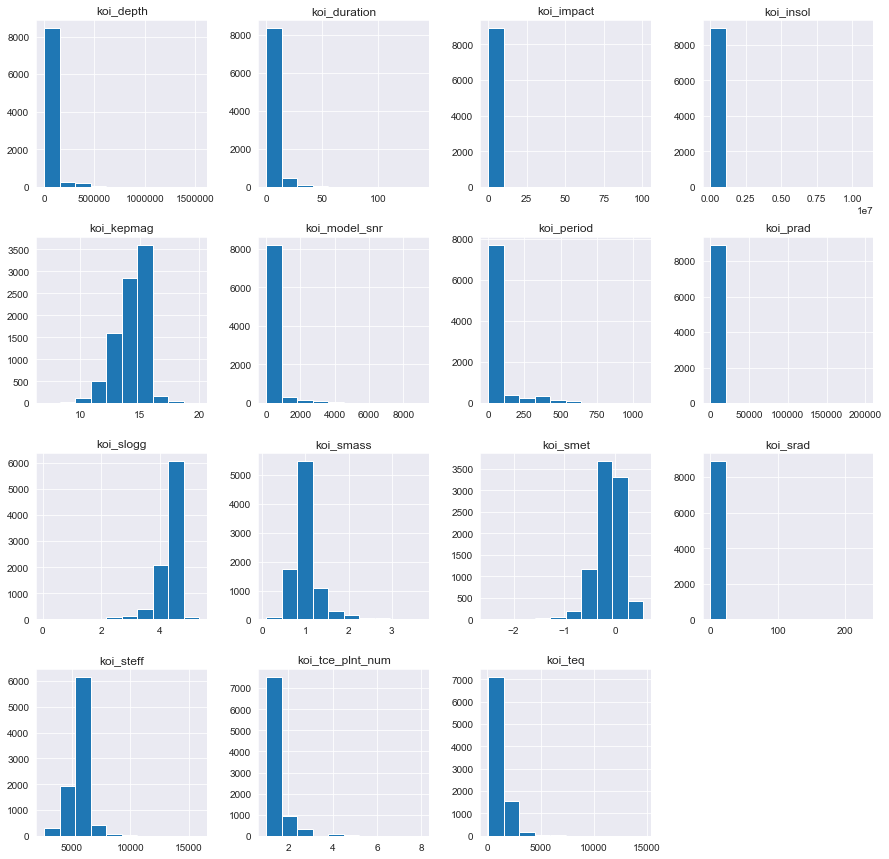

In [8]:
# examine the distributions for each variable
df.hist(figsize=(15,15));

**It looks like there are probably some outliers or other peculiar values in the data. Let's explore these, then get rid of outliers.**

In [9]:
continuous_data = ['koi_period','koi_impact','koi_duration','koi_depth', 'koi_prad',
                   'koi_teq','koi_insol','koi_model_snr','koi_steff','koi_srad']
categorical_data = ['koi_tce_plnt_num']

In [10]:
new_df = df.copy()

# removing outliers and peculiar data
indexNames = new_df[
#                     (new_df['koi_depth'] >= 4000) |
#                     (new_df['koi_duration'] >= 30) |
                    (new_df['koi_impact'] >= 1.5) |
                    (new_df['koi_insol'] >= 4500) |
                    (new_df['koi_model_snr'] >= 3000) |
#                     (new_df['koi_period'] >= 600) |
#                     (new_df['koi_prad'] >= 50) |
                    (new_df['koi_smet'] < -1.25) |
#                     (new_df['koi_srad'] > 4) |
                    (new_df['koi_steff'] >= 10000) |
                    (new_df['koi_teq'] >= 10000)].index
new_df.drop(indexNames, inplace=True)

print(len(new_df))

7775


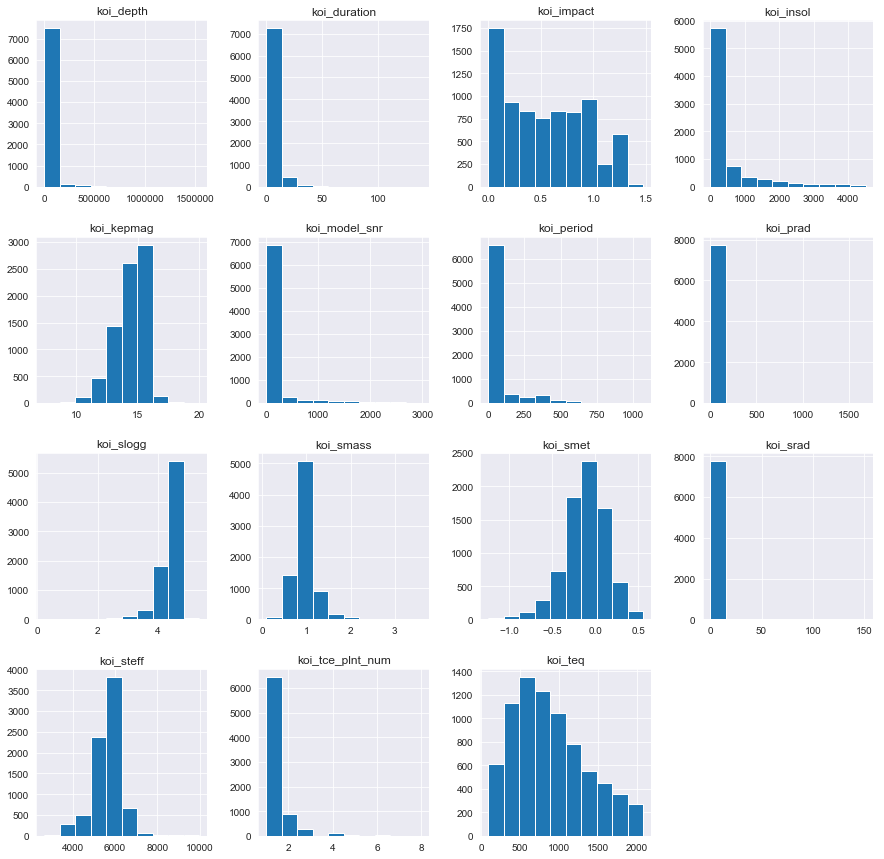

In [11]:
new_df.hist(figsize=(15,15));

**Though our elimination of NaNs and outliers reduced our dataset by over 15%, we still have over 7,500 observations, which should be more than enough to build a model.**

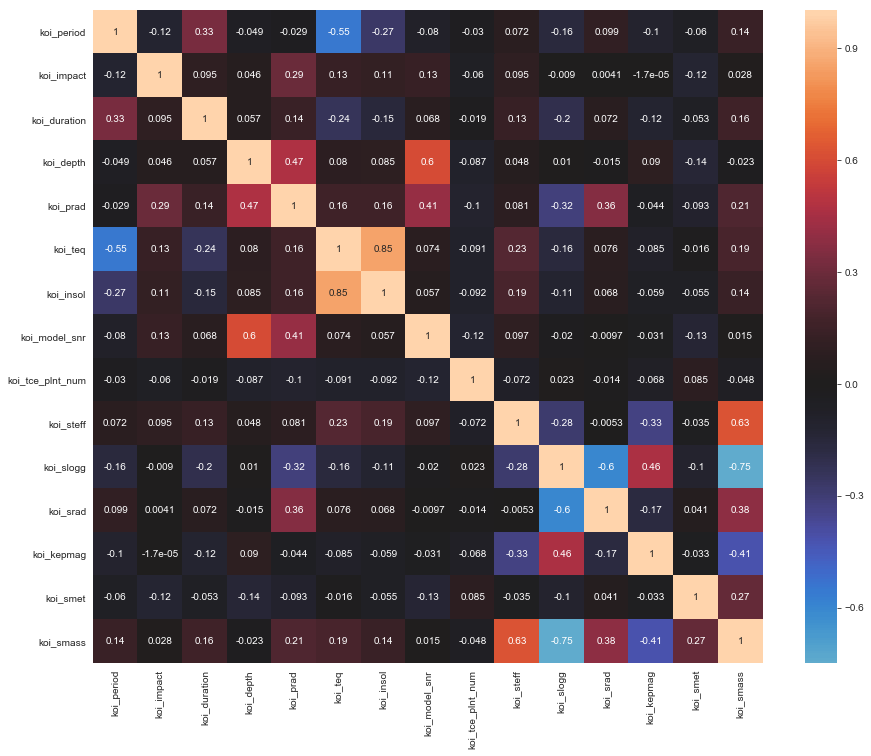

In [12]:
# look for multicollinearity
corr = new_df.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr, center=0, annot=True);

It seems there are a few instances of high multicollinearity in your dataset. Looking back to the Kepler API information website, it seems that `koi_teq` and `koi_insol` are two measures of the same thing (surface temperature), so we can safely remove one of those.

In [13]:
new_df.drop('koi_teq', axis=1, inplace=True)

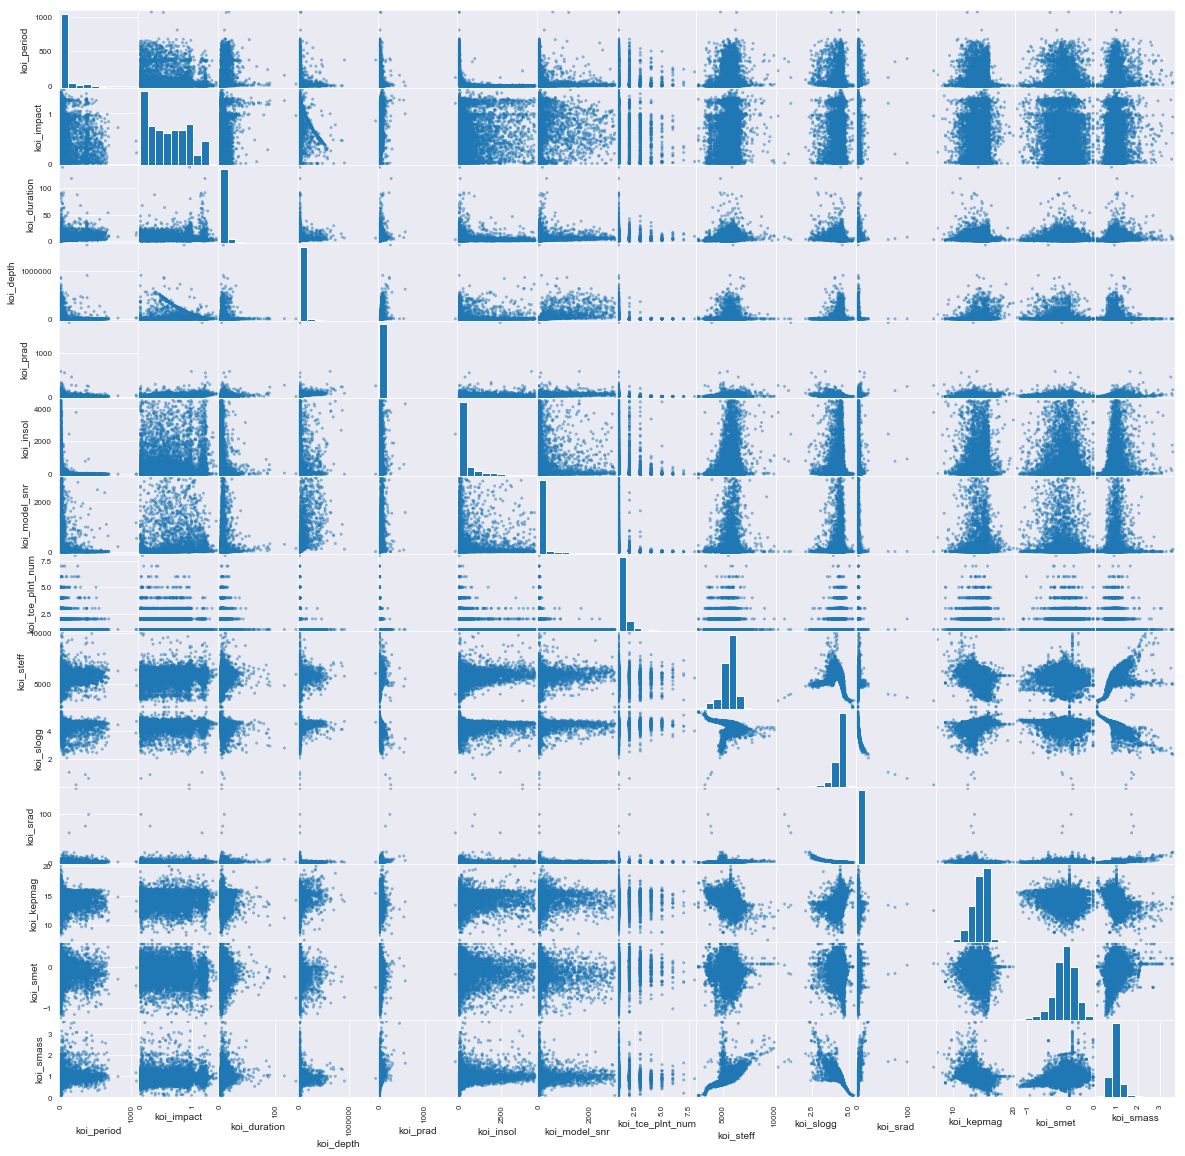

In [14]:
pd.plotting.scatter_matrix(new_df, figsize=(20,20));

The other multicollinear variables will be kept for the moment, but may be dropped later. Although they are very correlated, each one sounds like it could be an impactful measure in its own right. There are other instances of less severe multicollinearity (correlation score < |.6| ), but we will have to address these and the other multicollinear features we kept through weighting and feature engineering.

#### One-hot encoding categorical features

We actually only have one categorical variable remaining: `koi_tce_plnt_num`

In [15]:
new_df = pd.get_dummies(new_df, columns=['koi_tce_plnt_num'])

### Scaling the data & Encoding labels

First, let's log-transform some of the continuous data.

In [16]:
# Handling left skewed features
ks_max = 1 + new_df.koi_slogg.max()
new_df.koi_slogg = new_df.koi_slogg.map(lambda x: ks_max-x)

# log transforming non-linear data
non_normal = ['koi_depth', 'koi_duration', 'koi_period','koi_prad',
              'koi_srad','koi_insol','koi_model_snr', 'koi_slogg']
for feat in non_normal:
    new_df[feat] = new_df[feat].map(lambda x: np.log(x))

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [17]:
# due to wonky math, we need to address '-inf' value
new_df = new_df[new_df.koi_model_snr >= 0]

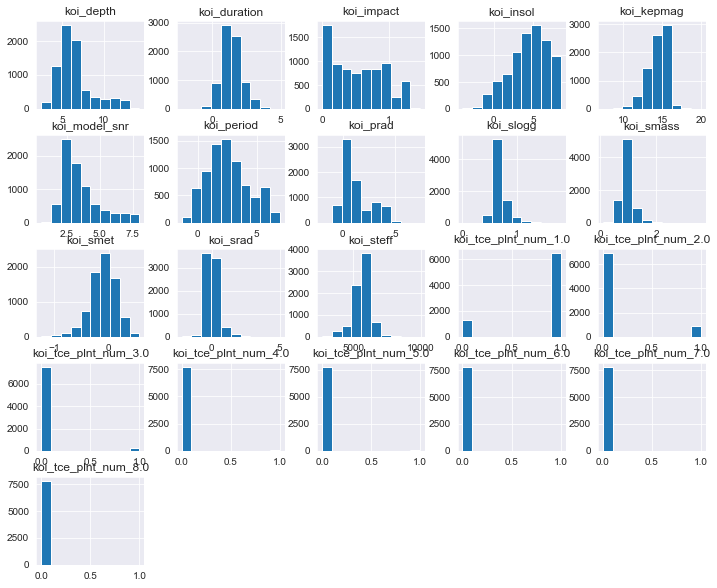

In [18]:
new_df.hist(figsize=(12,10));

**It looks like we still have a few outliers for some features, let's try to prune these out.**

In [19]:
# removing more outliers
indexNames = new_df[(new_df['koi_model_snr'] >= 500) |
                    (new_df['koi_slogg'] > 1.5) |
                    (new_df['koi_smass'] > 2) |
                    (new_df['koi_smet'] < -1.25) |
                    (new_df['koi_srad'] > 3) |
                    (new_df['koi_steff'] >= 9000)].index
new_df.drop(indexNames, inplace=True)

print(len(new_df))

7677


In [20]:
target = new_df.koi_pdisposition
variables = new_df.drop('koi_pdisposition', axis=1)

In [21]:
# encoding labels
le = LabelEncoder()
labels = pd.DataFrame(le.fit_transform(target), columns=['koi_pdisposition'])
labels.koi_pdisposition.value_counts()

0    4409
1    3268
Name: koi_pdisposition, dtype: int64

In [22]:
# scaling features
scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(variables), columns=variables.columns)

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# Exploring the Data

In [23]:
features.describe()

,koi_period,koi_impact,koi_duration,koi_depth,koi_prad,koi_insol,koi_model_snr,koi_steff,koi_slogg,koi_srad,...,koi_smet,koi_smass,koi_tce_plnt_num_1.0,koi_tce_plnt_num_2.0,koi_tce_plnt_num_3.0,koi_tce_plnt_num_4.0,koi_tce_plnt_num_5.0,koi_tce_plnt_num_6.0,koi_tce_plnt_num_7.0,koi_tce_plnt_num_8.0
count,7.677000e+03,7.677000e+03,7.677000e+03,7.677000e+03,7.677000e+03,7.677000e+03,7.677000e+03,7.677000e+03,7.677000e+03,7677.000000,...,7.677000e+03,7.677000e+03,7.677000e+03,7677.000000,7.677000e+03,7677.000000,7.677000e+03,7.677000e+03,7.677000e+03,7.677000e+03
mean,-7.404379e-17,3.331971e-17,-1.480876e-16,1.184701e-16,5.923503e-17,2.221314e-17,-6.663941e-17,4.146452e-16,-4.664759e-16,0.000000,...,2.961752e-17,3.702190e-16,-9.625693e-17,0.000000,-7.404379e-18,0.000000,5.553284e-18,-2.036204e-17,9.255474e-18,-9.255474e-19
std,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065,...,1.000065e+00,1.000065e+00,1.000065e+00,1.000065,1.000065e+00,1.000065,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00
min,-2.235092e+00,-1.385603e+00,-4.904430e+00,-1.848321e+00,-2.362136e+00,-3.501979e+00,-2.004555e+00,-4.459965e+00,-5.094975e+00,-5.198445,...,-4.428850e+00,-3.800889e+00,-2.190511e+00,-0.361432,-1.963548e-01,-0.113712,-6.863982e-02,-4.118546e-02,-2.283218e-02,-1.141386e-02
25%,-7.195249e-01,-9.307801e-01,-6.542098e-01,-6.510531e-01,-6.915475e-01,-6.444248e-01,-7.262309e-01,-4.864028e-01,-6.058750e-01,-0.538975,...,-5.917000e-01,-5.809399e-01,4.565145e-01,-0.361432,-1.963548e-01,-0.113712,-6.863982e-02,-4.118546e-02,-2.283218e-02,-1.141386e-02
50%,-1.138988e-01,-5.849942e-02,-9.414652e-02,-2.404885e-01,-3.314433e-01,1.044673e-01,-3.117042e-01,1.625268e-01,-2.228086e-01,-0.143244,...,3.477348e-02,-2.228756e-02,4.565145e-01,-0.361432,-1.963548e-01,-0.113712,-6.863982e-02,-4.118546e-02,-2.283218e-02,-1.141386e-02
75%,6.161040e-01,8.537232e-01,5.670948e-01,2.570590e-01,4.989012e-01,7.639216e-01,3.985682e-01,6.575243e-01,3.766771e-01,0.351751,...,7.004016e-01,4.659834e-01,4.565145e-01,-0.361432,-1.963548e-01,-0.113712,-6.863982e-02,-4.118546e-02,-2.283218e-02,-1.141386e-02
max,2.509043e+00,2.415325e+00,4.734332e+00,3.565201e+00,3.726909e+00,1.699577e+00,2.990115e+00,4.395661e+00,5.478345e+00,6.393882,...,2.618977e+00,4.583296e+00,4.565145e-01,2.766770,5.092823e+00,8.794131,1.456880e+01,2.428041e+01,4.379783e+01,8.761278e+01


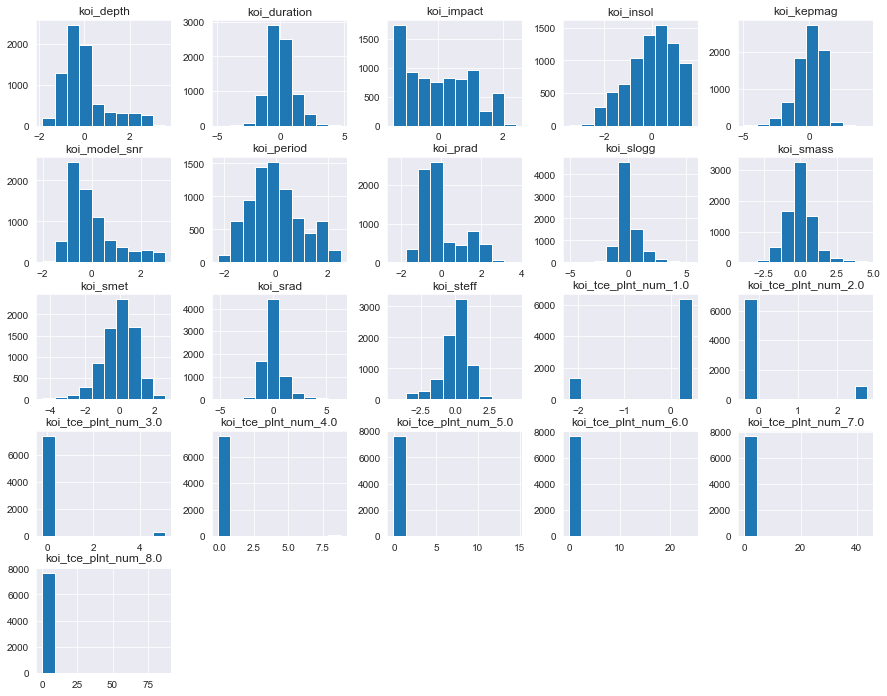

In [24]:
features.hist(figsize=(15,12));

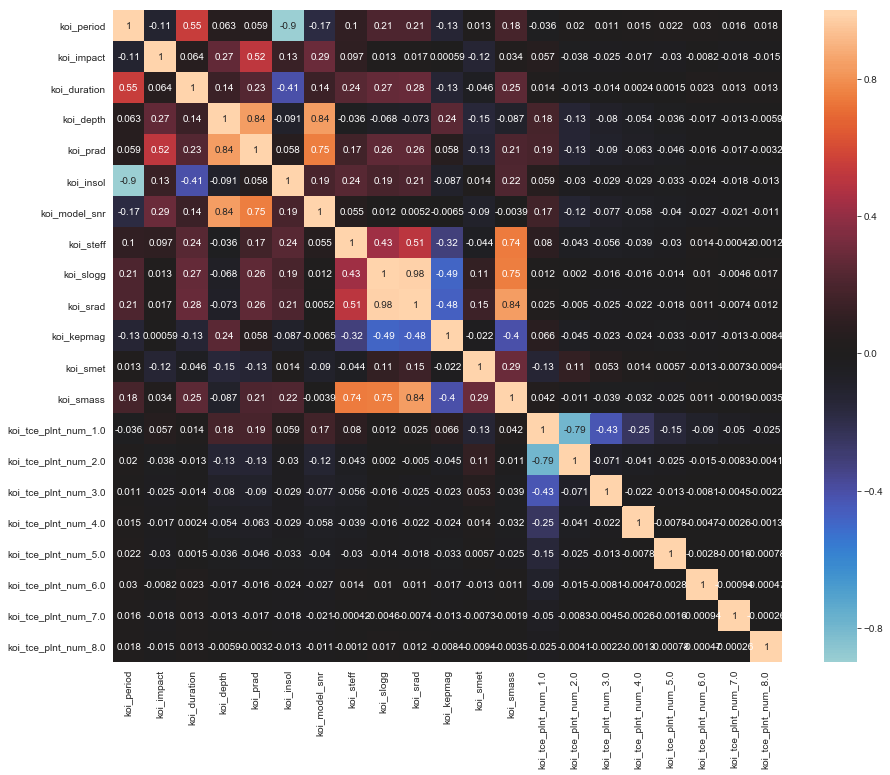

In [25]:
# look at correlation heatmap
corr = features.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr, center=0, annot=True);

### Handling multicollinearity

Let's engineer a few features to try to reduce some of the extreme multicollinearity seen in the heatmap above.

In [26]:
# creating a separate dataset for use with PCA later on
features_for_PCA = features.copy()
labels_PCA = labels.copy()

#### Building features

In [27]:
features_orig = features.copy()   #just in case
features['target'] = labels.koi_pdisposition.values

In [28]:
def feature_builder(var_1, var_2, target, dataset):
    """
    Parameters :
    ------------
    var_1 : column name of first correlated variable
    var_2 : column name of second correlated variable
    target : column name of target variable
    dataset : DataFrame that holds the data and will receive updates
    """
    weights = np.linspace(0, 1, 10000)
    max_corr = -1
    best_weights = None
    corrs = []

    for index, weight in enumerate(weights):
        w1 = weight       # get the first weight value
        w2 = 1 - weight   # get the second weight value
        vals = w1*dataset[var_1] + w2*dataset[var_2] # create a linear combination of the columns
        corr_coeff = np.abs(np.corrcoef(vals, dataset[target]))[0][1] # get the corrcoeff with the target

        # if the corr_coeff is larger than the max, store the weights and change the max
        if corr_coeff > max_corr:
            best_weights = [w1, w2]
            max_corr = corr_coeff

        # store the correlation coefficients to a list
        corrs.append(corr_coeff)  
    
    # output the desired weights
    print('weight for [',var_1,'] : weight for [',var_2,']\n  ', best_weights)
    feat_label = str(var_1+'_'+var_2+'_feat')
    print('feature name:', feat_label)
    
    # add feature to dataset & remove input columns
    dataset[feat_label] = w1*dataset[var_1] + w2*dataset[var_2]
    dataset.drop([var_1, var_2], axis=1, inplace=True)
    pass

In [29]:
features = features_orig.copy()
features['target'] = labels.koi_pdisposition.values

In [30]:
# Dropping highly collinear features (originally done
# one at a time, re-checking heatmap after each drop)
features.drop(['koi_insol','koi_srad','koi_prad',
               'koi_model_snr', 'koi_steff'], axis=1, inplace=True)

In [31]:
feature_builder('koi_smass','koi_slogg', 'target', features)

weight for [ koi_smass ] : weight for [ koi_slogg ]
   [0.6277627762776278, 0.3722372237223722]
feature name: koi_smass_koi_slogg_feat


In [32]:
feature_builder('koi_tce_plnt_num_1.0','koi_tce_plnt_num_2.0', 'target', features)

weight for [ koi_tce_plnt_num_1.0 ] : weight for [ koi_tce_plnt_num_2.0 ]
   [0.9101910191019102, 0.08980898089808975]
feature name: koi_tce_plnt_num_1.0_koi_tce_plnt_num_2.0_feat


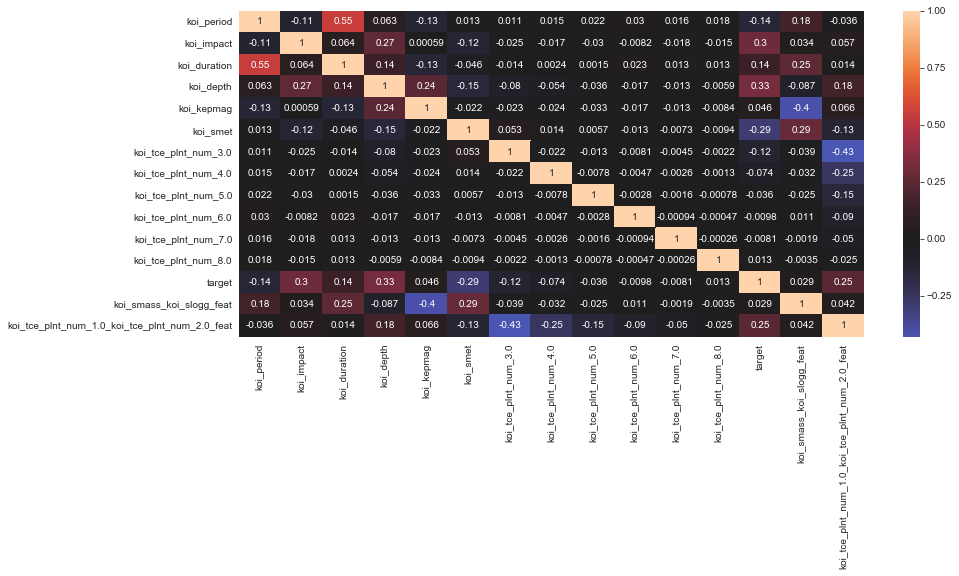

In [33]:
# look at correlation heatmap
corr = features.corr()
plt.figure(figsize=(14,6))
sns.heatmap(corr, center=0, annot=True);

In [34]:
features.drop(['target'], axis=1, inplace=True)

In [35]:
features.columns

Index(['koi_period', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_kepmag',
       'koi_smet', 'koi_tce_plnt_num_3.0', 'koi_tce_plnt_num_4.0',
       'koi_tce_plnt_num_5.0', 'koi_tce_plnt_num_6.0', 'koi_tce_plnt_num_7.0',
       'koi_tce_plnt_num_8.0', 'koi_smass_koi_slogg_feat',
       'koi_tce_plnt_num_1.0_koi_tce_plnt_num_2.0_feat'],
      dtype='object')

In [36]:
features.columns = ['koi_period', 'koi_impact', 'koi_duration', 'koi_depth',
                    'koi_kepmag', 'koi_smet', 'koi_tce_plnt_num_3.0', 
                    'koi_tce_plnt_num_4.0', 'koi_tce_plnt_num_5.0', 
                    'koi_tce_plnt_num_6.0', 'koi_tce_plnt_num_7.0',
                    'koi_tce_plnt_num_8.0', 'smass_slogg_feat',
                    'tce_plnt_num_1.0_2.0_feat']

In [37]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7677 entries, 0 to 7676
Data columns (total 14 columns):
koi_period                   7677 non-null float64
koi_impact                   7677 non-null float64
koi_duration                 7677 non-null float64
koi_depth                    7677 non-null float64
koi_kepmag                   7677 non-null float64
koi_smet                     7677 non-null float64
koi_tce_plnt_num_3.0         7677 non-null float64
koi_tce_plnt_num_4.0         7677 non-null float64
koi_tce_plnt_num_5.0         7677 non-null float64
koi_tce_plnt_num_6.0         7677 non-null float64
koi_tce_plnt_num_7.0         7677 non-null float64
koi_tce_plnt_num_8.0         7677 non-null float64
smass_slogg_feat             7677 non-null float64
tce_plnt_num_1.0_2.0_feat    7677 non-null float64
dtypes: float64(14)
memory usage: 839.8 KB


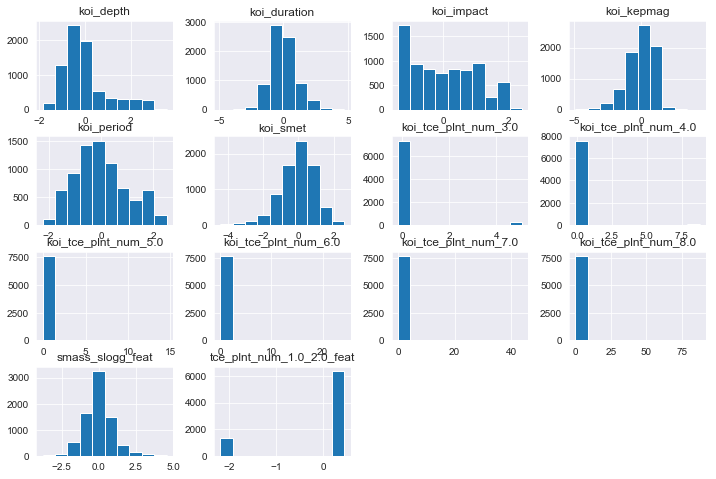

In [38]:
features.hist(figsize=(12,8));

### Recursive Feature Elimination

In [39]:
xgb0 = XGBClassifier(learning_rate=0.1, n_estimators=1000,
                     objective='binary:logistic',
                     nthread=4,seed=42)
rfecv = RFECV(estimator=xgb0, step=1, cv=StratifiedKFold(),
              scoring='accuracy', n_jobs=4)
rfecv.fit(features, labels.values.flatten())

print(f"Optimal number of features : {rfecv.n_features_}")

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


Optimal number of features : 7


**Well, it appears that we do not gain much information by using more than 7 features. In the next section we will run a model and visualize feature importances to see which 7 features are the most important.**

In [40]:
# define a function to generate a confusion matrix
def confu_matrix(y_pred, x_tst, y_tst):
    import warnings
    warnings.filterwarnings('ignore')
    y_pred = np.array(y_pred).flatten()
    y_tst = np.array(y_tst).flatten()
    cm = confusion_matrix(y_tst.flatten(), y_pred.flatten())
    sns.heatmap(cm, annot=True, fmt='0g', 
                annot_kws={'size':14, 'ha':'center', 'va':'top'})
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='0.01%', 
                annot_kws={'size':14, 'ha':'center', 'va':'bottom'})
    plt.title('Confusion Matrix', fontsize=14)
    plt.show();

Number of mislabeled points out of a total points : 2696
Accuracy: 64.88000000000001 %


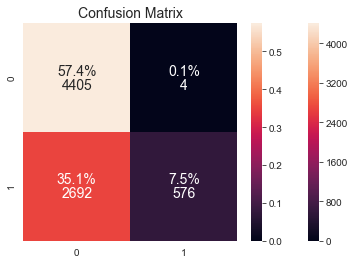

In [41]:
# very simple test model with Guassian Naive Bayes
gnb = GaussianNB()
y_pred = gnb.fit(features, labels.values.flatten()).predict(features)
wrong = (labels.koi_pdisposition.values != y_pred).sum()
print(f"Number of mislabeled points out of a total points : {wrong}")
print("Accuracy:",round(accuracy_score(labels, y_pred),4)*100,"%")
confu_matrix(gnb.predict(features), features, labels)

# Modeling the data

### Train, test, split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42)

In [43]:
classifiers = [KNeighborsClassifier, SVC, DecisionTreeClassifier,
               RandomForestClassifier, AdaBoostClassifier,
               XGBClassifier, LogisticRegression, GaussianNB]

In [44]:
classy_scores = []
for classifier in classifiers:
    clf = classifier()
    clf.fit(X_train, y_train.values.flatten())
    score = clf.score(X_test, y_test.values.flatten())
    classy_scores.append((str(classifier), score))
ranked_classifiers = sorted(classy_scores, key=lambda x: x[1], reverse=True)

ranked_classifiers

[("<class 'sklearn.svm.classes.SVC'>", 0.8296875),
 ("<class 'xgboost.sklearn.XGBClassifier'>", 0.8197916666666667),
 ("<class 'sklearn.ensemble.forest.RandomForestClassifier'>",
  0.8166666666666667),
 ("<class 'sklearn.neighbors.classification.KNeighborsClassifier'>",
  0.8083333333333333),
 ("<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>", 0.803125),
 ("<class 'sklearn.tree.tree.DecisionTreeClassifier'>", 0.7677083333333333),
 ("<class 'sklearn.linear_model.logistic.LogisticRegression'>", 0.7546875),
 ("<class 'sklearn.naive_bayes.GaussianNB'>", 0.6494791666666667)]

### Trying XGBoost without PCA

In [45]:
# create a function to automate model fitting and visualizing feature importance
def modelfit(alg, x_tr, y_tr, x_tst, y_tst, n_estims=1000, 
             early_stopping_rounds=10, eval_metric='error@.8'):
    """
    Inputs:
    alg: instantiated model
    X_train / X_test / y_train / y_test
    n_estims: number of trees to create
    early_stopping_rounds: number of rounds of no scoring metric improvement
                           after which the cross validation will stop
    """
    #Fit the algorithm on the data
    eval_set = [(x_tst, y_tst)]
    alg.fit(x_tr, y_tr, eval_metric=eval_metric, eval_set=eval_set,
            verbose=False, early_stopping_rounds=10)
    
    #Predict training set:
    dtrain_predictions = alg.predict(x_tr)
    dtrain_predprob = alg.predict_proba(x_tr)[:,1]
    #Predict testing set:
    dtest_predictions = alg.predict(x_tst)
    dtest_predprob = alg.predict_proba(x_tst)[:,1]
    
    #Print model report:
    print("Model Report")
    print(f"Train accuracy: {round(accuracy_score(y_tr, dtrain_predictions), 4)*100}%")
    print(f"Test accuracy: {round(accuracy_score(y_tst, dtest_predictions), 4)*100}%")
    print(f"AUC Score (Train): {roc_auc_score(y_tr, dtrain_predprob)}")
    print(f"AUC Score (Test): {roc_auc_score(y_tst, dtest_predprob)}")
    
    # plotting feature importances
    feat_imp = pd.Series(alg.get_booster()\
                         .get_score(importance_type='weight'))\
                         .sort_values(ascending=False)
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    feat_imp.plot(kind='bar')
    plt.title('Feature Importances', fontsize=14)
    plt.ylabel('Feature Importance Score', fontsize=14)
    plt.xticks(fontsize=14, rotation=45, horizontalalignment='right')
    
    # plotting confusion matrix
    plt.subplot(122)
    confu_matrix(alg.predict(x_tst), x_tst, y_tst);

Model Report
Train accuracy: 86.29%
Test accuracy: 82.28999999999999%
AUC Score (Train): 0.9403830504927396
AUC Score (Test): 0.8979949894317066


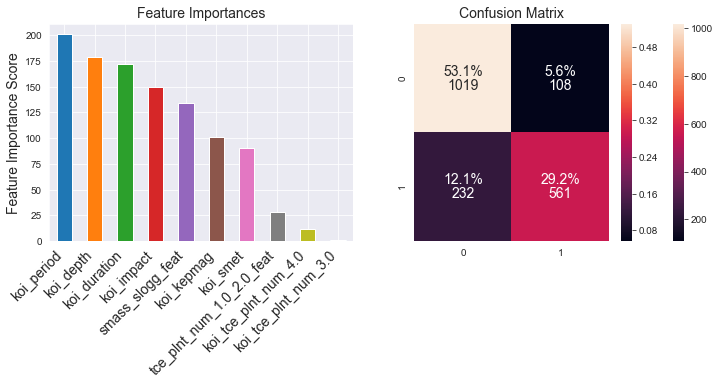

In [46]:
xgb1 = XGBClassifier(learning_rate=0.1,
                     n_estimators=1000,
                     objective='binary:logistic',
                     nthread=4,
                     seed=42)
modelfit(xgb1, X_train, y_train.values.flatten(), X_test, y_test.values.flatten(), 1000, 20)

**Now we know which features are the most important, so let's drop everything but the top 7 features.**

In [47]:
features = features[['koi_period', 'koi_impact', 'koi_duration',
                     'koi_depth', 'koi_kepmag', 'koi_smet',
                     'smass_slogg_feat']]

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42)

Model Report
Train accuracy: 85.24000000000001%
Test accuracy: 82.03%
AUC Score (Train): 0.9291000806357297
AUC Score (Test): 0.8913546996736083


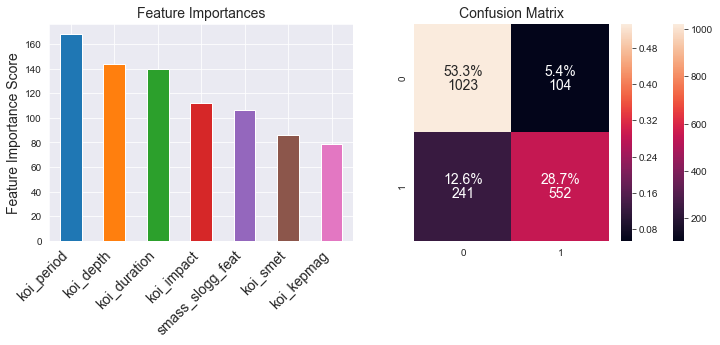

In [48]:
xgb1 = XGBClassifier(learning_rate=0.1,
                     n_estimators=1000,
                     objective='binary:logistic',
                     nthread=4,
                     seed=42)
modelfit(xgb1, X_train, y_train.values.flatten(), X_test, y_test.values.flatten(), 1000, 20)

**The test accuracy dropped very slightly but, more importantly, we have reduced overfitting by a larger margin.**

## Trying to build a function to chain estimators together

I'm trying to build a function(s) that will fit a model, take the observations for which the model had a low-confidence prediction, and then fit a different model on that subset of data.

In [49]:
def low_conf_preds(estimator, x_tr, y_tr, threshold=.8):
    """
    Identifies model predictions made with low confidence
    ---------------Inputs-------------------------------
    estimator :   model instance which will generate predictions
    x_tr :        X_train
    y_tr :        y_train
    threshold :   value in range .51-.99 (default=0.8)
    ----------------Returns 6 datasets:-----------------
    low-conf. X
    low-conf. y
    low-conf. model predictions
    high-conf. X
    high-conf. y
    high-conf. model predictions
    """
    # fitting and making predictions
    # estimator.fit(x_tr, y_tr)
    pred_probs = estimator.predict_proba(x_tr)
    preds = estimator.predict(x_tr)
    
    #combining all data into one dataframe
    x_tr['no'] = pred_probs[:,0]
    x_tr['yes'] = pred_probs[:,1]
    x_tr['pred'] = preds
    x_tr['target'] = y_tr.values.flatten()
    X_low_conf = x_tr.loc[(x_tr.no <= threshold) & (x_tr.yes <= threshold)]
    X_high_conf = x_tr.loc[(x_tr.no > threshold) | (x_tr.yes > threshold)]
    y_low_conf = X_low_conf['target']
    y_high_conf = X_high_conf['target']
    y_low_preds = X_low_conf['pred']
    y_high_preds = X_high_conf['pred']
    
    # removing unwanted columns from dataframes
    X_low_conf.drop(['no','yes','target','pred'], axis=1, inplace=True)
    X_high_conf.drop(['no','yes','target','pred'], axis=1, inplace=True)
    x_tr.drop(['no','yes','target','pred'], axis=1, inplace=True)
    
    return X_low_conf, y_low_conf, y_low_preds, X_high_conf, y_high_conf, y_high_preds

[0]	validation_0-error@0.8:0.413021
Will train until validation_0-error@0.8 hasn't improved in 10 rounds.
[1]	validation_0-error@0.8:0.413021
[2]	validation_0-error@0.8:0.413021
[3]	validation_0-error@0.8:0.413021
[4]	validation_0-error@0.8:0.413021
[5]	validation_0-error@0.8:0.413021
[6]	validation_0-error@0.8:0.413021
[7]	validation_0-error@0.8:0.413021
[8]	validation_0-error@0.8:0.413021
[9]	validation_0-error@0.8:0.382813
[10]	validation_0-error@0.8:0.328125
[11]	validation_0-error@0.8:0.320313
[12]	validation_0-error@0.8:0.310417
[13]	validation_0-error@0.8:0.306771
[14]	validation_0-error@0.8:0.301042
[15]	validation_0-error@0.8:0.297396
[16]	validation_0-error@0.8:0.291667
[17]	validation_0-error@0.8:0.290625
[18]	validation_0-error@0.8:0.284896
[19]	validation_0-error@0.8:0.283333
[20]	validation_0-error@0.8:0.282292
[21]	validation_0-error@0.8:0.282292
[22]	validation_0-error@0.8:0.280729
[23]	validation_0-error@0.8:0.276563
[24]	validation_0-error@0.8:0.276042
[25]	validation

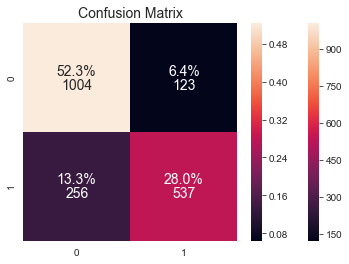

In [50]:
# Fitting models to training data
model1 = XGBClassifier(learning_rate=0.1, n_estimators=1000, objective='binary:logistic',
                     nthread=4, scale_pos_weight=1, seed=42)
model2 = SVC(probability=True, kernel='rbf', C=1, class_weight='balanced', gamma='auto', random_state=42)
model3 = RandomForestClassifier()

eval_set=[(X_test, y_test)]
model1.fit(X_train, y_train, eval_metric='error@.8', eval_set=eval_set, early_stopping_rounds=10)
x_low1, y_low1, y_low1_preds, x_high1, y_high1, y_high1_preds = low_conf_preds(model1, X_train, y_train, .8)

model2.fit(x_low1, y_low1)
x_low2, y_low2, y_low2_preds, x_high2, y_high2, y_high2_preds = low_conf_preds(model2, x_low1, y_low1, .8)

model3.fit(x_low2, y_low2)
x_low3, y_low3, y_low3_preds, x_high3, y_high3, y_high3_preds = low_conf_preds(model3, x_low2, y_low2, .8)


x_trnnn = x_high1.append(x_high2).append(x_low3).append(x_high3)
y_trnnn = y_high1.append(y_high2).append(y_low3).append(y_high3)
y_hat = y_high1_preds.append(y_high2_preds).append(y_low3_preds).append(y_high3_preds)

# Running models on testing data
x_low1t, y_low1t, y_low1_predst, x_high1t, y_high1t, y_high1_predst = low_conf_preds(model1, X_test, y_test, .8)
x_low2t, y_low2t, y_low2_predst, x_high2t, y_high2t, y_high2_predst = low_conf_preds(model2, x_low1t, y_low1t, .8)
x_low3t, y_low3t, y_low3_predst, x_high3t, y_high3t, y_high3_predst = low_conf_preds(model3, x_low2t, y_low2t, .8)

x_tsttt = x_high1t.append(x_high2t).append(x_low3t).append(x_high3t)
y_tsttt = y_high1t.append(y_high2t).append(y_low3t).append(y_high3t)
y_hat_tst = y_high1_predst.append(y_high2_predst).append(y_low3_predst).append(y_high3_predst)

print(f"Train accuracy : {accuracy_score(y_train.sort_index().values, y_hat.sort_index())}")
print(f"Test accuracy : {accuracy_score(y_test.sort_index().values, y_hat_tst.sort_index())}")
# confu_matrix(y_hat, x_trnnn, y_trnnn) #train confusion matrix
confu_matrix(y_hat_tst, x_tsttt, y_tsttt) #test confusion matrix

### Using GridSearchCV to tune hyperparameters

In [51]:
# defining functions to get the best parameters
def get_best_params(cv_results):
    """
    input:     model.cv_results_
    returns:   dictionary of parameters with the highest harmonic 
    mean balancing mean_test_score and (1 - test_train_diff)
    This reduces overfitting while maximizing test score.
    """
    dfp = pd.DataFrame(cv_results)
    dfp['test_train_diff'] = np.abs(dfp['mean_train_score'] - dfp['mean_test_score'])
    dfp['harmonic'] = 2 / ((1 / dfp['mean_test_score']) + (1 / (1-dfp['test_train_diff'])))
    dfp.sort_values(by='harmonic', ascending=False, inplace=True)
    dfp.reset_index(drop=True, inplace=True)
    
    params = {}
    for key, val in dfp.iloc[0].params.items():
        params[key] = [val]
    return params

In [52]:
def gridsearch_params(estimator, params_test, old_params=None, 
                      update_params=True, scoring='accuracy',
                      eval_metric='error@.80', xgb=False):
    """
    Inputs an instantiated estimator and a dictionary of parameters
    for tuning (optionally an old dictionary of established parameters)
    Returns a dictionary of the new best parameters.
    Requires X_train, X_test, y_train, y_test to exist as global variables.
    """
    import warnings
    warnings.filterwarnings('ignore')
    if update_params:
        old_params.update(params_test)
        params_test = old_params
    gsearch1 = GridSearchCV(estimator=estimator, refit=True,
                            param_grid=params_test, scoring=scoring,
                            n_jobs=4, iid=False, cv=5)
    if xgb:
        gsearch1.fit(X_train, y_train.values.flatten(), early_stopping_rounds=10, 
                     eval_set=[(X_test, y_test.values.flatten())], 
                     eval_metric=eval_metric, verbose=False)
    else:
        gsearch1.fit(X_train, y_train.values.flatten())
    best_params = get_best_params(gsearch1.cv_results_)
    gsearch1a = GridSearchCV(estimator=estimator, refit=True,
                             param_grid=best_params, scoring=scoring,
                             n_jobs=4, iid=False, cv=5)
    if xgb:
        gsearch1a.fit(X_train, y_train.values.flatten(), early_stopping_rounds=10,
                      eval_set=[(X_test, y_test.values.flatten())],
                      eval_metric=eval_metric, verbose=False)
    else:
        gsearch1a.fit(X_train, y_train.values.flatten())
    confu_matrix(gsearch1a.predict(X_test), X_test, y_test)
    tr_acc = round(accuracy_score(y_train.values.flatten(),
                                  gsearch1a.predict(X_train)), 4)*100
    tst_acc = round(accuracy_score(y_test.values.flatten(),
                                   gsearch1a.predict(X_test)), 4)*100
    print(f"Train accuracy: {tr_acc}%\nTest accuracy: {tst_acc}%\n{best_params}")
    return best_params, gsearch1a

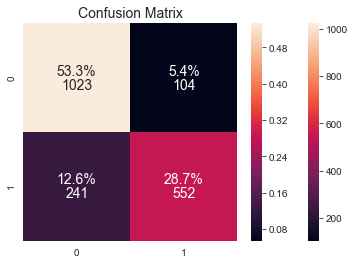

Train accuracy: 85.24000000000001%
Test accuracy: 82.03%
{}


In [53]:
# default XGBClassifier parameters
param_test0 = {}
xgb1a = XGBClassifier(learning_rate=0.1, n_estimators=1000,
                      objective='binary:logistic', nthread=4, seed=42)
best_params, xgb_gs0 = gridsearch_params(xgb1a, param_test0,
                                         update_params=False, xgb=True)

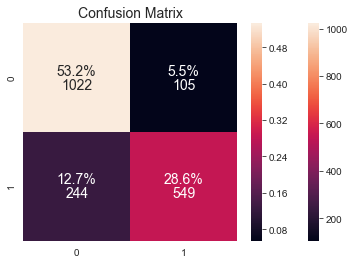

Train accuracy: 84.28%
Test accuracy: 81.82000000000001%
{'max_depth': [3], 'min_child_weight': [4]}


In [54]:
param_test1 = {'max_depth':range(3,8),
               'min_child_weight':range(1,6)
              }
xgb1a = XGBClassifier(learning_rate=0.1, n_estimators=1000,
                      objective='binary:logistic', nthread=4, seed=42)
best_params, xgb_gs1 = gridsearch_params(xgb1a, param_test1,
                                         update_params=False, xgb=True)

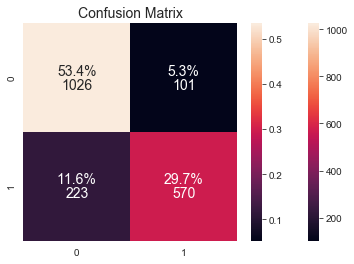

Train accuracy: 84.96000000000001%
Test accuracy: 83.12%
{'colsample_bytree': [0.95], 'gamma': [0.2], 'max_depth': [3], 'min_child_weight': [4], 'subsample': [0.8]}


In [55]:
param_test2 = {'gamma': np.linspace(0.0, 0.25, 6),
               'subsample':np.linspace(.8, 1.0, 5),
               'colsample_bytree':np.linspace(.8, 1.0, 5)
              }
xgb1a = XGBClassifier(learning_rate=0.1, n_estimators=1000,
                      objective='binary:logistic', nthread=4, seed=42)
best_params, xgb_gs2 = gridsearch_params(xgb1a, param_test2, best_params,
                                         update_params=True, xgb=True)

In [56]:
# be sure to input values seen in printout above!
mod_xgb_grid = XGBClassifier(learning_rate=0.1, n_estimators=1000,
                             colsample_bytree=0.95, gamma=0.05, max_depth=3,
                             min_child_weight=4, subsample=0.8,
                             objective='binary:logistic', nthread=4, seed=42)

[0]	validation_0-error@0.8:0.413021
[1]	validation_0-error@0.8:0.413021
[2]	validation_0-error@0.8:0.413021
[3]	validation_0-error@0.8:0.413021
[4]	validation_0-error@0.8:0.413021
[5]	validation_0-error@0.8:0.413021
[6]	validation_0-error@0.8:0.413021
[7]	validation_0-error@0.8:0.413021
[8]	validation_0-error@0.8:0.407292
[9]	validation_0-error@0.8:0.398958
[10]	validation_0-error@0.8:0.394271
[11]	validation_0-error@0.8:0.390104
[12]	validation_0-error@0.8:0.374479
[13]	validation_0-error@0.8:0.358854
[14]	validation_0-error@0.8:0.333333
[15]	validation_0-error@0.8:0.348437
[16]	validation_0-error@0.8:0.323438
[17]	validation_0-error@0.8:0.317708
[18]	validation_0-error@0.8:0.309896
[19]	validation_0-error@0.8:0.301562
[20]	validation_0-error@0.8:0.297917
[21]	validation_0-error@0.8:0.29375
[22]	validation_0-error@0.8:0.290104
[23]	validation_0-error@0.8:0.289583
[24]	validation_0-error@0.8:0.286458
[25]	validation_0-error@0.8:0.283854
[26]	validation_0-error@0.8:0.279167
[27]	validat

[220]	validation_0-error@0.8:0.210938
[221]	validation_0-error@0.8:0.210938
[222]	validation_0-error@0.8:0.210938
[223]	validation_0-error@0.8:0.210938
[224]	validation_0-error@0.8:0.210938
[225]	validation_0-error@0.8:0.210417
[226]	validation_0-error@0.8:0.210417
[227]	validation_0-error@0.8:0.210938
[228]	validation_0-error@0.8:0.210417
[229]	validation_0-error@0.8:0.210417
[230]	validation_0-error@0.8:0.210417
[231]	validation_0-error@0.8:0.209896
[232]	validation_0-error@0.8:0.210417
[233]	validation_0-error@0.8:0.208854
[234]	validation_0-error@0.8:0.208333
[235]	validation_0-error@0.8:0.207813
[236]	validation_0-error@0.8:0.207813
[237]	validation_0-error@0.8:0.208854
[238]	validation_0-error@0.8:0.208854
[239]	validation_0-error@0.8:0.207813
[240]	validation_0-error@0.8:0.207813
[241]	validation_0-error@0.8:0.207813
[242]	validation_0-error@0.8:0.208333
[243]	validation_0-error@0.8:0.208333
[244]	validation_0-error@0.8:0.208333
[245]	validation_0-error@0.8:0.208333
[246]	valida

[437]	validation_0-error@0.8:0.202604
[438]	validation_0-error@0.8:0.203646
[439]	validation_0-error@0.8:0.204167
[440]	validation_0-error@0.8:0.204167
[441]	validation_0-error@0.8:0.204167
[442]	validation_0-error@0.8:0.203646
[443]	validation_0-error@0.8:0.203646
[444]	validation_0-error@0.8:0.204167
[445]	validation_0-error@0.8:0.204167
[446]	validation_0-error@0.8:0.204167
[447]	validation_0-error@0.8:0.203646
[448]	validation_0-error@0.8:0.203646
[449]	validation_0-error@0.8:0.203646
[450]	validation_0-error@0.8:0.203125
[451]	validation_0-error@0.8:0.203125
[452]	validation_0-error@0.8:0.203125
[453]	validation_0-error@0.8:0.203125
[454]	validation_0-error@0.8:0.203125
[455]	validation_0-error@0.8:0.203646
[456]	validation_0-error@0.8:0.203125
[457]	validation_0-error@0.8:0.203125
[458]	validation_0-error@0.8:0.203125
[459]	validation_0-error@0.8:0.203646
[460]	validation_0-error@0.8:0.203646
[461]	validation_0-error@0.8:0.203646
[462]	validation_0-error@0.8:0.203125
[463]	valida

[660]	validation_0-error@0.8:0.201042
[661]	validation_0-error@0.8:0.201042
[662]	validation_0-error@0.8:0.201042
[663]	validation_0-error@0.8:0.201042
[664]	validation_0-error@0.8:0.201042
[665]	validation_0-error@0.8:0.201042
[666]	validation_0-error@0.8:0.201562
[667]	validation_0-error@0.8:0.202083
[668]	validation_0-error@0.8:0.202083
[669]	validation_0-error@0.8:0.201562
[670]	validation_0-error@0.8:0.201042
[671]	validation_0-error@0.8:0.201042
[672]	validation_0-error@0.8:0.200521
[673]	validation_0-error@0.8:0.200521
[674]	validation_0-error@0.8:0.200521
[675]	validation_0-error@0.8:0.201042
[676]	validation_0-error@0.8:0.201042
[677]	validation_0-error@0.8:0.201562
[678]	validation_0-error@0.8:0.201562
[679]	validation_0-error@0.8:0.201562
[680]	validation_0-error@0.8:0.200521
[681]	validation_0-error@0.8:0.200521
[682]	validation_0-error@0.8:0.200521
[683]	validation_0-error@0.8:0.201042
[684]	validation_0-error@0.8:0.201042
[685]	validation_0-error@0.8:0.201042
[686]	valida

[879]	validation_0-error@0.8:0.196354
[880]	validation_0-error@0.8:0.196354
[881]	validation_0-error@0.8:0.196354
[882]	validation_0-error@0.8:0.196354
[883]	validation_0-error@0.8:0.196354
[884]	validation_0-error@0.8:0.195833
[885]	validation_0-error@0.8:0.195833
[886]	validation_0-error@0.8:0.196875
[887]	validation_0-error@0.8:0.196875
[888]	validation_0-error@0.8:0.196875
[889]	validation_0-error@0.8:0.196875
[890]	validation_0-error@0.8:0.196875
[891]	validation_0-error@0.8:0.197396
[892]	validation_0-error@0.8:0.197396
[893]	validation_0-error@0.8:0.196875
[894]	validation_0-error@0.8:0.196875
[895]	validation_0-error@0.8:0.196354
[896]	validation_0-error@0.8:0.197396
[897]	validation_0-error@0.8:0.196875
[898]	validation_0-error@0.8:0.197396
[899]	validation_0-error@0.8:0.197396
[900]	validation_0-error@0.8:0.197396
[901]	validation_0-error@0.8:0.197396
[902]	validation_0-error@0.8:0.197396
[903]	validation_0-error@0.8:0.197396
[904]	validation_0-error@0.8:0.197396
[905]	valida

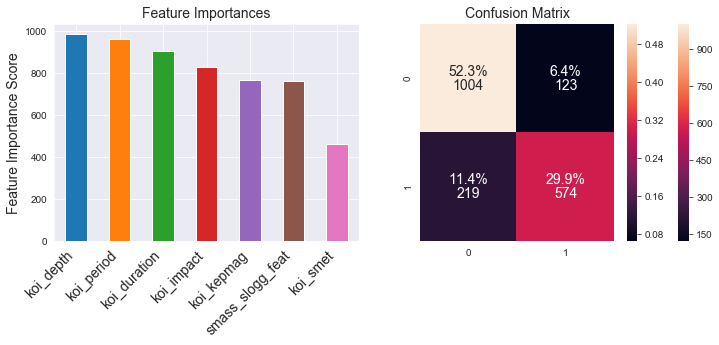

In [57]:
# Looking at feature importances
mod_xgb_grid.fit(X_train, y_train, eval_metric='error@.8',
                 eval_set=[(X_test, y_test.values.flatten())])

feat_imp = pd.Series(mod_xgb_grid.get_booster()\
                     .get_score(importance_type='weight'))\
                     .sort_values(ascending=False)

print(f"\nTrain accuracy: {round(accuracy_score(y_train.values.flatten(), mod_xgb_grid.predict(X_train)), 4)*100}%")
print(f"Test accuracy: {round(accuracy_score(y_test.values.flatten(), mod_xgb_grid.predict(X_test)), 4)*100}%")

plt.figure(figsize=(12,4))
plt.subplot(121)
feat_imp.plot(kind='bar')
plt.title('Feature Importances', fontsize=14)
plt.ylabel('Feature Importance Score', fontsize=14)
plt.xticks(fontsize=14, rotation=45, horizontalalignment='right')

# plotting confusion matrix
plt.subplot(122)
confu_matrix(mod_xgb_grid.predict(X_test), X_test, y_test);

### Chaining through two other models

In [58]:
# Fitting model 1 to training data
model1 = xgb_gs2
# model1.fit(X_train, y_train, eval_metric='error@.8',
#                  eval_set=[(X_test, y_test.values.flatten())])
x_low1, y_low1, y_low1_preds, x_high1, y_high1, y_high1_preds = low_conf_preds(model1, X_train, y_train, .8)

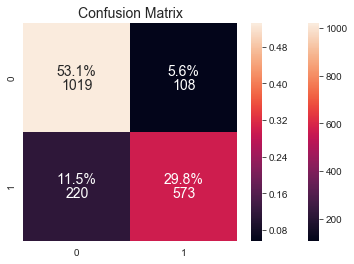

Train accuracy: 85.24000000000001%
Test accuracy: 82.92%
{}


In [59]:
# Testing SVC vanilla just to see how it performs
svc = SVC(random_state=42, gamma='auto')
svc_params = {}
best_params, model2 = gridsearch_params(svc, svc_params, update_params=False)

**Regrettably, when using SVC with the rbf kernel, there is no way to determine feature importances since rbf essentially transforms the data into a higher dimensional space.**

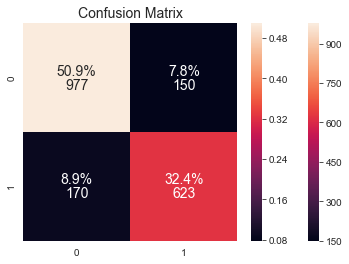

Train accuracy: 84.59%
Test accuracy: 83.33%
{'C': [0.5], 'class_weight': ['balanced'], 'gamma': ['auto'], 'kernel': ['rbf']}


In [60]:
# Tuning SVC (model 2) parameters for each possible kernel
# beginning with default 'rbf' kernel
svc = SVC(random_state=42)
svc_params1a = {'kernel':['rbf'],
                'C': np.linspace(.1, 1.9, 10),
                'class_weight': [None,'balanced'],
                'gamma': ['auto','scale']
               }
best_params_a, model2a = gridsearch_params(svc, svc_params1a, update_params=False)

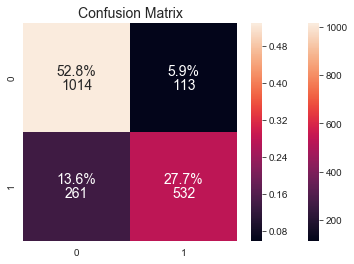

Train accuracy: 81.19%
Test accuracy: 80.52%
{'C': [25], 'class_weight': ['balanced'], 'gamma': ['scale'], 'kernel': ['poly']}


In [61]:
# Tuning SVC 'poly' kernel
svc = SVC(random_state=42)
svc_params1b = {'kernel':['poly'],
                'C': [.1, 1, 10, 25, 50, 75, 100],
                'class_weight': [None,'balanced'],
                'gamma': ['auto','scale']
               }
best_params_b, model2b = gridsearch_params(svc, svc_params1b, update_params=False)

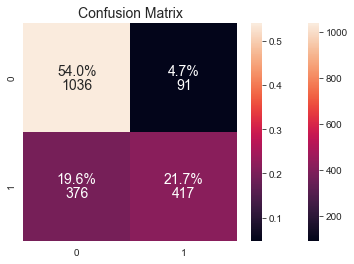

Train accuracy: 76.79%
Test accuracy: 75.68%
{'C': [0.3], 'class_weight': [None], 'kernel': ['linear']}


In [62]:
# Tuning SVC 'linear' kernel
svc = SVC(random_state=42)
svc_params1c = {'kernel':['linear'],
                'C': np.linspace(.1, 1.9, 10),
                'class_weight': [None,'balanced']
               }
best_params_c, model2c = gridsearch_params(svc, svc_params1c, update_params=False)

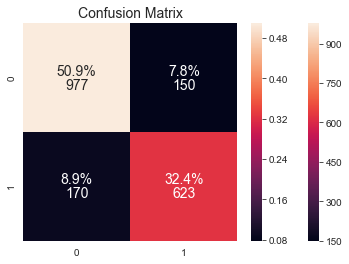

Train accuracy: 84.59%
Test accuracy: 83.33%
{'C': [0.5], 'class_weight': ['balanced'], 'gamma': ['auto'], 'kernel': ['rbf']}


In [63]:
# now pick the best kernel between the three versions above
svc = SVC(random_state=42, probability=True)
svc_params2 = [best_params_a, best_params_b, best_params_c]
best_params, model2 = gridsearch_params(svc, svc_params2, update_params=False)

In [64]:
# fitting model 2 to low-confidence values from model 1
model2.fit(x_low1, y_low1)
x_low2, y_low2, y_low2_preds, x_high2, y_high2, y_high2_preds = low_conf_preds(model2, x_low1, y_low1, .8)

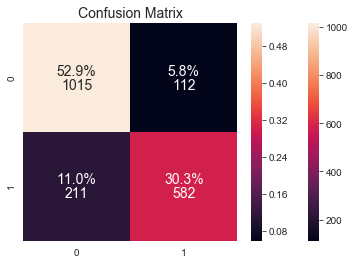

Train accuracy: 99.98%
Test accuracy: 83.17999999999999%
{'n_estimators': [90]}


In [65]:
# Testing RandomForestClassifier vanilla to see how it performs
rfc = RandomForestClassifier(random_state=42)
rfc_params = {'n_estimators': [i*10 for i in range(1,11)]}
best_params, model3 = gridsearch_params(rfc, rfc_params, update_params=False)

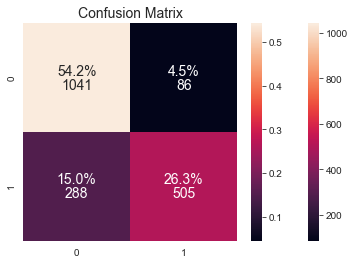

Train accuracy: 81.38%
Test accuracy: 80.52%
{'criterion': ['gini'], 'max_depth': [4], 'min_impurity_decrease': [0.001], 'min_samples_split': [4], 'n_estimators': [100]}


In [66]:
# Tuning RFC (model 3) parameters
rfc = RandomForestClassifier(random_state=42)
rfc_params = {'n_estimators': [i*10 for i in range(1,11)],
              'criterion': ['gini','entropy'],
              'max_depth': range(2,5),
              'min_samples_split': range(2,6),
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }
best_params, model3 = gridsearch_params(rfc, rfc_params, update_params=False)

In [70]:
# # Fitting model 3 to low-confidence observations from model 2
# model3.fit(x_low2, y_low2)
# x_low3, y_low3, y_low3_preds, x_high3, y_high3, y_high3_preds = low_conf_preds(model3, x_low2, y_low2, .8)

In [73]:
# comparing using SVC a second time
model2.fit(x_low2, y_low2)
x_low3, y_low3, y_low3_preds, x_high3, y_high3, y_high3_preds = low_conf_preds(model2, x_low2, y_low2, .8)

Train accuracy : 0.8466215042556887
Test accuracy : 0.8229166666666666


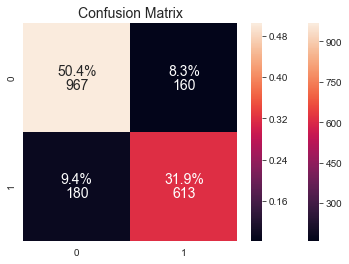

In [74]:
# re-building the training dataset
x_trnnn = x_high1.append(x_high2).append(x_low3).append(x_high3)
y_trnnn = y_high1.append(y_high2).append(y_low3).append(y_high3)
y_hat = y_high1_preds.append(y_high2_preds).append(y_low3_preds).append(y_high3_preds)

# Running models on testing data
x_low1t, y_low1t, y_low1_predst, x_high1t, y_high1t, y_high1_predst = low_conf_preds(model1, X_test, y_test, .8)
x_low2t, y_low2t, y_low2_predst, x_high2t, y_high2t, y_high2_predst = low_conf_preds(model2, x_low1t, y_low1t, .8)
x_low3t, y_low3t, y_low3_predst, x_high3t, y_high3t, y_high3_predst = low_conf_preds(model2, x_low2t, y_low2t, .8)

#re-building the testing dataset
x_tsttt = x_high1t.append(x_high2t).append(x_low3t).append(x_high3t)
y_tsttt = y_high1t.append(y_high2t).append(y_low3t).append(y_high3t)
y_hat_tst = y_high1_predst.append(y_high2_predst).append(y_low3_predst).append(y_high3_predst)

#output
print(f"Train accuracy : {accuracy_score(y_trnnn.sort_index().values, y_hat.sort_index())}")
print(f"Test accuracy : {accuracy_score(y_tsttt.sort_index().values, y_hat_tst.sort_index())}")
confu_matrix(y_hat_tst, x_tsttt, y_tsttt)

**Apparently this was *not* an improvement over previous solo methods.**

### Let's try model stacking instead

In [75]:
def Stacking(model, train, test, y, n_fold, xgb=False, eval_metric='error@.8'):
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)
    folds = StratifiedKFold(n_splits=n_fold, random_state=42)
    test_pred = np.empty((0,1), float)
    train_pred = np.empty((0,1), float)
    for train_indices, val_indices in folds.split(train, y.values):
        if xgb:
            x_tr, x_val = train.iloc[train_indices], train.iloc[val_indices]
            y_tr, y_val = y.iloc[train_indices], y.iloc[val_indices]
            model.fit(x_tr, y_tr, eval_metric='error@.8',
                      eval_set=[(x_val, y_val)])
            train_pred = np.append(train_pred, model.predict(x_val))
        else:
            x_tr, x_val = train.iloc[train_indices], train.iloc[val_indices]
            y_tr, y_val = y.iloc[train_indices], y.iloc[val_indices]
            model.fit(x_tr, y_tr)
            train_pred = np.append(train_pred, model.predict(x_val))
    test_pred = np.append(test_pred, model.predict(test))
    return test_pred, train_pred

In [76]:
#base model 1 (XGBoostClassifier)
model1 = xgb_gs2
test_pred1, train_pred1 = Stacking(model=model1, n_fold=10, train=X_train,
                                   test=X_test, y=y_train.koi_pdisposition,
                                   xgb=True)
train_pred1 = pd.DataFrame(train_pred1)
test_pred1 = pd.DataFrame(test_pred1)

[0]	validation_0-error@0.8:0.429809
[1]	validation_0-error@0.8:0.429809
[2]	validation_0-error@0.8:0.429809
[3]	validation_0-error@0.8:0.429809
[4]	validation_0-error@0.8:0.429809
[5]	validation_0-error@0.8:0.429809
[6]	validation_0-error@0.8:0.429809
[7]	validation_0-error@0.8:0.429809
[8]	validation_0-error@0.8:0.414211
[9]	validation_0-error@0.8:0.403813
[10]	validation_0-error@0.8:0.369151
[11]	validation_0-error@0.8:0.357019
[12]	validation_0-error@0.8:0.341421
[13]	validation_0-error@0.8:0.311958
[14]	validation_0-error@0.8:0.30156
[15]	validation_0-error@0.8:0.306759
[16]	validation_0-error@0.8:0.30156
[17]	validation_0-error@0.8:0.298094
[18]	validation_0-error@0.8:0.294627
[19]	validation_0-error@0.8:0.294627
[20]	validation_0-error@0.8:0.292894
[21]	validation_0-error@0.8:0.292894
[22]	validation_0-error@0.8:0.291161
[23]	validation_0-error@0.8:0.291161
[24]	validation_0-error@0.8:0.292894
[25]	validation_0-error@0.8:0.291161
[26]	validation_0-error@0.8:0.292894
[27]	validati

[219]	validation_0-error@0.8:0.216638
[220]	validation_0-error@0.8:0.216638
[221]	validation_0-error@0.8:0.216638
[222]	validation_0-error@0.8:0.216638
[223]	validation_0-error@0.8:0.214905
[224]	validation_0-error@0.8:0.214905
[225]	validation_0-error@0.8:0.216638
[226]	validation_0-error@0.8:0.211438
[227]	validation_0-error@0.8:0.211438
[228]	validation_0-error@0.8:0.211438
[229]	validation_0-error@0.8:0.211438
[230]	validation_0-error@0.8:0.209705
[231]	validation_0-error@0.8:0.211438
[232]	validation_0-error@0.8:0.209705
[233]	validation_0-error@0.8:0.209705
[234]	validation_0-error@0.8:0.211438
[235]	validation_0-error@0.8:0.211438
[236]	validation_0-error@0.8:0.211438
[237]	validation_0-error@0.8:0.211438
[238]	validation_0-error@0.8:0.214905
[239]	validation_0-error@0.8:0.213172
[240]	validation_0-error@0.8:0.213172
[241]	validation_0-error@0.8:0.213172
[242]	validation_0-error@0.8:0.214905
[243]	validation_0-error@0.8:0.211438
[244]	validation_0-error@0.8:0.213172
[245]	valida

[435]	validation_0-error@0.8:0.213172
[436]	validation_0-error@0.8:0.211438
[437]	validation_0-error@0.8:0.209705
[438]	validation_0-error@0.8:0.211438
[439]	validation_0-error@0.8:0.211438
[440]	validation_0-error@0.8:0.211438
[441]	validation_0-error@0.8:0.211438
[442]	validation_0-error@0.8:0.211438
[443]	validation_0-error@0.8:0.211438
[444]	validation_0-error@0.8:0.211438
[445]	validation_0-error@0.8:0.211438
[446]	validation_0-error@0.8:0.211438
[447]	validation_0-error@0.8:0.211438
[448]	validation_0-error@0.8:0.211438
[449]	validation_0-error@0.8:0.211438
[450]	validation_0-error@0.8:0.211438
[451]	validation_0-error@0.8:0.211438
[452]	validation_0-error@0.8:0.211438
[453]	validation_0-error@0.8:0.211438
[454]	validation_0-error@0.8:0.211438
[455]	validation_0-error@0.8:0.211438
[456]	validation_0-error@0.8:0.211438
[457]	validation_0-error@0.8:0.211438
[458]	validation_0-error@0.8:0.211438
[459]	validation_0-error@0.8:0.211438
[460]	validation_0-error@0.8:0.211438
[461]	valida

[651]	validation_0-error@0.8:0.202773
[652]	validation_0-error@0.8:0.202773
[653]	validation_0-error@0.8:0.202773
[654]	validation_0-error@0.8:0.202773
[655]	validation_0-error@0.8:0.202773
[656]	validation_0-error@0.8:0.202773
[657]	validation_0-error@0.8:0.202773
[658]	validation_0-error@0.8:0.202773
[659]	validation_0-error@0.8:0.202773
[660]	validation_0-error@0.8:0.202773
[661]	validation_0-error@0.8:0.202773
[662]	validation_0-error@0.8:0.202773
[663]	validation_0-error@0.8:0.202773
[664]	validation_0-error@0.8:0.202773
[665]	validation_0-error@0.8:0.202773
[666]	validation_0-error@0.8:0.202773
[667]	validation_0-error@0.8:0.202773
[668]	validation_0-error@0.8:0.202773
[669]	validation_0-error@0.8:0.20104
[670]	validation_0-error@0.8:0.20104
[671]	validation_0-error@0.8:0.202773
[672]	validation_0-error@0.8:0.202773
[673]	validation_0-error@0.8:0.202773
[674]	validation_0-error@0.8:0.202773
[675]	validation_0-error@0.8:0.202773
[676]	validation_0-error@0.8:0.202773
[677]	validati

[868]	validation_0-error@0.8:0.195841
[869]	validation_0-error@0.8:0.195841
[870]	validation_0-error@0.8:0.197574
[871]	validation_0-error@0.8:0.197574
[872]	validation_0-error@0.8:0.197574
[873]	validation_0-error@0.8:0.197574
[874]	validation_0-error@0.8:0.197574
[875]	validation_0-error@0.8:0.197574
[876]	validation_0-error@0.8:0.197574
[877]	validation_0-error@0.8:0.197574
[878]	validation_0-error@0.8:0.197574
[879]	validation_0-error@0.8:0.197574
[880]	validation_0-error@0.8:0.197574
[881]	validation_0-error@0.8:0.197574
[882]	validation_0-error@0.8:0.197574
[883]	validation_0-error@0.8:0.197574
[884]	validation_0-error@0.8:0.197574
[885]	validation_0-error@0.8:0.197574
[886]	validation_0-error@0.8:0.197574
[887]	validation_0-error@0.8:0.197574
[888]	validation_0-error@0.8:0.197574
[889]	validation_0-error@0.8:0.197574
[890]	validation_0-error@0.8:0.197574
[891]	validation_0-error@0.8:0.197574
[892]	validation_0-error@0.8:0.195841
[893]	validation_0-error@0.8:0.195841
[894]	valida

[87]	validation_0-error@0.8:0.233969
[88]	validation_0-error@0.8:0.228769
[89]	validation_0-error@0.8:0.228769
[90]	validation_0-error@0.8:0.230503
[91]	validation_0-error@0.8:0.228769
[92]	validation_0-error@0.8:0.232236
[93]	validation_0-error@0.8:0.230503
[94]	validation_0-error@0.8:0.233969
[95]	validation_0-error@0.8:0.233969
[96]	validation_0-error@0.8:0.237435
[97]	validation_0-error@0.8:0.233969
[98]	validation_0-error@0.8:0.232236
[99]	validation_0-error@0.8:0.232236
[100]	validation_0-error@0.8:0.232236
[101]	validation_0-error@0.8:0.232236
[102]	validation_0-error@0.8:0.230503
[103]	validation_0-error@0.8:0.230503
[104]	validation_0-error@0.8:0.228769
[105]	validation_0-error@0.8:0.227036
[106]	validation_0-error@0.8:0.227036
[107]	validation_0-error@0.8:0.228769
[108]	validation_0-error@0.8:0.227036
[109]	validation_0-error@0.8:0.225303
[110]	validation_0-error@0.8:0.225303
[111]	validation_0-error@0.8:0.227036
[112]	validation_0-error@0.8:0.227036
[113]	validation_0-error@

[304]	validation_0-error@0.8:0.199307
[305]	validation_0-error@0.8:0.199307
[306]	validation_0-error@0.8:0.199307
[307]	validation_0-error@0.8:0.199307
[308]	validation_0-error@0.8:0.199307
[309]	validation_0-error@0.8:0.197574
[310]	validation_0-error@0.8:0.197574
[311]	validation_0-error@0.8:0.197574
[312]	validation_0-error@0.8:0.197574
[313]	validation_0-error@0.8:0.197574
[314]	validation_0-error@0.8:0.197574
[315]	validation_0-error@0.8:0.197574
[316]	validation_0-error@0.8:0.197574
[317]	validation_0-error@0.8:0.197574
[318]	validation_0-error@0.8:0.197574
[319]	validation_0-error@0.8:0.197574
[320]	validation_0-error@0.8:0.197574
[321]	validation_0-error@0.8:0.197574
[322]	validation_0-error@0.8:0.197574
[323]	validation_0-error@0.8:0.197574
[324]	validation_0-error@0.8:0.197574
[325]	validation_0-error@0.8:0.197574
[326]	validation_0-error@0.8:0.197574
[327]	validation_0-error@0.8:0.197574
[328]	validation_0-error@0.8:0.197574
[329]	validation_0-error@0.8:0.197574
[330]	valida

[520]	validation_0-error@0.8:0.183709
[521]	validation_0-error@0.8:0.183709
[522]	validation_0-error@0.8:0.181976
[523]	validation_0-error@0.8:0.183709
[524]	validation_0-error@0.8:0.183709
[525]	validation_0-error@0.8:0.185442
[526]	validation_0-error@0.8:0.183709
[527]	validation_0-error@0.8:0.183709
[528]	validation_0-error@0.8:0.183709
[529]	validation_0-error@0.8:0.183709
[530]	validation_0-error@0.8:0.181976
[531]	validation_0-error@0.8:0.181976
[532]	validation_0-error@0.8:0.181976
[533]	validation_0-error@0.8:0.181976
[534]	validation_0-error@0.8:0.181976
[535]	validation_0-error@0.8:0.181976
[536]	validation_0-error@0.8:0.181976
[537]	validation_0-error@0.8:0.181976
[538]	validation_0-error@0.8:0.180243
[539]	validation_0-error@0.8:0.180243
[540]	validation_0-error@0.8:0.180243
[541]	validation_0-error@0.8:0.185442
[542]	validation_0-error@0.8:0.185442
[543]	validation_0-error@0.8:0.183709
[544]	validation_0-error@0.8:0.185442
[545]	validation_0-error@0.8:0.185442
[546]	valida

[738]	validation_0-error@0.8:0.175043
[739]	validation_0-error@0.8:0.175043
[740]	validation_0-error@0.8:0.175043
[741]	validation_0-error@0.8:0.175043
[742]	validation_0-error@0.8:0.175043
[743]	validation_0-error@0.8:0.175043
[744]	validation_0-error@0.8:0.175043
[745]	validation_0-error@0.8:0.175043
[746]	validation_0-error@0.8:0.175043
[747]	validation_0-error@0.8:0.175043
[748]	validation_0-error@0.8:0.175043
[749]	validation_0-error@0.8:0.175043
[750]	validation_0-error@0.8:0.175043
[751]	validation_0-error@0.8:0.175043
[752]	validation_0-error@0.8:0.175043
[753]	validation_0-error@0.8:0.175043
[754]	validation_0-error@0.8:0.175043
[755]	validation_0-error@0.8:0.175043
[756]	validation_0-error@0.8:0.175043
[757]	validation_0-error@0.8:0.175043
[758]	validation_0-error@0.8:0.176776
[759]	validation_0-error@0.8:0.175043
[760]	validation_0-error@0.8:0.175043
[761]	validation_0-error@0.8:0.176776
[762]	validation_0-error@0.8:0.176776
[763]	validation_0-error@0.8:0.176776
[764]	valida

[955]	validation_0-error@0.8:0.17851
[956]	validation_0-error@0.8:0.17851
[957]	validation_0-error@0.8:0.17851
[958]	validation_0-error@0.8:0.176776
[959]	validation_0-error@0.8:0.176776
[960]	validation_0-error@0.8:0.176776
[961]	validation_0-error@0.8:0.176776
[962]	validation_0-error@0.8:0.176776
[963]	validation_0-error@0.8:0.176776
[964]	validation_0-error@0.8:0.176776
[965]	validation_0-error@0.8:0.176776
[966]	validation_0-error@0.8:0.176776
[967]	validation_0-error@0.8:0.176776
[968]	validation_0-error@0.8:0.175043
[969]	validation_0-error@0.8:0.175043
[970]	validation_0-error@0.8:0.175043
[971]	validation_0-error@0.8:0.17331
[972]	validation_0-error@0.8:0.17331
[973]	validation_0-error@0.8:0.17331
[974]	validation_0-error@0.8:0.17331
[975]	validation_0-error@0.8:0.17331
[976]	validation_0-error@0.8:0.17331
[977]	validation_0-error@0.8:0.17331
[978]	validation_0-error@0.8:0.175043
[979]	validation_0-error@0.8:0.175043
[980]	validation_0-error@0.8:0.175043
[981]	validation_0-err

[175]	validation_0-error@0.8:0.206597
[176]	validation_0-error@0.8:0.206597
[177]	validation_0-error@0.8:0.206597
[178]	validation_0-error@0.8:0.208333
[179]	validation_0-error@0.8:0.206597
[180]	validation_0-error@0.8:0.210069
[181]	validation_0-error@0.8:0.210069
[182]	validation_0-error@0.8:0.206597
[183]	validation_0-error@0.8:0.204861
[184]	validation_0-error@0.8:0.199653
[185]	validation_0-error@0.8:0.201389
[186]	validation_0-error@0.8:0.204861
[187]	validation_0-error@0.8:0.204861
[188]	validation_0-error@0.8:0.206597
[189]	validation_0-error@0.8:0.208333
[190]	validation_0-error@0.8:0.211806
[191]	validation_0-error@0.8:0.210069
[192]	validation_0-error@0.8:0.210069
[193]	validation_0-error@0.8:0.211806
[194]	validation_0-error@0.8:0.211806
[195]	validation_0-error@0.8:0.210069
[196]	validation_0-error@0.8:0.210069
[197]	validation_0-error@0.8:0.206597
[198]	validation_0-error@0.8:0.206597
[199]	validation_0-error@0.8:0.206597
[200]	validation_0-error@0.8:0.206597
[201]	valida

[391]	validation_0-error@0.8:0.199653
[392]	validation_0-error@0.8:0.199653
[393]	validation_0-error@0.8:0.199653
[394]	validation_0-error@0.8:0.201389
[395]	validation_0-error@0.8:0.201389
[396]	validation_0-error@0.8:0.197917
[397]	validation_0-error@0.8:0.197917
[398]	validation_0-error@0.8:0.197917
[399]	validation_0-error@0.8:0.197917
[400]	validation_0-error@0.8:0.199653
[401]	validation_0-error@0.8:0.199653
[402]	validation_0-error@0.8:0.194444
[403]	validation_0-error@0.8:0.197917
[404]	validation_0-error@0.8:0.197917
[405]	validation_0-error@0.8:0.199653
[406]	validation_0-error@0.8:0.199653
[407]	validation_0-error@0.8:0.199653
[408]	validation_0-error@0.8:0.199653
[409]	validation_0-error@0.8:0.199653
[410]	validation_0-error@0.8:0.197917
[411]	validation_0-error@0.8:0.199653
[412]	validation_0-error@0.8:0.199653
[413]	validation_0-error@0.8:0.201389
[414]	validation_0-error@0.8:0.197917
[415]	validation_0-error@0.8:0.199653
[416]	validation_0-error@0.8:0.196181
[417]	valida

[607]	validation_0-error@0.8:0.192708
[608]	validation_0-error@0.8:0.192708
[609]	validation_0-error@0.8:0.192708
[610]	validation_0-error@0.8:0.192708
[611]	validation_0-error@0.8:0.192708
[612]	validation_0-error@0.8:0.192708
[613]	validation_0-error@0.8:0.194444
[614]	validation_0-error@0.8:0.194444
[615]	validation_0-error@0.8:0.194444
[616]	validation_0-error@0.8:0.192708
[617]	validation_0-error@0.8:0.192708
[618]	validation_0-error@0.8:0.192708
[619]	validation_0-error@0.8:0.194444
[620]	validation_0-error@0.8:0.194444
[621]	validation_0-error@0.8:0.192708
[622]	validation_0-error@0.8:0.192708
[623]	validation_0-error@0.8:0.192708
[624]	validation_0-error@0.8:0.194444
[625]	validation_0-error@0.8:0.192708
[626]	validation_0-error@0.8:0.192708
[627]	validation_0-error@0.8:0.192708
[628]	validation_0-error@0.8:0.194444
[629]	validation_0-error@0.8:0.196181
[630]	validation_0-error@0.8:0.190972
[631]	validation_0-error@0.8:0.192708
[632]	validation_0-error@0.8:0.196181
[633]	valida

[824]	validation_0-error@0.8:0.190972
[825]	validation_0-error@0.8:0.190972
[826]	validation_0-error@0.8:0.190972
[827]	validation_0-error@0.8:0.190972
[828]	validation_0-error@0.8:0.190972
[829]	validation_0-error@0.8:0.190972
[830]	validation_0-error@0.8:0.190972
[831]	validation_0-error@0.8:0.189236
[832]	validation_0-error@0.8:0.189236
[833]	validation_0-error@0.8:0.189236
[834]	validation_0-error@0.8:0.190972
[835]	validation_0-error@0.8:0.192708
[836]	validation_0-error@0.8:0.190972
[837]	validation_0-error@0.8:0.192708
[838]	validation_0-error@0.8:0.192708
[839]	validation_0-error@0.8:0.192708
[840]	validation_0-error@0.8:0.192708
[841]	validation_0-error@0.8:0.192708
[842]	validation_0-error@0.8:0.192708
[843]	validation_0-error@0.8:0.192708
[844]	validation_0-error@0.8:0.190972
[845]	validation_0-error@0.8:0.190972
[846]	validation_0-error@0.8:0.192708
[847]	validation_0-error@0.8:0.190972
[848]	validation_0-error@0.8:0.192708
[849]	validation_0-error@0.8:0.192708
[850]	valida

[44]	validation_0-error@0.8:0.248264
[45]	validation_0-error@0.8:0.246528
[46]	validation_0-error@0.8:0.244792
[47]	validation_0-error@0.8:0.241319
[48]	validation_0-error@0.8:0.241319
[49]	validation_0-error@0.8:0.241319
[50]	validation_0-error@0.8:0.239583
[51]	validation_0-error@0.8:0.234375
[52]	validation_0-error@0.8:0.237847
[53]	validation_0-error@0.8:0.236111
[54]	validation_0-error@0.8:0.232639
[55]	validation_0-error@0.8:0.229167
[56]	validation_0-error@0.8:0.229167
[57]	validation_0-error@0.8:0.229167
[58]	validation_0-error@0.8:0.225694
[59]	validation_0-error@0.8:0.225694
[60]	validation_0-error@0.8:0.225694
[61]	validation_0-error@0.8:0.223958
[62]	validation_0-error@0.8:0.222222
[63]	validation_0-error@0.8:0.223958
[64]	validation_0-error@0.8:0.217014
[65]	validation_0-error@0.8:0.217014
[66]	validation_0-error@0.8:0.217014
[67]	validation_0-error@0.8:0.21875
[68]	validation_0-error@0.8:0.21875
[69]	validation_0-error@0.8:0.21875
[70]	validation_0-error@0.8:0.21875
[71]	

[262]	validation_0-error@0.8:0.192708
[263]	validation_0-error@0.8:0.192708
[264]	validation_0-error@0.8:0.192708
[265]	validation_0-error@0.8:0.192708
[266]	validation_0-error@0.8:0.192708
[267]	validation_0-error@0.8:0.194444
[268]	validation_0-error@0.8:0.194444
[269]	validation_0-error@0.8:0.194444
[270]	validation_0-error@0.8:0.194444
[271]	validation_0-error@0.8:0.194444
[272]	validation_0-error@0.8:0.194444
[273]	validation_0-error@0.8:0.194444
[274]	validation_0-error@0.8:0.194444
[275]	validation_0-error@0.8:0.194444
[276]	validation_0-error@0.8:0.194444
[277]	validation_0-error@0.8:0.194444
[278]	validation_0-error@0.8:0.194444
[279]	validation_0-error@0.8:0.194444
[280]	validation_0-error@0.8:0.192708
[281]	validation_0-error@0.8:0.190972
[282]	validation_0-error@0.8:0.190972
[283]	validation_0-error@0.8:0.190972
[284]	validation_0-error@0.8:0.192708
[285]	validation_0-error@0.8:0.192708
[286]	validation_0-error@0.8:0.190972
[287]	validation_0-error@0.8:0.190972
[288]	valida

[479]	validation_0-error@0.8:0.185764
[480]	validation_0-error@0.8:0.1875
[481]	validation_0-error@0.8:0.185764
[482]	validation_0-error@0.8:0.1875
[483]	validation_0-error@0.8:0.1875
[484]	validation_0-error@0.8:0.185764
[485]	validation_0-error@0.8:0.185764
[486]	validation_0-error@0.8:0.185764
[487]	validation_0-error@0.8:0.185764
[488]	validation_0-error@0.8:0.185764
[489]	validation_0-error@0.8:0.185764
[490]	validation_0-error@0.8:0.185764
[491]	validation_0-error@0.8:0.185764
[492]	validation_0-error@0.8:0.185764
[493]	validation_0-error@0.8:0.185764
[494]	validation_0-error@0.8:0.185764
[495]	validation_0-error@0.8:0.184028
[496]	validation_0-error@0.8:0.185764
[497]	validation_0-error@0.8:0.185764
[498]	validation_0-error@0.8:0.185764
[499]	validation_0-error@0.8:0.185764
[500]	validation_0-error@0.8:0.185764
[501]	validation_0-error@0.8:0.185764
[502]	validation_0-error@0.8:0.185764
[503]	validation_0-error@0.8:0.185764
[504]	validation_0-error@0.8:0.185764
[505]	validation_0

[695]	validation_0-error@0.8:0.180556
[696]	validation_0-error@0.8:0.180556
[697]	validation_0-error@0.8:0.180556
[698]	validation_0-error@0.8:0.180556
[699]	validation_0-error@0.8:0.180556
[700]	validation_0-error@0.8:0.180556
[701]	validation_0-error@0.8:0.180556
[702]	validation_0-error@0.8:0.180556
[703]	validation_0-error@0.8:0.180556
[704]	validation_0-error@0.8:0.180556
[705]	validation_0-error@0.8:0.180556
[706]	validation_0-error@0.8:0.180556
[707]	validation_0-error@0.8:0.180556
[708]	validation_0-error@0.8:0.180556
[709]	validation_0-error@0.8:0.180556
[710]	validation_0-error@0.8:0.178819
[711]	validation_0-error@0.8:0.178819
[712]	validation_0-error@0.8:0.178819
[713]	validation_0-error@0.8:0.178819
[714]	validation_0-error@0.8:0.178819
[715]	validation_0-error@0.8:0.178819
[716]	validation_0-error@0.8:0.178819
[717]	validation_0-error@0.8:0.178819
[718]	validation_0-error@0.8:0.178819
[719]	validation_0-error@0.8:0.178819
[720]	validation_0-error@0.8:0.178819
[721]	valida

[911]	validation_0-error@0.8:0.178819
[912]	validation_0-error@0.8:0.178819
[913]	validation_0-error@0.8:0.178819
[914]	validation_0-error@0.8:0.178819
[915]	validation_0-error@0.8:0.178819
[916]	validation_0-error@0.8:0.178819
[917]	validation_0-error@0.8:0.178819
[918]	validation_0-error@0.8:0.178819
[919]	validation_0-error@0.8:0.178819
[920]	validation_0-error@0.8:0.178819
[921]	validation_0-error@0.8:0.178819
[922]	validation_0-error@0.8:0.178819
[923]	validation_0-error@0.8:0.180556
[924]	validation_0-error@0.8:0.180556
[925]	validation_0-error@0.8:0.180556
[926]	validation_0-error@0.8:0.180556
[927]	validation_0-error@0.8:0.180556
[928]	validation_0-error@0.8:0.180556
[929]	validation_0-error@0.8:0.180556
[930]	validation_0-error@0.8:0.180556
[931]	validation_0-error@0.8:0.182292
[932]	validation_0-error@0.8:0.180556
[933]	validation_0-error@0.8:0.180556
[934]	validation_0-error@0.8:0.180556
[935]	validation_0-error@0.8:0.180556
[936]	validation_0-error@0.8:0.180556
[937]	valida

[130]	validation_0-error@0.8:0.204861
[131]	validation_0-error@0.8:0.204861
[132]	validation_0-error@0.8:0.204861
[133]	validation_0-error@0.8:0.204861
[134]	validation_0-error@0.8:0.204861
[135]	validation_0-error@0.8:0.204861
[136]	validation_0-error@0.8:0.204861
[137]	validation_0-error@0.8:0.204861
[138]	validation_0-error@0.8:0.203125
[139]	validation_0-error@0.8:0.203125
[140]	validation_0-error@0.8:0.201389
[141]	validation_0-error@0.8:0.199653
[142]	validation_0-error@0.8:0.199653
[143]	validation_0-error@0.8:0.199653
[144]	validation_0-error@0.8:0.199653
[145]	validation_0-error@0.8:0.199653
[146]	validation_0-error@0.8:0.199653
[147]	validation_0-error@0.8:0.199653
[148]	validation_0-error@0.8:0.197917
[149]	validation_0-error@0.8:0.194444
[150]	validation_0-error@0.8:0.194444
[151]	validation_0-error@0.8:0.194444
[152]	validation_0-error@0.8:0.194444
[153]	validation_0-error@0.8:0.194444
[154]	validation_0-error@0.8:0.192708
[155]	validation_0-error@0.8:0.190972
[156]	valida

[348]	validation_0-error@0.8:0.178819
[349]	validation_0-error@0.8:0.178819
[350]	validation_0-error@0.8:0.180556
[351]	validation_0-error@0.8:0.180556
[352]	validation_0-error@0.8:0.180556
[353]	validation_0-error@0.8:0.180556
[354]	validation_0-error@0.8:0.180556
[355]	validation_0-error@0.8:0.180556
[356]	validation_0-error@0.8:0.180556
[357]	validation_0-error@0.8:0.180556
[358]	validation_0-error@0.8:0.180556
[359]	validation_0-error@0.8:0.180556
[360]	validation_0-error@0.8:0.178819
[361]	validation_0-error@0.8:0.177083
[362]	validation_0-error@0.8:0.177083
[363]	validation_0-error@0.8:0.177083
[364]	validation_0-error@0.8:0.177083
[365]	validation_0-error@0.8:0.178819
[366]	validation_0-error@0.8:0.178819
[367]	validation_0-error@0.8:0.178819
[368]	validation_0-error@0.8:0.178819
[369]	validation_0-error@0.8:0.178819
[370]	validation_0-error@0.8:0.180556
[371]	validation_0-error@0.8:0.184028
[372]	validation_0-error@0.8:0.184028
[373]	validation_0-error@0.8:0.182292
[374]	valida

[564]	validation_0-error@0.8:0.175347
[565]	validation_0-error@0.8:0.177083
[566]	validation_0-error@0.8:0.177083
[567]	validation_0-error@0.8:0.177083
[568]	validation_0-error@0.8:0.177083
[569]	validation_0-error@0.8:0.177083
[570]	validation_0-error@0.8:0.178819
[571]	validation_0-error@0.8:0.178819
[572]	validation_0-error@0.8:0.177083
[573]	validation_0-error@0.8:0.178819
[574]	validation_0-error@0.8:0.178819
[575]	validation_0-error@0.8:0.178819
[576]	validation_0-error@0.8:0.177083
[577]	validation_0-error@0.8:0.177083
[578]	validation_0-error@0.8:0.177083
[579]	validation_0-error@0.8:0.177083
[580]	validation_0-error@0.8:0.177083
[581]	validation_0-error@0.8:0.177083
[582]	validation_0-error@0.8:0.177083
[583]	validation_0-error@0.8:0.177083
[584]	validation_0-error@0.8:0.175347
[585]	validation_0-error@0.8:0.175347
[586]	validation_0-error@0.8:0.177083
[587]	validation_0-error@0.8:0.177083
[588]	validation_0-error@0.8:0.177083
[589]	validation_0-error@0.8:0.177083
[590]	valida

[780]	validation_0-error@0.8:0.184028
[781]	validation_0-error@0.8:0.184028
[782]	validation_0-error@0.8:0.182292
[783]	validation_0-error@0.8:0.182292
[784]	validation_0-error@0.8:0.182292
[785]	validation_0-error@0.8:0.180556
[786]	validation_0-error@0.8:0.180556
[787]	validation_0-error@0.8:0.182292
[788]	validation_0-error@0.8:0.184028
[789]	validation_0-error@0.8:0.184028
[790]	validation_0-error@0.8:0.182292
[791]	validation_0-error@0.8:0.182292
[792]	validation_0-error@0.8:0.182292
[793]	validation_0-error@0.8:0.182292
[794]	validation_0-error@0.8:0.180556
[795]	validation_0-error@0.8:0.180556
[796]	validation_0-error@0.8:0.178819
[797]	validation_0-error@0.8:0.178819
[798]	validation_0-error@0.8:0.178819
[799]	validation_0-error@0.8:0.177083
[800]	validation_0-error@0.8:0.178819
[801]	validation_0-error@0.8:0.178819
[802]	validation_0-error@0.8:0.178819
[803]	validation_0-error@0.8:0.177083
[804]	validation_0-error@0.8:0.178819
[805]	validation_0-error@0.8:0.178819
[806]	valida

[996]	validation_0-error@0.8:0.177083
[997]	validation_0-error@0.8:0.178819
[998]	validation_0-error@0.8:0.180556
[999]	validation_0-error@0.8:0.180556
[0]	validation_0-error@0.8:0.429565
[1]	validation_0-error@0.8:0.429565
[2]	validation_0-error@0.8:0.429565
[3]	validation_0-error@0.8:0.429565
[4]	validation_0-error@0.8:0.429565
[5]	validation_0-error@0.8:0.429565
[6]	validation_0-error@0.8:0.429565
[7]	validation_0-error@0.8:0.429565
[8]	validation_0-error@0.8:0.429565
[9]	validation_0-error@0.8:0.391304
[10]	validation_0-error@0.8:0.363478
[11]	validation_0-error@0.8:0.335652
[12]	validation_0-error@0.8:0.325217
[13]	validation_0-error@0.8:0.321739
[14]	validation_0-error@0.8:0.313043
[15]	validation_0-error@0.8:0.309565
[16]	validation_0-error@0.8:0.306087
[17]	validation_0-error@0.8:0.297391
[18]	validation_0-error@0.8:0.297391
[19]	validation_0-error@0.8:0.292174
[20]	validation_0-error@0.8:0.286957
[21]	validation_0-error@0.8:0.286957
[22]	validation_0-error@0.8:0.283478
[23]	va

[216]	validation_0-error@0.8:0.212174
[217]	validation_0-error@0.8:0.212174
[218]	validation_0-error@0.8:0.212174
[219]	validation_0-error@0.8:0.212174
[220]	validation_0-error@0.8:0.212174
[221]	validation_0-error@0.8:0.210435
[222]	validation_0-error@0.8:0.210435
[223]	validation_0-error@0.8:0.212174
[224]	validation_0-error@0.8:0.212174
[225]	validation_0-error@0.8:0.212174
[226]	validation_0-error@0.8:0.212174
[227]	validation_0-error@0.8:0.212174
[228]	validation_0-error@0.8:0.212174
[229]	validation_0-error@0.8:0.210435
[230]	validation_0-error@0.8:0.212174
[231]	validation_0-error@0.8:0.212174
[232]	validation_0-error@0.8:0.212174
[233]	validation_0-error@0.8:0.210435
[234]	validation_0-error@0.8:0.210435
[235]	validation_0-error@0.8:0.208696
[236]	validation_0-error@0.8:0.208696
[237]	validation_0-error@0.8:0.208696
[238]	validation_0-error@0.8:0.206957
[239]	validation_0-error@0.8:0.206957
[240]	validation_0-error@0.8:0.206957
[241]	validation_0-error@0.8:0.206957
[242]	valida

[434]	validation_0-error@0.8:0.198261
[435]	validation_0-error@0.8:0.198261
[436]	validation_0-error@0.8:0.198261
[437]	validation_0-error@0.8:0.198261
[438]	validation_0-error@0.8:0.198261
[439]	validation_0-error@0.8:0.198261
[440]	validation_0-error@0.8:0.198261
[441]	validation_0-error@0.8:0.198261
[442]	validation_0-error@0.8:0.198261
[443]	validation_0-error@0.8:0.198261
[444]	validation_0-error@0.8:0.198261
[445]	validation_0-error@0.8:0.198261
[446]	validation_0-error@0.8:0.2
[447]	validation_0-error@0.8:0.2
[448]	validation_0-error@0.8:0.2
[449]	validation_0-error@0.8:0.2
[450]	validation_0-error@0.8:0.2
[451]	validation_0-error@0.8:0.2
[452]	validation_0-error@0.8:0.2
[453]	validation_0-error@0.8:0.2
[454]	validation_0-error@0.8:0.2
[455]	validation_0-error@0.8:0.201739
[456]	validation_0-error@0.8:0.2
[457]	validation_0-error@0.8:0.2
[458]	validation_0-error@0.8:0.198261
[459]	validation_0-error@0.8:0.198261
[460]	validation_0-error@0.8:0.198261
[461]	validation_0-error@0.8:

[653]	validation_0-error@0.8:0.2
[654]	validation_0-error@0.8:0.2
[655]	validation_0-error@0.8:0.2
[656]	validation_0-error@0.8:0.2
[657]	validation_0-error@0.8:0.2
[658]	validation_0-error@0.8:0.198261
[659]	validation_0-error@0.8:0.198261
[660]	validation_0-error@0.8:0.198261
[661]	validation_0-error@0.8:0.198261
[662]	validation_0-error@0.8:0.196522
[663]	validation_0-error@0.8:0.198261
[664]	validation_0-error@0.8:0.198261
[665]	validation_0-error@0.8:0.198261
[666]	validation_0-error@0.8:0.198261
[667]	validation_0-error@0.8:0.198261
[668]	validation_0-error@0.8:0.198261
[669]	validation_0-error@0.8:0.198261
[670]	validation_0-error@0.8:0.198261
[671]	validation_0-error@0.8:0.198261
[672]	validation_0-error@0.8:0.2
[673]	validation_0-error@0.8:0.2
[674]	validation_0-error@0.8:0.2
[675]	validation_0-error@0.8:0.2
[676]	validation_0-error@0.8:0.2
[677]	validation_0-error@0.8:0.2
[678]	validation_0-error@0.8:0.2
[679]	validation_0-error@0.8:0.2
[680]	validation_0-error@0.8:0.198261
[

[871]	validation_0-error@0.8:0.191304
[872]	validation_0-error@0.8:0.191304
[873]	validation_0-error@0.8:0.191304
[874]	validation_0-error@0.8:0.191304
[875]	validation_0-error@0.8:0.189565
[876]	validation_0-error@0.8:0.189565
[877]	validation_0-error@0.8:0.187826
[878]	validation_0-error@0.8:0.189565
[879]	validation_0-error@0.8:0.191304
[880]	validation_0-error@0.8:0.191304
[881]	validation_0-error@0.8:0.191304
[882]	validation_0-error@0.8:0.191304
[883]	validation_0-error@0.8:0.189565
[884]	validation_0-error@0.8:0.191304
[885]	validation_0-error@0.8:0.191304
[886]	validation_0-error@0.8:0.191304
[887]	validation_0-error@0.8:0.191304
[888]	validation_0-error@0.8:0.191304
[889]	validation_0-error@0.8:0.193043
[890]	validation_0-error@0.8:0.193043
[891]	validation_0-error@0.8:0.193043
[892]	validation_0-error@0.8:0.193043
[893]	validation_0-error@0.8:0.193043
[894]	validation_0-error@0.8:0.191304
[895]	validation_0-error@0.8:0.191304
[896]	validation_0-error@0.8:0.191304
[897]	valida

[92]	validation_0-error@0.8:0.196522
[93]	validation_0-error@0.8:0.196522
[94]	validation_0-error@0.8:0.193043
[95]	validation_0-error@0.8:0.191304
[96]	validation_0-error@0.8:0.189565
[97]	validation_0-error@0.8:0.189565
[98]	validation_0-error@0.8:0.189565
[99]	validation_0-error@0.8:0.189565
[100]	validation_0-error@0.8:0.189565
[101]	validation_0-error@0.8:0.189565
[102]	validation_0-error@0.8:0.186087
[103]	validation_0-error@0.8:0.186087
[104]	validation_0-error@0.8:0.186087
[105]	validation_0-error@0.8:0.186087
[106]	validation_0-error@0.8:0.186087
[107]	validation_0-error@0.8:0.189565
[108]	validation_0-error@0.8:0.187826
[109]	validation_0-error@0.8:0.187826
[110]	validation_0-error@0.8:0.187826
[111]	validation_0-error@0.8:0.189565
[112]	validation_0-error@0.8:0.189565
[113]	validation_0-error@0.8:0.186087
[114]	validation_0-error@0.8:0.187826
[115]	validation_0-error@0.8:0.187826
[116]	validation_0-error@0.8:0.186087
[117]	validation_0-error@0.8:0.186087
[118]	validation_0-e

[310]	validation_0-error@0.8:0.17913
[311]	validation_0-error@0.8:0.17913
[312]	validation_0-error@0.8:0.182609
[313]	validation_0-error@0.8:0.18087
[314]	validation_0-error@0.8:0.18087
[315]	validation_0-error@0.8:0.18087
[316]	validation_0-error@0.8:0.18087
[317]	validation_0-error@0.8:0.18087
[318]	validation_0-error@0.8:0.18087
[319]	validation_0-error@0.8:0.18087
[320]	validation_0-error@0.8:0.18087
[321]	validation_0-error@0.8:0.17913
[322]	validation_0-error@0.8:0.18087
[323]	validation_0-error@0.8:0.182609
[324]	validation_0-error@0.8:0.17913
[325]	validation_0-error@0.8:0.17913
[326]	validation_0-error@0.8:0.177391
[327]	validation_0-error@0.8:0.17913
[328]	validation_0-error@0.8:0.175652
[329]	validation_0-error@0.8:0.175652
[330]	validation_0-error@0.8:0.175652
[331]	validation_0-error@0.8:0.177391
[332]	validation_0-error@0.8:0.17913
[333]	validation_0-error@0.8:0.17913
[334]	validation_0-error@0.8:0.17913
[335]	validation_0-error@0.8:0.17913
[336]	validation_0-error@0.8:0.

[529]	validation_0-error@0.8:0.175652
[530]	validation_0-error@0.8:0.175652
[531]	validation_0-error@0.8:0.173913
[532]	validation_0-error@0.8:0.173913
[533]	validation_0-error@0.8:0.173913
[534]	validation_0-error@0.8:0.173913
[535]	validation_0-error@0.8:0.173913
[536]	validation_0-error@0.8:0.173913
[537]	validation_0-error@0.8:0.173913
[538]	validation_0-error@0.8:0.173913
[539]	validation_0-error@0.8:0.173913
[540]	validation_0-error@0.8:0.175652
[541]	validation_0-error@0.8:0.175652
[542]	validation_0-error@0.8:0.173913
[543]	validation_0-error@0.8:0.175652
[544]	validation_0-error@0.8:0.175652
[545]	validation_0-error@0.8:0.175652
[546]	validation_0-error@0.8:0.177391
[547]	validation_0-error@0.8:0.177391
[548]	validation_0-error@0.8:0.175652
[549]	validation_0-error@0.8:0.175652
[550]	validation_0-error@0.8:0.175652
[551]	validation_0-error@0.8:0.175652
[552]	validation_0-error@0.8:0.175652
[553]	validation_0-error@0.8:0.172174
[554]	validation_0-error@0.8:0.172174
[555]	valida

[745]	validation_0-error@0.8:0.170435
[746]	validation_0-error@0.8:0.170435
[747]	validation_0-error@0.8:0.170435
[748]	validation_0-error@0.8:0.170435
[749]	validation_0-error@0.8:0.170435
[750]	validation_0-error@0.8:0.170435
[751]	validation_0-error@0.8:0.170435
[752]	validation_0-error@0.8:0.170435
[753]	validation_0-error@0.8:0.170435
[754]	validation_0-error@0.8:0.170435
[755]	validation_0-error@0.8:0.170435
[756]	validation_0-error@0.8:0.170435
[757]	validation_0-error@0.8:0.170435
[758]	validation_0-error@0.8:0.172174
[759]	validation_0-error@0.8:0.170435
[760]	validation_0-error@0.8:0.170435
[761]	validation_0-error@0.8:0.172174
[762]	validation_0-error@0.8:0.168696
[763]	validation_0-error@0.8:0.168696
[764]	validation_0-error@0.8:0.168696
[765]	validation_0-error@0.8:0.168696
[766]	validation_0-error@0.8:0.168696
[767]	validation_0-error@0.8:0.168696
[768]	validation_0-error@0.8:0.168696
[769]	validation_0-error@0.8:0.168696
[770]	validation_0-error@0.8:0.168696
[771]	valida

[962]	validation_0-error@0.8:0.16
[963]	validation_0-error@0.8:0.16
[964]	validation_0-error@0.8:0.16
[965]	validation_0-error@0.8:0.16
[966]	validation_0-error@0.8:0.16
[967]	validation_0-error@0.8:0.16
[968]	validation_0-error@0.8:0.16
[969]	validation_0-error@0.8:0.16
[970]	validation_0-error@0.8:0.16
[971]	validation_0-error@0.8:0.16
[972]	validation_0-error@0.8:0.16
[973]	validation_0-error@0.8:0.16
[974]	validation_0-error@0.8:0.16
[975]	validation_0-error@0.8:0.16
[976]	validation_0-error@0.8:0.16
[977]	validation_0-error@0.8:0.16
[978]	validation_0-error@0.8:0.16
[979]	validation_0-error@0.8:0.16
[980]	validation_0-error@0.8:0.16
[981]	validation_0-error@0.8:0.16
[982]	validation_0-error@0.8:0.16
[983]	validation_0-error@0.8:0.16
[984]	validation_0-error@0.8:0.16
[985]	validation_0-error@0.8:0.16
[986]	validation_0-error@0.8:0.16
[987]	validation_0-error@0.8:0.16
[988]	validation_0-error@0.8:0.16
[989]	validation_0-error@0.8:0.16
[990]	validation_0-error@0.8:0.16
[991]	validati

[185]	validation_0-error@0.8:0.182609
[186]	validation_0-error@0.8:0.182609
[187]	validation_0-error@0.8:0.18087
[188]	validation_0-error@0.8:0.18087
[189]	validation_0-error@0.8:0.18087
[190]	validation_0-error@0.8:0.18087
[191]	validation_0-error@0.8:0.18087
[192]	validation_0-error@0.8:0.18087
[193]	validation_0-error@0.8:0.18087
[194]	validation_0-error@0.8:0.18087
[195]	validation_0-error@0.8:0.18087
[196]	validation_0-error@0.8:0.18087
[197]	validation_0-error@0.8:0.18087
[198]	validation_0-error@0.8:0.18087
[199]	validation_0-error@0.8:0.18087
[200]	validation_0-error@0.8:0.177391
[201]	validation_0-error@0.8:0.177391
[202]	validation_0-error@0.8:0.177391
[203]	validation_0-error@0.8:0.177391
[204]	validation_0-error@0.8:0.177391
[205]	validation_0-error@0.8:0.177391
[206]	validation_0-error@0.8:0.17913
[207]	validation_0-error@0.8:0.177391
[208]	validation_0-error@0.8:0.177391
[209]	validation_0-error@0.8:0.175652
[210]	validation_0-error@0.8:0.175652
[211]	validation_0-error@0

[401]	validation_0-error@0.8:0.172174
[402]	validation_0-error@0.8:0.170435
[403]	validation_0-error@0.8:0.168696
[404]	validation_0-error@0.8:0.168696
[405]	validation_0-error@0.8:0.166957
[406]	validation_0-error@0.8:0.166957
[407]	validation_0-error@0.8:0.166957
[408]	validation_0-error@0.8:0.168696
[409]	validation_0-error@0.8:0.166957
[410]	validation_0-error@0.8:0.166957
[411]	validation_0-error@0.8:0.166957
[412]	validation_0-error@0.8:0.166957
[413]	validation_0-error@0.8:0.166957
[414]	validation_0-error@0.8:0.166957
[415]	validation_0-error@0.8:0.166957
[416]	validation_0-error@0.8:0.166957
[417]	validation_0-error@0.8:0.166957
[418]	validation_0-error@0.8:0.166957
[419]	validation_0-error@0.8:0.166957
[420]	validation_0-error@0.8:0.165217
[421]	validation_0-error@0.8:0.166957
[422]	validation_0-error@0.8:0.165217
[423]	validation_0-error@0.8:0.165217
[424]	validation_0-error@0.8:0.165217
[425]	validation_0-error@0.8:0.165217
[426]	validation_0-error@0.8:0.165217
[427]	valida

[617]	validation_0-error@0.8:0.16
[618]	validation_0-error@0.8:0.161739
[619]	validation_0-error@0.8:0.161739
[620]	validation_0-error@0.8:0.161739
[621]	validation_0-error@0.8:0.161739
[622]	validation_0-error@0.8:0.161739
[623]	validation_0-error@0.8:0.161739
[624]	validation_0-error@0.8:0.161739
[625]	validation_0-error@0.8:0.161739
[626]	validation_0-error@0.8:0.161739
[627]	validation_0-error@0.8:0.161739
[628]	validation_0-error@0.8:0.161739
[629]	validation_0-error@0.8:0.161739
[630]	validation_0-error@0.8:0.163478
[631]	validation_0-error@0.8:0.163478
[632]	validation_0-error@0.8:0.163478
[633]	validation_0-error@0.8:0.163478
[634]	validation_0-error@0.8:0.161739
[635]	validation_0-error@0.8:0.163478
[636]	validation_0-error@0.8:0.16
[637]	validation_0-error@0.8:0.16
[638]	validation_0-error@0.8:0.16
[639]	validation_0-error@0.8:0.161739
[640]	validation_0-error@0.8:0.161739
[641]	validation_0-error@0.8:0.16
[642]	validation_0-error@0.8:0.16
[643]	validation_0-error@0.8:0.16173

[837]	validation_0-error@0.8:0.16
[838]	validation_0-error@0.8:0.16
[839]	validation_0-error@0.8:0.16
[840]	validation_0-error@0.8:0.16
[841]	validation_0-error@0.8:0.16
[842]	validation_0-error@0.8:0.16
[843]	validation_0-error@0.8:0.16
[844]	validation_0-error@0.8:0.158261
[845]	validation_0-error@0.8:0.158261
[846]	validation_0-error@0.8:0.158261
[847]	validation_0-error@0.8:0.158261
[848]	validation_0-error@0.8:0.158261
[849]	validation_0-error@0.8:0.16
[850]	validation_0-error@0.8:0.16
[851]	validation_0-error@0.8:0.158261
[852]	validation_0-error@0.8:0.158261
[853]	validation_0-error@0.8:0.158261
[854]	validation_0-error@0.8:0.158261
[855]	validation_0-error@0.8:0.158261
[856]	validation_0-error@0.8:0.16
[857]	validation_0-error@0.8:0.16
[858]	validation_0-error@0.8:0.16
[859]	validation_0-error@0.8:0.16
[860]	validation_0-error@0.8:0.16
[861]	validation_0-error@0.8:0.16
[862]	validation_0-error@0.8:0.16
[863]	validation_0-error@0.8:0.16
[864]	validation_0-error@0.8:0.16
[865]	va

[58]	validation_0-error@0.8:0.233043
[59]	validation_0-error@0.8:0.231304
[60]	validation_0-error@0.8:0.233043
[61]	validation_0-error@0.8:0.233043
[62]	validation_0-error@0.8:0.233043
[63]	validation_0-error@0.8:0.231304
[64]	validation_0-error@0.8:0.231304
[65]	validation_0-error@0.8:0.231304
[66]	validation_0-error@0.8:0.231304
[67]	validation_0-error@0.8:0.231304
[68]	validation_0-error@0.8:0.229565
[69]	validation_0-error@0.8:0.229565
[70]	validation_0-error@0.8:0.231304
[71]	validation_0-error@0.8:0.231304
[72]	validation_0-error@0.8:0.229565
[73]	validation_0-error@0.8:0.229565
[74]	validation_0-error@0.8:0.226087
[75]	validation_0-error@0.8:0.227826
[76]	validation_0-error@0.8:0.226087
[77]	validation_0-error@0.8:0.226087
[78]	validation_0-error@0.8:0.226087
[79]	validation_0-error@0.8:0.222609
[80]	validation_0-error@0.8:0.226087
[81]	validation_0-error@0.8:0.227826
[82]	validation_0-error@0.8:0.227826
[83]	validation_0-error@0.8:0.222609
[84]	validation_0-error@0.8:0.222609
[

[276]	validation_0-error@0.8:0.205217
[277]	validation_0-error@0.8:0.203478
[278]	validation_0-error@0.8:0.203478
[279]	validation_0-error@0.8:0.203478
[280]	validation_0-error@0.8:0.203478
[281]	validation_0-error@0.8:0.201739
[282]	validation_0-error@0.8:0.201739
[283]	validation_0-error@0.8:0.201739
[284]	validation_0-error@0.8:0.201739
[285]	validation_0-error@0.8:0.203478
[286]	validation_0-error@0.8:0.203478
[287]	validation_0-error@0.8:0.205217
[288]	validation_0-error@0.8:0.205217
[289]	validation_0-error@0.8:0.205217
[290]	validation_0-error@0.8:0.205217
[291]	validation_0-error@0.8:0.205217
[292]	validation_0-error@0.8:0.205217
[293]	validation_0-error@0.8:0.205217
[294]	validation_0-error@0.8:0.205217
[295]	validation_0-error@0.8:0.203478
[296]	validation_0-error@0.8:0.206957
[297]	validation_0-error@0.8:0.206957
[298]	validation_0-error@0.8:0.206957
[299]	validation_0-error@0.8:0.205217
[300]	validation_0-error@0.8:0.206957
[301]	validation_0-error@0.8:0.206957
[302]	valida

[495]	validation_0-error@0.8:0.2
[496]	validation_0-error@0.8:0.2
[497]	validation_0-error@0.8:0.2
[498]	validation_0-error@0.8:0.201739
[499]	validation_0-error@0.8:0.201739
[500]	validation_0-error@0.8:0.2
[501]	validation_0-error@0.8:0.198261
[502]	validation_0-error@0.8:0.198261
[503]	validation_0-error@0.8:0.198261
[504]	validation_0-error@0.8:0.198261
[505]	validation_0-error@0.8:0.2
[506]	validation_0-error@0.8:0.2
[507]	validation_0-error@0.8:0.2
[508]	validation_0-error@0.8:0.2
[509]	validation_0-error@0.8:0.2
[510]	validation_0-error@0.8:0.2
[511]	validation_0-error@0.8:0.2
[512]	validation_0-error@0.8:0.2
[513]	validation_0-error@0.8:0.2
[514]	validation_0-error@0.8:0.2
[515]	validation_0-error@0.8:0.198261
[516]	validation_0-error@0.8:0.198261
[517]	validation_0-error@0.8:0.2
[518]	validation_0-error@0.8:0.198261
[519]	validation_0-error@0.8:0.198261
[520]	validation_0-error@0.8:0.198261
[521]	validation_0-error@0.8:0.198261
[522]	validation_0-error@0.8:0.198261
[523]	valid

[720]	validation_0-error@0.8:0.196522
[721]	validation_0-error@0.8:0.196522
[722]	validation_0-error@0.8:0.196522
[723]	validation_0-error@0.8:0.194783
[724]	validation_0-error@0.8:0.194783
[725]	validation_0-error@0.8:0.194783
[726]	validation_0-error@0.8:0.196522
[727]	validation_0-error@0.8:0.196522
[728]	validation_0-error@0.8:0.196522
[729]	validation_0-error@0.8:0.196522
[730]	validation_0-error@0.8:0.196522
[731]	validation_0-error@0.8:0.196522
[732]	validation_0-error@0.8:0.196522
[733]	validation_0-error@0.8:0.196522
[734]	validation_0-error@0.8:0.194783
[735]	validation_0-error@0.8:0.196522
[736]	validation_0-error@0.8:0.196522
[737]	validation_0-error@0.8:0.196522
[738]	validation_0-error@0.8:0.196522
[739]	validation_0-error@0.8:0.196522
[740]	validation_0-error@0.8:0.196522
[741]	validation_0-error@0.8:0.196522
[742]	validation_0-error@0.8:0.194783
[743]	validation_0-error@0.8:0.196522
[744]	validation_0-error@0.8:0.196522
[745]	validation_0-error@0.8:0.196522
[746]	valida

[946]	validation_0-error@0.8:0.201739
[947]	validation_0-error@0.8:0.201739
[948]	validation_0-error@0.8:0.201739
[949]	validation_0-error@0.8:0.201739
[950]	validation_0-error@0.8:0.201739
[951]	validation_0-error@0.8:0.201739
[952]	validation_0-error@0.8:0.201739
[953]	validation_0-error@0.8:0.2
[954]	validation_0-error@0.8:0.2
[955]	validation_0-error@0.8:0.2
[956]	validation_0-error@0.8:0.2
[957]	validation_0-error@0.8:0.201739
[958]	validation_0-error@0.8:0.201739
[959]	validation_0-error@0.8:0.201739
[960]	validation_0-error@0.8:0.201739
[961]	validation_0-error@0.8:0.201739
[962]	validation_0-error@0.8:0.201739
[963]	validation_0-error@0.8:0.201739
[964]	validation_0-error@0.8:0.2
[965]	validation_0-error@0.8:0.198261
[966]	validation_0-error@0.8:0.198261
[967]	validation_0-error@0.8:0.198261
[968]	validation_0-error@0.8:0.198261
[969]	validation_0-error@0.8:0.2
[970]	validation_0-error@0.8:0.2
[971]	validation_0-error@0.8:0.2
[972]	validation_0-error@0.8:0.2
[973]	validation_0-

[169]	validation_0-error@0.8:0.246957
[170]	validation_0-error@0.8:0.245217
[171]	validation_0-error@0.8:0.243478
[172]	validation_0-error@0.8:0.241739
[173]	validation_0-error@0.8:0.245217
[174]	validation_0-error@0.8:0.241739
[175]	validation_0-error@0.8:0.241739
[176]	validation_0-error@0.8:0.241739
[177]	validation_0-error@0.8:0.245217
[178]	validation_0-error@0.8:0.243478
[179]	validation_0-error@0.8:0.245217
[180]	validation_0-error@0.8:0.245217
[181]	validation_0-error@0.8:0.243478
[182]	validation_0-error@0.8:0.243478
[183]	validation_0-error@0.8:0.243478
[184]	validation_0-error@0.8:0.243478
[185]	validation_0-error@0.8:0.245217
[186]	validation_0-error@0.8:0.246957
[187]	validation_0-error@0.8:0.245217
[188]	validation_0-error@0.8:0.245217
[189]	validation_0-error@0.8:0.245217
[190]	validation_0-error@0.8:0.245217
[191]	validation_0-error@0.8:0.245217
[192]	validation_0-error@0.8:0.243478
[193]	validation_0-error@0.8:0.243478
[194]	validation_0-error@0.8:0.243478
[195]	valida

[387]	validation_0-error@0.8:0.229565
[388]	validation_0-error@0.8:0.227826
[389]	validation_0-error@0.8:0.229565
[390]	validation_0-error@0.8:0.229565
[391]	validation_0-error@0.8:0.231304
[392]	validation_0-error@0.8:0.231304
[393]	validation_0-error@0.8:0.231304
[394]	validation_0-error@0.8:0.231304
[395]	validation_0-error@0.8:0.231304
[396]	validation_0-error@0.8:0.231304
[397]	validation_0-error@0.8:0.231304
[398]	validation_0-error@0.8:0.231304
[399]	validation_0-error@0.8:0.231304
[400]	validation_0-error@0.8:0.231304
[401]	validation_0-error@0.8:0.229565
[402]	validation_0-error@0.8:0.229565
[403]	validation_0-error@0.8:0.229565
[404]	validation_0-error@0.8:0.229565
[405]	validation_0-error@0.8:0.229565
[406]	validation_0-error@0.8:0.229565
[407]	validation_0-error@0.8:0.229565
[408]	validation_0-error@0.8:0.229565
[409]	validation_0-error@0.8:0.229565
[410]	validation_0-error@0.8:0.229565
[411]	validation_0-error@0.8:0.229565
[412]	validation_0-error@0.8:0.229565
[413]	valida

[603]	validation_0-error@0.8:0.231304
[604]	validation_0-error@0.8:0.231304
[605]	validation_0-error@0.8:0.231304
[606]	validation_0-error@0.8:0.231304
[607]	validation_0-error@0.8:0.231304
[608]	validation_0-error@0.8:0.229565
[609]	validation_0-error@0.8:0.229565
[610]	validation_0-error@0.8:0.231304
[611]	validation_0-error@0.8:0.231304
[612]	validation_0-error@0.8:0.231304
[613]	validation_0-error@0.8:0.229565
[614]	validation_0-error@0.8:0.229565
[615]	validation_0-error@0.8:0.229565
[616]	validation_0-error@0.8:0.229565
[617]	validation_0-error@0.8:0.229565
[618]	validation_0-error@0.8:0.229565
[619]	validation_0-error@0.8:0.229565
[620]	validation_0-error@0.8:0.229565
[621]	validation_0-error@0.8:0.229565
[622]	validation_0-error@0.8:0.229565
[623]	validation_0-error@0.8:0.229565
[624]	validation_0-error@0.8:0.229565
[625]	validation_0-error@0.8:0.229565
[626]	validation_0-error@0.8:0.229565
[627]	validation_0-error@0.8:0.227826
[628]	validation_0-error@0.8:0.227826
[629]	valida

[819]	validation_0-error@0.8:0.227826
[820]	validation_0-error@0.8:0.226087
[821]	validation_0-error@0.8:0.226087
[822]	validation_0-error@0.8:0.227826
[823]	validation_0-error@0.8:0.226087
[824]	validation_0-error@0.8:0.226087
[825]	validation_0-error@0.8:0.227826
[826]	validation_0-error@0.8:0.227826
[827]	validation_0-error@0.8:0.226087
[828]	validation_0-error@0.8:0.227826
[829]	validation_0-error@0.8:0.229565
[830]	validation_0-error@0.8:0.229565
[831]	validation_0-error@0.8:0.229565
[832]	validation_0-error@0.8:0.229565
[833]	validation_0-error@0.8:0.227826
[834]	validation_0-error@0.8:0.227826
[835]	validation_0-error@0.8:0.226087
[836]	validation_0-error@0.8:0.224348
[837]	validation_0-error@0.8:0.224348
[838]	validation_0-error@0.8:0.224348
[839]	validation_0-error@0.8:0.224348
[840]	validation_0-error@0.8:0.224348
[841]	validation_0-error@0.8:0.224348
[842]	validation_0-error@0.8:0.224348
[843]	validation_0-error@0.8:0.224348
[844]	validation_0-error@0.8:0.224348
[845]	valida

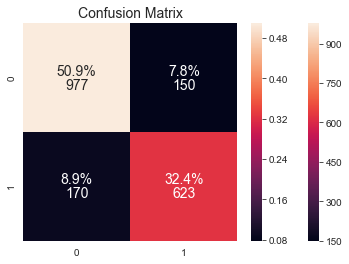

Train accuracy: 84.59%
Test accuracy: 83.33%
{'C': [0.5], 'class_weight': ['balanced'], 'gamma': ['auto'], 'kernel': ['rbf']}


In [77]:
#base model 2 (SVC)
svc = SVC(random_state=42)
best_params_a, model2a = gridsearch_params(svc, best_params_a, update_params=False)

model2 = model2a
test_pred2, train_pred2 = Stacking(model=model2, n_fold=10, train=X_train,
                                   test=X_test, y=y_train.koi_pdisposition)
train_pred2 = pd.DataFrame(train_pred2)
test_pred2 = pd.DataFrame(test_pred2)

Train Score: 0.8040646169880146
Test Score: 0.828125


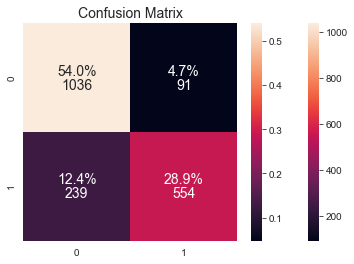

In [78]:
# stacking a new model (LR) on top of the two bases
df_stack_tr = pd.concat([train_pred1, train_pred2], axis=1)
df_stack_tr.columns = ['xgb','svc']
df_stack_tst = pd.concat([test_pred1, test_pred2], axis=1)
df_stack_tst.columns = ['xgb','svc']

model_stack = LogisticRegression(solver='lbfgs', random_state=42)
model_stack.fit(df_stack_tr, y_train.koi_pdisposition)

print('Train Score:', model_stack.score(df_stack_tr, y_train.koi_pdisposition))
print('Test Score:', model_stack.score(df_stack_tst, y_test.koi_pdisposition))
y_pred = model_stack.predict(df_stack_tst)
confu_matrix(y_pred, df_stack_tst, y_test)

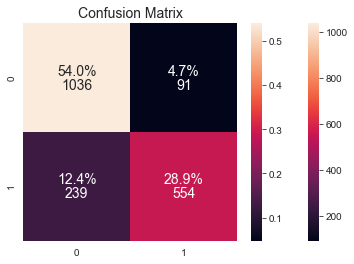

Train accuracy: 80.41%
Test accuracy: 82.80999999999999%
{'C': [0.1], 'class_weight': [None], 'solver': ['newton-cg']}


In [79]:
# tuning stacked model hyperparameters
temp_X_train, temp_X_test = X_train.copy(), X_test.copy()
X_train = df_stack_tr
X_test = df_stack_tst
model_stack = LogisticRegression(random_state=42)
lr_params = {'C': [.1, 1, 1.5, 2, 2.5],
             'class_weight': [None,'balanced'],
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
            }
best_params, model_stacked = gridsearch_params(model_stack, lr_params, update_params=False)
X_train, X_test = temp_X_train, temp_X_test

## Principal Component Analysis

First, we need to determine how many engineered features are required in order to explain at least 95% of the variance in the dataset. We can do this using Principal Component Analysis.

Number of features which explain 95% of variance:   14


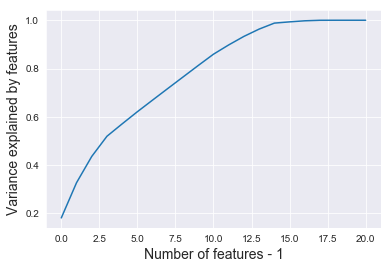

In [80]:
# perfrom Principal Component Analysis to determine how many features
# will explain 95% of model variance
pca = PCA()
features_pca = pca.fit_transform(features_for_PCA)
variance = pca.explained_variance_ratio_.cumsum()
plt.plot(range(features_pca.shape[1]), variance)
plt.xlabel("Number of features - 1", fontsize=14)
plt.ylabel("Variance explained by features", fontsize=14);

n_features = len(variance[variance <= .95]) + 1
print(f'Number of features which explain 95% of variance:   {n_features}')

### Train test split again for PCA

In [81]:
# train, test, split PCA data for future models
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels_PCA, random_state=42)

### Compare classification methods

In [82]:
classifiers = [KNeighborsClassifier, SVC, DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, XGBClassifier]

In [83]:
classy_scores = []
for classifier in classifiers:
    clf = classifier()
    clf.fit(X_train, y_train.values.flatten())
    score = clf.score(X_test, y_test.values.flatten())
    classy_scores.append((str(classifier), score))
ranked_classifiers = sorted(classy_scores, key=lambda x: x[1], reverse=True)

ranked_classifiers

[("<class 'sklearn.svm.classes.SVC'>", 0.8359375),
 ("<class 'sklearn.neighbors.classification.KNeighborsClassifier'>",
  0.8197916666666667),
 ("<class 'xgboost.sklearn.XGBClassifier'>", 0.815625),
 ("<class 'sklearn.ensemble.forest.RandomForestClassifier'>",
  0.8057291666666667),
 ("<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>",
  0.7973958333333333),
 ("<class 'sklearn.tree.tree.DecisionTreeClassifier'>", 0.7838541666666666)]

### Begin tuning parameters for XGBoost

Many thanks to this site: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ for providing a walkthrough to tuning XGBoost parameters.

Model Report
Train accuracy: 87.29%
Test accuracy: 82.03%
AUC Score (Train): 0.9478179725346086
AUC Score (Test): 0.9089470757325355


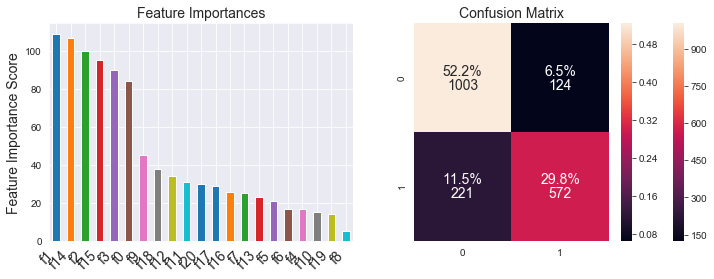

In [84]:
xgb_pca = XGBClassifier(learning_rate=0.1,
                     n_estimators=1000,
                     objective='binary:logistic',
                     nthread=4,
                     seed=42)
modelfit(xgb_pca, X_train, y_train.values.flatten(), X_test, y_test.values.flatten(), 1000, 20)

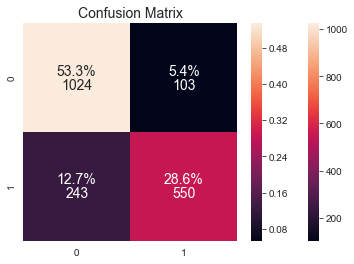

Train accuracy: 84.61%
Test accuracy: 81.98%
{'max_depth': [3], 'min_child_weight': [3]}


In [85]:
# building a model with default parameters
xgb_params = {}
xgb_pca = XGBClassifier(learning_rate=0.1, n_estimators=100, nthread=4,
                        random_state=42, objective='binary:logistic')
best_params, clf_xgb = gridsearch_params(xgb_pca, param_test1, update_params=False, xgb=True)

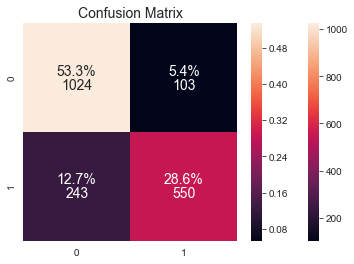

Train accuracy: 84.61%
Test accuracy: 81.98%
{'max_depth': [3], 'min_child_weight': [3]}


In [86]:
# Tuning max_depth, min_child_weight
param_test1 = {'max_depth':range(3,8), 
              'min_child_weight':range(1,6)
              }
xgb_pca = XGBClassifier(learning_rate=0.1, n_estimators=1000,
                        objective='binary:logistic', nthread=4, seed=42)
best_params, clf_xgb = gridsearch_params(xgb_pca, param_test1, update_params=False, xgb=True)

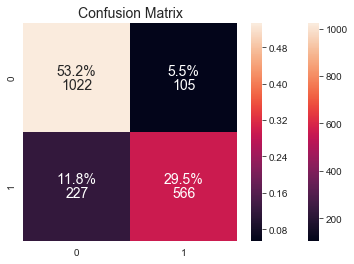

Train accuracy: 85.36%
Test accuracy: 82.71%
{'colsample_bytree': [0.95], 'gamma': [0.2], 'max_depth': [3], 'min_child_weight': [3], 'subsample': [0.9]}


In [87]:
# Tuning gamma, subsample, and colsample_bytree
param_test2 = {'gamma': np.linspace(0.0, 0.2, 5),
               'subsample':np.linspace(.8, 1.0, 5),
               'colsample_bytree':np.linspace(.8, 1.0, 5)
              }
best_params, clf_xgb = gridsearch_params(xgb_pca, param_test2, best_params,
                                         update_params=True, xgb=True)

### Begin tuning parameters for SVM

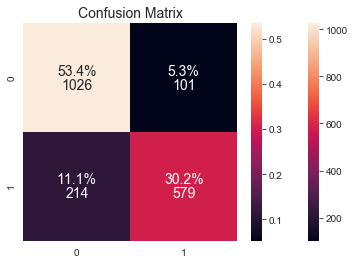

Train accuracy: 85.6%
Test accuracy: 83.59%
{}


In [88]:
# building a model with default parameters
svc_pca = SVC(random_state=42, gamma='auto')
svc_params = {}
best_params, clf_svc = gridsearch_params(svc_pca, svc_params, update_params=False)

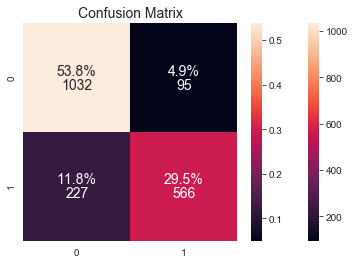

Train accuracy: 84.94%
Test accuracy: 83.23%
{'C': [0.7], 'class_weight': [None], 'gamma': ['scale'], 'probability': [True]}


In [89]:
# tuning hyperparameters
svc_pca = SVC(random_state=42)
svc_params = {'probability':[True],
              'C': np.linspace(.1, 1.9, 10),
              'class_weight': [None,'balanced'],
              'gamma': ['auto','scale']
             }
best_params, clf_svc = gridsearch_params(svc_pca, svc_params, update_params=False)

**Though the test score went down slightly, at least overfitting has been reduced by more.**

## Use Stacking

Here's some articles on it:
    - https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/
    - http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/

In [90]:
def Stacking(model, train, test, y, n_fold, xgb=False, eval_metric='error@.8'):
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)
    folds = StratifiedKFold(n_splits=n_fold, random_state=42)
    test_pred = np.empty((0,1), float)
    train_pred = np.empty((0,1), float)
    for train_indices, val_indices in folds.split(train, y.values):
        if xgb:
            x_tr, x_val = train.iloc[train_indices], train.iloc[val_indices]
            y_tr, y_val = y.iloc[train_indices], y.iloc[val_indices]
            model.fit(x_tr, y_tr, eval_metric='error@.8',
                      eval_set=[(x_val, y_val)])
            train_pred = np.append(train_pred, model.predict(x_val))
        else:
            x_tr, x_val = train.iloc[train_indices], train.iloc[val_indices]
            y_tr, y_val = y.iloc[train_indices], y.iloc[val_indices]
            model.fit(x_tr, y_tr)
            train_pred = np.append(train_pred, model.predict(x_val))
    test_pred = np.append(test_pred, model.predict(test))
    return test_pred, train_pred

In [91]:
#base model 1 (XGBoostClassifier)
model1 = clf_xgb

test_pred1, train_pred1 = Stacking(model=model1, n_fold=10, train=X_train,
                                   test=X_test, y=y_train.koi_pdisposition,
                                   xgb=True)

train_pred1 = pd.DataFrame(train_pred1)
test_pred1 = pd.DataFrame(test_pred1)

[0]	validation_0-error@0.8:0.429809
[1]	validation_0-error@0.8:0.429809
[2]	validation_0-error@0.8:0.429809
[3]	validation_0-error@0.8:0.429809
[4]	validation_0-error@0.8:0.429809
[5]	validation_0-error@0.8:0.429809
[6]	validation_0-error@0.8:0.429809
[7]	validation_0-error@0.8:0.429809
[8]	validation_0-error@0.8:0.429809
[9]	validation_0-error@0.8:0.40208
[10]	validation_0-error@0.8:0.34662
[11]	validation_0-error@0.8:0.360485
[12]	validation_0-error@0.8:0.32409
[13]	validation_0-error@0.8:0.313691
[14]	validation_0-error@0.8:0.299827
[15]	validation_0-error@0.8:0.291161
[16]	validation_0-error@0.8:0.291161
[17]	validation_0-error@0.8:0.285962
[18]	validation_0-error@0.8:0.287695
[19]	validation_0-error@0.8:0.285962
[20]	validation_0-error@0.8:0.282496
[21]	validation_0-error@0.8:0.277296
[22]	validation_0-error@0.8:0.275563
[23]	validation_0-error@0.8:0.268631
[24]	validation_0-error@0.8:0.270364
[25]	validation_0-error@0.8:0.270364
[26]	validation_0-error@0.8:0.266898
[27]	validatio

[219]	validation_0-error@0.8:0.232236
[220]	validation_0-error@0.8:0.232236
[221]	validation_0-error@0.8:0.230503
[222]	validation_0-error@0.8:0.230503
[223]	validation_0-error@0.8:0.230503
[224]	validation_0-error@0.8:0.230503
[225]	validation_0-error@0.8:0.230503
[226]	validation_0-error@0.8:0.230503
[227]	validation_0-error@0.8:0.230503
[228]	validation_0-error@0.8:0.230503
[229]	validation_0-error@0.8:0.230503
[230]	validation_0-error@0.8:0.230503
[231]	validation_0-error@0.8:0.230503
[232]	validation_0-error@0.8:0.230503
[233]	validation_0-error@0.8:0.230503
[234]	validation_0-error@0.8:0.230503
[235]	validation_0-error@0.8:0.230503
[236]	validation_0-error@0.8:0.228769
[237]	validation_0-error@0.8:0.228769
[238]	validation_0-error@0.8:0.227036
[239]	validation_0-error@0.8:0.228769
[240]	validation_0-error@0.8:0.228769
[241]	validation_0-error@0.8:0.228769
[242]	validation_0-error@0.8:0.227036
[243]	validation_0-error@0.8:0.227036
[244]	validation_0-error@0.8:0.225303
[245]	valida

[435]	validation_0-error@0.8:0.211438
[436]	validation_0-error@0.8:0.211438
[437]	validation_0-error@0.8:0.211438
[438]	validation_0-error@0.8:0.211438
[439]	validation_0-error@0.8:0.209705
[440]	validation_0-error@0.8:0.207972
[441]	validation_0-error@0.8:0.209705
[442]	validation_0-error@0.8:0.211438
[443]	validation_0-error@0.8:0.211438
[444]	validation_0-error@0.8:0.209705
[445]	validation_0-error@0.8:0.209705
[446]	validation_0-error@0.8:0.209705
[447]	validation_0-error@0.8:0.209705
[448]	validation_0-error@0.8:0.209705
[449]	validation_0-error@0.8:0.211438
[450]	validation_0-error@0.8:0.211438
[451]	validation_0-error@0.8:0.211438
[452]	validation_0-error@0.8:0.211438
[453]	validation_0-error@0.8:0.211438
[454]	validation_0-error@0.8:0.213172
[455]	validation_0-error@0.8:0.211438
[456]	validation_0-error@0.8:0.213172
[457]	validation_0-error@0.8:0.213172
[458]	validation_0-error@0.8:0.213172
[459]	validation_0-error@0.8:0.213172
[460]	validation_0-error@0.8:0.213172
[461]	valida

[651]	validation_0-error@0.8:0.207972
[652]	validation_0-error@0.8:0.207972
[653]	validation_0-error@0.8:0.207972
[654]	validation_0-error@0.8:0.209705
[655]	validation_0-error@0.8:0.209705
[656]	validation_0-error@0.8:0.209705
[657]	validation_0-error@0.8:0.207972
[658]	validation_0-error@0.8:0.207972
[659]	validation_0-error@0.8:0.207972
[660]	validation_0-error@0.8:0.207972
[661]	validation_0-error@0.8:0.207972
[662]	validation_0-error@0.8:0.207972
[663]	validation_0-error@0.8:0.207972
[664]	validation_0-error@0.8:0.209705
[665]	validation_0-error@0.8:0.209705
[666]	validation_0-error@0.8:0.207972
[667]	validation_0-error@0.8:0.207972
[668]	validation_0-error@0.8:0.207972
[669]	validation_0-error@0.8:0.209705
[670]	validation_0-error@0.8:0.211438
[671]	validation_0-error@0.8:0.211438
[672]	validation_0-error@0.8:0.211438
[673]	validation_0-error@0.8:0.211438
[674]	validation_0-error@0.8:0.211438
[675]	validation_0-error@0.8:0.211438
[676]	validation_0-error@0.8:0.211438
[677]	valida

[868]	validation_0-error@0.8:0.204506
[869]	validation_0-error@0.8:0.202773
[870]	validation_0-error@0.8:0.206239
[871]	validation_0-error@0.8:0.206239
[872]	validation_0-error@0.8:0.206239
[873]	validation_0-error@0.8:0.206239
[874]	validation_0-error@0.8:0.204506
[875]	validation_0-error@0.8:0.204506
[876]	validation_0-error@0.8:0.202773
[877]	validation_0-error@0.8:0.202773
[878]	validation_0-error@0.8:0.204506
[879]	validation_0-error@0.8:0.204506
[880]	validation_0-error@0.8:0.206239
[881]	validation_0-error@0.8:0.206239
[882]	validation_0-error@0.8:0.204506
[883]	validation_0-error@0.8:0.204506
[884]	validation_0-error@0.8:0.204506
[885]	validation_0-error@0.8:0.204506
[886]	validation_0-error@0.8:0.204506
[887]	validation_0-error@0.8:0.204506
[888]	validation_0-error@0.8:0.204506
[889]	validation_0-error@0.8:0.206239
[890]	validation_0-error@0.8:0.206239
[891]	validation_0-error@0.8:0.204506
[892]	validation_0-error@0.8:0.206239
[893]	validation_0-error@0.8:0.206239
[894]	valida

[88]	validation_0-error@0.8:0.220104
[89]	validation_0-error@0.8:0.22357
[90]	validation_0-error@0.8:0.22357
[91]	validation_0-error@0.8:0.22357
[92]	validation_0-error@0.8:0.221837
[93]	validation_0-error@0.8:0.22357
[94]	validation_0-error@0.8:0.22357
[95]	validation_0-error@0.8:0.22357
[96]	validation_0-error@0.8:0.225303
[97]	validation_0-error@0.8:0.225303
[98]	validation_0-error@0.8:0.221837
[99]	validation_0-error@0.8:0.221837
[100]	validation_0-error@0.8:0.22357
[101]	validation_0-error@0.8:0.22357
[102]	validation_0-error@0.8:0.22357
[103]	validation_0-error@0.8:0.22357
[104]	validation_0-error@0.8:0.22357
[105]	validation_0-error@0.8:0.22357
[106]	validation_0-error@0.8:0.22357
[107]	validation_0-error@0.8:0.22357
[108]	validation_0-error@0.8:0.22357
[109]	validation_0-error@0.8:0.22357
[110]	validation_0-error@0.8:0.22357
[111]	validation_0-error@0.8:0.22357
[112]	validation_0-error@0.8:0.221837
[113]	validation_0-error@0.8:0.225303
[114]	validation_0-error@0.8:0.225303
[115

[305]	validation_0-error@0.8:0.213172
[306]	validation_0-error@0.8:0.214905
[307]	validation_0-error@0.8:0.214905
[308]	validation_0-error@0.8:0.214905
[309]	validation_0-error@0.8:0.214905
[310]	validation_0-error@0.8:0.214905
[311]	validation_0-error@0.8:0.214905
[312]	validation_0-error@0.8:0.213172
[313]	validation_0-error@0.8:0.214905
[314]	validation_0-error@0.8:0.214905
[315]	validation_0-error@0.8:0.214905
[316]	validation_0-error@0.8:0.214905
[317]	validation_0-error@0.8:0.214905
[318]	validation_0-error@0.8:0.214905
[319]	validation_0-error@0.8:0.214905
[320]	validation_0-error@0.8:0.214905
[321]	validation_0-error@0.8:0.214905
[322]	validation_0-error@0.8:0.214905
[323]	validation_0-error@0.8:0.214905
[324]	validation_0-error@0.8:0.214905
[325]	validation_0-error@0.8:0.214905
[326]	validation_0-error@0.8:0.214905
[327]	validation_0-error@0.8:0.214905
[328]	validation_0-error@0.8:0.214905
[329]	validation_0-error@0.8:0.214905
[330]	validation_0-error@0.8:0.214905
[331]	valida

[521]	validation_0-error@0.8:0.207972
[522]	validation_0-error@0.8:0.209705
[523]	validation_0-error@0.8:0.207972
[524]	validation_0-error@0.8:0.207972
[525]	validation_0-error@0.8:0.207972
[526]	validation_0-error@0.8:0.207972
[527]	validation_0-error@0.8:0.207972
[528]	validation_0-error@0.8:0.207972
[529]	validation_0-error@0.8:0.206239
[530]	validation_0-error@0.8:0.206239
[531]	validation_0-error@0.8:0.206239
[532]	validation_0-error@0.8:0.206239
[533]	validation_0-error@0.8:0.207972
[534]	validation_0-error@0.8:0.207972
[535]	validation_0-error@0.8:0.207972
[536]	validation_0-error@0.8:0.207972
[537]	validation_0-error@0.8:0.207972
[538]	validation_0-error@0.8:0.207972
[539]	validation_0-error@0.8:0.207972
[540]	validation_0-error@0.8:0.207972
[541]	validation_0-error@0.8:0.207972
[542]	validation_0-error@0.8:0.209705
[543]	validation_0-error@0.8:0.209705
[544]	validation_0-error@0.8:0.209705
[545]	validation_0-error@0.8:0.207972
[546]	validation_0-error@0.8:0.209705
[547]	valida

[738]	validation_0-error@0.8:0.195841
[739]	validation_0-error@0.8:0.195841
[740]	validation_0-error@0.8:0.195841
[741]	validation_0-error@0.8:0.195841
[742]	validation_0-error@0.8:0.195841
[743]	validation_0-error@0.8:0.195841
[744]	validation_0-error@0.8:0.195841
[745]	validation_0-error@0.8:0.195841
[746]	validation_0-error@0.8:0.195841
[747]	validation_0-error@0.8:0.195841
[748]	validation_0-error@0.8:0.195841
[749]	validation_0-error@0.8:0.195841
[750]	validation_0-error@0.8:0.197574
[751]	validation_0-error@0.8:0.195841
[752]	validation_0-error@0.8:0.195841
[753]	validation_0-error@0.8:0.195841
[754]	validation_0-error@0.8:0.194107
[755]	validation_0-error@0.8:0.194107
[756]	validation_0-error@0.8:0.195841
[757]	validation_0-error@0.8:0.195841
[758]	validation_0-error@0.8:0.195841
[759]	validation_0-error@0.8:0.195841
[760]	validation_0-error@0.8:0.195841
[761]	validation_0-error@0.8:0.195841
[762]	validation_0-error@0.8:0.194107
[763]	validation_0-error@0.8:0.194107
[764]	valida

[954]	validation_0-error@0.8:0.187175
[955]	validation_0-error@0.8:0.187175
[956]	validation_0-error@0.8:0.185442
[957]	validation_0-error@0.8:0.187175
[958]	validation_0-error@0.8:0.185442
[959]	validation_0-error@0.8:0.185442
[960]	validation_0-error@0.8:0.185442
[961]	validation_0-error@0.8:0.185442
[962]	validation_0-error@0.8:0.185442
[963]	validation_0-error@0.8:0.185442
[964]	validation_0-error@0.8:0.185442
[965]	validation_0-error@0.8:0.185442
[966]	validation_0-error@0.8:0.185442
[967]	validation_0-error@0.8:0.185442
[968]	validation_0-error@0.8:0.185442
[969]	validation_0-error@0.8:0.187175
[970]	validation_0-error@0.8:0.185442
[971]	validation_0-error@0.8:0.185442
[972]	validation_0-error@0.8:0.185442
[973]	validation_0-error@0.8:0.185442
[974]	validation_0-error@0.8:0.185442
[975]	validation_0-error@0.8:0.185442
[976]	validation_0-error@0.8:0.185442
[977]	validation_0-error@0.8:0.185442
[978]	validation_0-error@0.8:0.187175
[979]	validation_0-error@0.8:0.187175
[980]	valida

[173]	validation_0-error@0.8:0.213542
[174]	validation_0-error@0.8:0.210069
[175]	validation_0-error@0.8:0.208333
[176]	validation_0-error@0.8:0.206597
[177]	validation_0-error@0.8:0.208333
[178]	validation_0-error@0.8:0.208333
[179]	validation_0-error@0.8:0.208333
[180]	validation_0-error@0.8:0.208333
[181]	validation_0-error@0.8:0.206597
[182]	validation_0-error@0.8:0.208333
[183]	validation_0-error@0.8:0.208333
[184]	validation_0-error@0.8:0.208333
[185]	validation_0-error@0.8:0.208333
[186]	validation_0-error@0.8:0.206597
[187]	validation_0-error@0.8:0.204861
[188]	validation_0-error@0.8:0.206597
[189]	validation_0-error@0.8:0.208333
[190]	validation_0-error@0.8:0.204861
[191]	validation_0-error@0.8:0.204861
[192]	validation_0-error@0.8:0.204861
[193]	validation_0-error@0.8:0.204861
[194]	validation_0-error@0.8:0.204861
[195]	validation_0-error@0.8:0.206597
[196]	validation_0-error@0.8:0.206597
[197]	validation_0-error@0.8:0.206597
[198]	validation_0-error@0.8:0.206597
[199]	valida

[389]	validation_0-error@0.8:0.197917
[390]	validation_0-error@0.8:0.197917
[391]	validation_0-error@0.8:0.197917
[392]	validation_0-error@0.8:0.197917
[393]	validation_0-error@0.8:0.197917
[394]	validation_0-error@0.8:0.197917
[395]	validation_0-error@0.8:0.197917
[396]	validation_0-error@0.8:0.196181
[397]	validation_0-error@0.8:0.196181
[398]	validation_0-error@0.8:0.196181
[399]	validation_0-error@0.8:0.196181
[400]	validation_0-error@0.8:0.196181
[401]	validation_0-error@0.8:0.194444
[402]	validation_0-error@0.8:0.194444
[403]	validation_0-error@0.8:0.196181
[404]	validation_0-error@0.8:0.196181
[405]	validation_0-error@0.8:0.196181
[406]	validation_0-error@0.8:0.189236
[407]	validation_0-error@0.8:0.189236
[408]	validation_0-error@0.8:0.189236
[409]	validation_0-error@0.8:0.1875
[410]	validation_0-error@0.8:0.1875
[411]	validation_0-error@0.8:0.1875
[412]	validation_0-error@0.8:0.189236
[413]	validation_0-error@0.8:0.189236
[414]	validation_0-error@0.8:0.189236
[415]	validation_0

[607]	validation_0-error@0.8:0.1875
[608]	validation_0-error@0.8:0.1875
[609]	validation_0-error@0.8:0.1875
[610]	validation_0-error@0.8:0.1875
[611]	validation_0-error@0.8:0.190972
[612]	validation_0-error@0.8:0.189236
[613]	validation_0-error@0.8:0.189236
[614]	validation_0-error@0.8:0.189236
[615]	validation_0-error@0.8:0.190972
[616]	validation_0-error@0.8:0.190972
[617]	validation_0-error@0.8:0.189236
[618]	validation_0-error@0.8:0.189236
[619]	validation_0-error@0.8:0.189236
[620]	validation_0-error@0.8:0.189236
[621]	validation_0-error@0.8:0.1875
[622]	validation_0-error@0.8:0.189236
[623]	validation_0-error@0.8:0.189236
[624]	validation_0-error@0.8:0.189236
[625]	validation_0-error@0.8:0.189236
[626]	validation_0-error@0.8:0.189236
[627]	validation_0-error@0.8:0.189236
[628]	validation_0-error@0.8:0.189236
[629]	validation_0-error@0.8:0.189236
[630]	validation_0-error@0.8:0.189236
[631]	validation_0-error@0.8:0.190972
[632]	validation_0-error@0.8:0.190972
[633]	validation_0-err

[824]	validation_0-error@0.8:0.177083
[825]	validation_0-error@0.8:0.177083
[826]	validation_0-error@0.8:0.178819
[827]	validation_0-error@0.8:0.177083
[828]	validation_0-error@0.8:0.177083
[829]	validation_0-error@0.8:0.182292
[830]	validation_0-error@0.8:0.182292
[831]	validation_0-error@0.8:0.182292
[832]	validation_0-error@0.8:0.182292
[833]	validation_0-error@0.8:0.178819
[834]	validation_0-error@0.8:0.178819
[835]	validation_0-error@0.8:0.178819
[836]	validation_0-error@0.8:0.177083
[837]	validation_0-error@0.8:0.177083
[838]	validation_0-error@0.8:0.180556
[839]	validation_0-error@0.8:0.178819
[840]	validation_0-error@0.8:0.178819
[841]	validation_0-error@0.8:0.178819
[842]	validation_0-error@0.8:0.180556
[843]	validation_0-error@0.8:0.180556
[844]	validation_0-error@0.8:0.178819
[845]	validation_0-error@0.8:0.180556
[846]	validation_0-error@0.8:0.178819
[847]	validation_0-error@0.8:0.180556
[848]	validation_0-error@0.8:0.180556
[849]	validation_0-error@0.8:0.182292
[850]	valida

[41]	validation_0-error@0.8:0.239583
[42]	validation_0-error@0.8:0.239583
[43]	validation_0-error@0.8:0.236111
[44]	validation_0-error@0.8:0.237847
[45]	validation_0-error@0.8:0.236111
[46]	validation_0-error@0.8:0.236111
[47]	validation_0-error@0.8:0.236111
[48]	validation_0-error@0.8:0.234375
[49]	validation_0-error@0.8:0.232639
[50]	validation_0-error@0.8:0.227431
[51]	validation_0-error@0.8:0.227431
[52]	validation_0-error@0.8:0.227431
[53]	validation_0-error@0.8:0.229167
[54]	validation_0-error@0.8:0.223958
[55]	validation_0-error@0.8:0.225694
[56]	validation_0-error@0.8:0.21875
[57]	validation_0-error@0.8:0.217014
[58]	validation_0-error@0.8:0.217014
[59]	validation_0-error@0.8:0.217014
[60]	validation_0-error@0.8:0.217014
[61]	validation_0-error@0.8:0.217014
[62]	validation_0-error@0.8:0.217014
[63]	validation_0-error@0.8:0.217014
[64]	validation_0-error@0.8:0.217014
[65]	validation_0-error@0.8:0.217014
[66]	validation_0-error@0.8:0.217014
[67]	validation_0-error@0.8:0.21875
[68

[259]	validation_0-error@0.8:0.211806
[260]	validation_0-error@0.8:0.211806
[261]	validation_0-error@0.8:0.210069
[262]	validation_0-error@0.8:0.210069
[263]	validation_0-error@0.8:0.210069
[264]	validation_0-error@0.8:0.211806
[265]	validation_0-error@0.8:0.211806
[266]	validation_0-error@0.8:0.211806
[267]	validation_0-error@0.8:0.211806
[268]	validation_0-error@0.8:0.211806
[269]	validation_0-error@0.8:0.211806
[270]	validation_0-error@0.8:0.210069
[271]	validation_0-error@0.8:0.210069
[272]	validation_0-error@0.8:0.210069
[273]	validation_0-error@0.8:0.210069
[274]	validation_0-error@0.8:0.210069
[275]	validation_0-error@0.8:0.210069
[276]	validation_0-error@0.8:0.210069
[277]	validation_0-error@0.8:0.210069
[278]	validation_0-error@0.8:0.210069
[279]	validation_0-error@0.8:0.208333
[280]	validation_0-error@0.8:0.211806
[281]	validation_0-error@0.8:0.210069
[282]	validation_0-error@0.8:0.210069
[283]	validation_0-error@0.8:0.210069
[284]	validation_0-error@0.8:0.210069
[285]	valida

[475]	validation_0-error@0.8:0.197917
[476]	validation_0-error@0.8:0.201389
[477]	validation_0-error@0.8:0.201389
[478]	validation_0-error@0.8:0.201389
[479]	validation_0-error@0.8:0.203125
[480]	validation_0-error@0.8:0.203125
[481]	validation_0-error@0.8:0.203125
[482]	validation_0-error@0.8:0.203125
[483]	validation_0-error@0.8:0.203125
[484]	validation_0-error@0.8:0.201389
[485]	validation_0-error@0.8:0.203125
[486]	validation_0-error@0.8:0.203125
[487]	validation_0-error@0.8:0.201389
[488]	validation_0-error@0.8:0.201389
[489]	validation_0-error@0.8:0.201389
[490]	validation_0-error@0.8:0.201389
[491]	validation_0-error@0.8:0.201389
[492]	validation_0-error@0.8:0.201389
[493]	validation_0-error@0.8:0.201389
[494]	validation_0-error@0.8:0.201389
[495]	validation_0-error@0.8:0.199653
[496]	validation_0-error@0.8:0.199653
[497]	validation_0-error@0.8:0.199653
[498]	validation_0-error@0.8:0.199653
[499]	validation_0-error@0.8:0.199653
[500]	validation_0-error@0.8:0.199653
[501]	valida

[691]	validation_0-error@0.8:0.190972
[692]	validation_0-error@0.8:0.190972
[693]	validation_0-error@0.8:0.192708
[694]	validation_0-error@0.8:0.192708
[695]	validation_0-error@0.8:0.192708
[696]	validation_0-error@0.8:0.192708
[697]	validation_0-error@0.8:0.192708
[698]	validation_0-error@0.8:0.192708
[699]	validation_0-error@0.8:0.192708
[700]	validation_0-error@0.8:0.192708
[701]	validation_0-error@0.8:0.190972
[702]	validation_0-error@0.8:0.190972
[703]	validation_0-error@0.8:0.190972
[704]	validation_0-error@0.8:0.190972
[705]	validation_0-error@0.8:0.192708
[706]	validation_0-error@0.8:0.192708
[707]	validation_0-error@0.8:0.192708
[708]	validation_0-error@0.8:0.192708
[709]	validation_0-error@0.8:0.192708
[710]	validation_0-error@0.8:0.192708
[711]	validation_0-error@0.8:0.192708
[712]	validation_0-error@0.8:0.192708
[713]	validation_0-error@0.8:0.190972
[714]	validation_0-error@0.8:0.190972
[715]	validation_0-error@0.8:0.189236
[716]	validation_0-error@0.8:0.1875
[717]	validati

[908]	validation_0-error@0.8:0.185764
[909]	validation_0-error@0.8:0.185764
[910]	validation_0-error@0.8:0.185764
[911]	validation_0-error@0.8:0.185764
[912]	validation_0-error@0.8:0.185764
[913]	validation_0-error@0.8:0.185764
[914]	validation_0-error@0.8:0.185764
[915]	validation_0-error@0.8:0.185764
[916]	validation_0-error@0.8:0.184028
[917]	validation_0-error@0.8:0.184028
[918]	validation_0-error@0.8:0.184028
[919]	validation_0-error@0.8:0.182292
[920]	validation_0-error@0.8:0.182292
[921]	validation_0-error@0.8:0.184028
[922]	validation_0-error@0.8:0.184028
[923]	validation_0-error@0.8:0.184028
[924]	validation_0-error@0.8:0.184028
[925]	validation_0-error@0.8:0.184028
[926]	validation_0-error@0.8:0.184028
[927]	validation_0-error@0.8:0.184028
[928]	validation_0-error@0.8:0.184028
[929]	validation_0-error@0.8:0.184028
[930]	validation_0-error@0.8:0.184028
[931]	validation_0-error@0.8:0.185764
[932]	validation_0-error@0.8:0.184028
[933]	validation_0-error@0.8:0.184028
[934]	valida

[129]	validation_0-error@0.8:0.196181
[130]	validation_0-error@0.8:0.196181
[131]	validation_0-error@0.8:0.196181
[132]	validation_0-error@0.8:0.196181
[133]	validation_0-error@0.8:0.196181
[134]	validation_0-error@0.8:0.196181
[135]	validation_0-error@0.8:0.197917
[136]	validation_0-error@0.8:0.196181
[137]	validation_0-error@0.8:0.196181
[138]	validation_0-error@0.8:0.196181
[139]	validation_0-error@0.8:0.194444
[140]	validation_0-error@0.8:0.194444
[141]	validation_0-error@0.8:0.192708
[142]	validation_0-error@0.8:0.192708
[143]	validation_0-error@0.8:0.190972
[144]	validation_0-error@0.8:0.190972
[145]	validation_0-error@0.8:0.189236
[146]	validation_0-error@0.8:0.189236
[147]	validation_0-error@0.8:0.189236
[148]	validation_0-error@0.8:0.189236
[149]	validation_0-error@0.8:0.190972
[150]	validation_0-error@0.8:0.190972
[151]	validation_0-error@0.8:0.190972
[152]	validation_0-error@0.8:0.190972
[153]	validation_0-error@0.8:0.190972
[154]	validation_0-error@0.8:0.189236
[155]	valida

[346]	validation_0-error@0.8:0.182292
[347]	validation_0-error@0.8:0.182292
[348]	validation_0-error@0.8:0.182292
[349]	validation_0-error@0.8:0.182292
[350]	validation_0-error@0.8:0.184028
[351]	validation_0-error@0.8:0.184028
[352]	validation_0-error@0.8:0.182292
[353]	validation_0-error@0.8:0.184028
[354]	validation_0-error@0.8:0.184028
[355]	validation_0-error@0.8:0.184028
[356]	validation_0-error@0.8:0.185764
[357]	validation_0-error@0.8:0.184028
[358]	validation_0-error@0.8:0.184028
[359]	validation_0-error@0.8:0.182292
[360]	validation_0-error@0.8:0.182292
[361]	validation_0-error@0.8:0.182292
[362]	validation_0-error@0.8:0.180556
[363]	validation_0-error@0.8:0.184028
[364]	validation_0-error@0.8:0.184028
[365]	validation_0-error@0.8:0.184028
[366]	validation_0-error@0.8:0.182292
[367]	validation_0-error@0.8:0.182292
[368]	validation_0-error@0.8:0.182292
[369]	validation_0-error@0.8:0.182292
[370]	validation_0-error@0.8:0.182292
[371]	validation_0-error@0.8:0.182292
[372]	valida

[562]	validation_0-error@0.8:0.184028
[563]	validation_0-error@0.8:0.184028
[564]	validation_0-error@0.8:0.184028
[565]	validation_0-error@0.8:0.184028
[566]	validation_0-error@0.8:0.182292
[567]	validation_0-error@0.8:0.182292
[568]	validation_0-error@0.8:0.182292
[569]	validation_0-error@0.8:0.182292
[570]	validation_0-error@0.8:0.182292
[571]	validation_0-error@0.8:0.182292
[572]	validation_0-error@0.8:0.182292
[573]	validation_0-error@0.8:0.182292
[574]	validation_0-error@0.8:0.180556
[575]	validation_0-error@0.8:0.180556
[576]	validation_0-error@0.8:0.180556
[577]	validation_0-error@0.8:0.180556
[578]	validation_0-error@0.8:0.180556
[579]	validation_0-error@0.8:0.180556
[580]	validation_0-error@0.8:0.180556
[581]	validation_0-error@0.8:0.182292
[582]	validation_0-error@0.8:0.182292
[583]	validation_0-error@0.8:0.182292
[584]	validation_0-error@0.8:0.182292
[585]	validation_0-error@0.8:0.182292
[586]	validation_0-error@0.8:0.182292
[587]	validation_0-error@0.8:0.182292
[588]	valida

[780]	validation_0-error@0.8:0.190972
[781]	validation_0-error@0.8:0.189236
[782]	validation_0-error@0.8:0.189236
[783]	validation_0-error@0.8:0.189236
[784]	validation_0-error@0.8:0.189236
[785]	validation_0-error@0.8:0.189236
[786]	validation_0-error@0.8:0.190972
[787]	validation_0-error@0.8:0.1875
[788]	validation_0-error@0.8:0.1875
[789]	validation_0-error@0.8:0.189236
[790]	validation_0-error@0.8:0.189236
[791]	validation_0-error@0.8:0.189236
[792]	validation_0-error@0.8:0.189236
[793]	validation_0-error@0.8:0.189236
[794]	validation_0-error@0.8:0.189236
[795]	validation_0-error@0.8:0.190972
[796]	validation_0-error@0.8:0.1875
[797]	validation_0-error@0.8:0.185764
[798]	validation_0-error@0.8:0.1875
[799]	validation_0-error@0.8:0.1875
[800]	validation_0-error@0.8:0.189236
[801]	validation_0-error@0.8:0.189236
[802]	validation_0-error@0.8:0.189236
[803]	validation_0-error@0.8:0.190972
[804]	validation_0-error@0.8:0.190972
[805]	validation_0-error@0.8:0.189236
[806]	validation_0-err

[998]	validation_0-error@0.8:0.192708
[999]	validation_0-error@0.8:0.190972
[0]	validation_0-error@0.8:0.429565
[1]	validation_0-error@0.8:0.429565
[2]	validation_0-error@0.8:0.429565
[3]	validation_0-error@0.8:0.429565
[4]	validation_0-error@0.8:0.429565
[5]	validation_0-error@0.8:0.429565
[6]	validation_0-error@0.8:0.429565
[7]	validation_0-error@0.8:0.429565
[8]	validation_0-error@0.8:0.429565
[9]	validation_0-error@0.8:0.349565
[10]	validation_0-error@0.8:0.325217
[11]	validation_0-error@0.8:0.309565
[12]	validation_0-error@0.8:0.302609
[13]	validation_0-error@0.8:0.297391
[14]	validation_0-error@0.8:0.295652
[15]	validation_0-error@0.8:0.295652
[16]	validation_0-error@0.8:0.290435
[17]	validation_0-error@0.8:0.286957
[18]	validation_0-error@0.8:0.286957
[19]	validation_0-error@0.8:0.283478
[20]	validation_0-error@0.8:0.281739
[21]	validation_0-error@0.8:0.283478
[22]	validation_0-error@0.8:0.274783
[23]	validation_0-error@0.8:0.269565
[24]	validation_0-error@0.8:0.271304
[25]	vali

[218]	validation_0-error@0.8:0.210435
[219]	validation_0-error@0.8:0.210435
[220]	validation_0-error@0.8:0.213913
[221]	validation_0-error@0.8:0.213913
[222]	validation_0-error@0.8:0.213913
[223]	validation_0-error@0.8:0.212174
[224]	validation_0-error@0.8:0.213913
[225]	validation_0-error@0.8:0.210435
[226]	validation_0-error@0.8:0.210435
[227]	validation_0-error@0.8:0.210435
[228]	validation_0-error@0.8:0.210435
[229]	validation_0-error@0.8:0.210435
[230]	validation_0-error@0.8:0.210435
[231]	validation_0-error@0.8:0.210435
[232]	validation_0-error@0.8:0.210435
[233]	validation_0-error@0.8:0.210435
[234]	validation_0-error@0.8:0.210435
[235]	validation_0-error@0.8:0.210435
[236]	validation_0-error@0.8:0.212174
[237]	validation_0-error@0.8:0.210435
[238]	validation_0-error@0.8:0.210435
[239]	validation_0-error@0.8:0.208696
[240]	validation_0-error@0.8:0.208696
[241]	validation_0-error@0.8:0.212174
[242]	validation_0-error@0.8:0.212174
[243]	validation_0-error@0.8:0.212174
[244]	valida

[437]	validation_0-error@0.8:0.196522
[438]	validation_0-error@0.8:0.198261
[439]	validation_0-error@0.8:0.198261
[440]	validation_0-error@0.8:0.198261
[441]	validation_0-error@0.8:0.198261
[442]	validation_0-error@0.8:0.198261
[443]	validation_0-error@0.8:0.198261
[444]	validation_0-error@0.8:0.198261
[445]	validation_0-error@0.8:0.198261
[446]	validation_0-error@0.8:0.198261
[447]	validation_0-error@0.8:0.194783
[448]	validation_0-error@0.8:0.194783
[449]	validation_0-error@0.8:0.194783
[450]	validation_0-error@0.8:0.194783
[451]	validation_0-error@0.8:0.196522
[452]	validation_0-error@0.8:0.196522
[453]	validation_0-error@0.8:0.196522
[454]	validation_0-error@0.8:0.194783
[455]	validation_0-error@0.8:0.194783
[456]	validation_0-error@0.8:0.194783
[457]	validation_0-error@0.8:0.194783
[458]	validation_0-error@0.8:0.194783
[459]	validation_0-error@0.8:0.194783
[460]	validation_0-error@0.8:0.194783
[461]	validation_0-error@0.8:0.193043
[462]	validation_0-error@0.8:0.193043
[463]	valida

[653]	validation_0-error@0.8:0.194783
[654]	validation_0-error@0.8:0.196522
[655]	validation_0-error@0.8:0.196522
[656]	validation_0-error@0.8:0.196522
[657]	validation_0-error@0.8:0.194783
[658]	validation_0-error@0.8:0.194783
[659]	validation_0-error@0.8:0.194783
[660]	validation_0-error@0.8:0.193043
[661]	validation_0-error@0.8:0.193043
[662]	validation_0-error@0.8:0.193043
[663]	validation_0-error@0.8:0.193043
[664]	validation_0-error@0.8:0.193043
[665]	validation_0-error@0.8:0.191304
[666]	validation_0-error@0.8:0.193043
[667]	validation_0-error@0.8:0.194783
[668]	validation_0-error@0.8:0.194783
[669]	validation_0-error@0.8:0.193043
[670]	validation_0-error@0.8:0.193043
[671]	validation_0-error@0.8:0.194783
[672]	validation_0-error@0.8:0.194783
[673]	validation_0-error@0.8:0.194783
[674]	validation_0-error@0.8:0.193043
[675]	validation_0-error@0.8:0.193043
[676]	validation_0-error@0.8:0.193043
[677]	validation_0-error@0.8:0.193043
[678]	validation_0-error@0.8:0.193043
[679]	valida

[869]	validation_0-error@0.8:0.193043
[870]	validation_0-error@0.8:0.193043
[871]	validation_0-error@0.8:0.189565
[872]	validation_0-error@0.8:0.189565
[873]	validation_0-error@0.8:0.194783
[874]	validation_0-error@0.8:0.194783
[875]	validation_0-error@0.8:0.191304
[876]	validation_0-error@0.8:0.191304
[877]	validation_0-error@0.8:0.189565
[878]	validation_0-error@0.8:0.189565
[879]	validation_0-error@0.8:0.189565
[880]	validation_0-error@0.8:0.191304
[881]	validation_0-error@0.8:0.191304
[882]	validation_0-error@0.8:0.191304
[883]	validation_0-error@0.8:0.191304
[884]	validation_0-error@0.8:0.191304
[885]	validation_0-error@0.8:0.193043
[886]	validation_0-error@0.8:0.193043
[887]	validation_0-error@0.8:0.193043
[888]	validation_0-error@0.8:0.191304
[889]	validation_0-error@0.8:0.191304
[890]	validation_0-error@0.8:0.191304
[891]	validation_0-error@0.8:0.191304
[892]	validation_0-error@0.8:0.189565
[893]	validation_0-error@0.8:0.189565
[894]	validation_0-error@0.8:0.189565
[895]	valida

[88]	validation_0-error@0.8:0.205217
[89]	validation_0-error@0.8:0.201739
[90]	validation_0-error@0.8:0.201739
[91]	validation_0-error@0.8:0.201739
[92]	validation_0-error@0.8:0.203478
[93]	validation_0-error@0.8:0.201739
[94]	validation_0-error@0.8:0.201739
[95]	validation_0-error@0.8:0.196522
[96]	validation_0-error@0.8:0.194783
[97]	validation_0-error@0.8:0.194783
[98]	validation_0-error@0.8:0.194783
[99]	validation_0-error@0.8:0.194783
[100]	validation_0-error@0.8:0.196522
[101]	validation_0-error@0.8:0.196522
[102]	validation_0-error@0.8:0.196522
[103]	validation_0-error@0.8:0.196522
[104]	validation_0-error@0.8:0.196522
[105]	validation_0-error@0.8:0.196522
[106]	validation_0-error@0.8:0.194783
[107]	validation_0-error@0.8:0.198261
[108]	validation_0-error@0.8:0.198261
[109]	validation_0-error@0.8:0.198261
[110]	validation_0-error@0.8:0.196522
[111]	validation_0-error@0.8:0.194783
[112]	validation_0-error@0.8:0.194783
[113]	validation_0-error@0.8:0.191304
[114]	validation_0-error

[305]	validation_0-error@0.8:0.184348
[306]	validation_0-error@0.8:0.182609
[307]	validation_0-error@0.8:0.182609
[308]	validation_0-error@0.8:0.182609
[309]	validation_0-error@0.8:0.182609
[310]	validation_0-error@0.8:0.18087
[311]	validation_0-error@0.8:0.18087
[312]	validation_0-error@0.8:0.18087
[313]	validation_0-error@0.8:0.17913
[314]	validation_0-error@0.8:0.18087
[315]	validation_0-error@0.8:0.18087
[316]	validation_0-error@0.8:0.18087
[317]	validation_0-error@0.8:0.18087
[318]	validation_0-error@0.8:0.18087
[319]	validation_0-error@0.8:0.18087
[320]	validation_0-error@0.8:0.18087
[321]	validation_0-error@0.8:0.18087
[322]	validation_0-error@0.8:0.18087
[323]	validation_0-error@0.8:0.18087
[324]	validation_0-error@0.8:0.18087
[325]	validation_0-error@0.8:0.18087
[326]	validation_0-error@0.8:0.18087
[327]	validation_0-error@0.8:0.182609
[328]	validation_0-error@0.8:0.182609
[329]	validation_0-error@0.8:0.17913
[330]	validation_0-error@0.8:0.18087
[331]	validation_0-error@0.8:0.

[522]	validation_0-error@0.8:0.177391
[523]	validation_0-error@0.8:0.177391
[524]	validation_0-error@0.8:0.175652
[525]	validation_0-error@0.8:0.173913
[526]	validation_0-error@0.8:0.177391
[527]	validation_0-error@0.8:0.177391
[528]	validation_0-error@0.8:0.175652
[529]	validation_0-error@0.8:0.173913
[530]	validation_0-error@0.8:0.173913
[531]	validation_0-error@0.8:0.172174
[532]	validation_0-error@0.8:0.172174
[533]	validation_0-error@0.8:0.172174
[534]	validation_0-error@0.8:0.172174
[535]	validation_0-error@0.8:0.173913
[536]	validation_0-error@0.8:0.173913
[537]	validation_0-error@0.8:0.173913
[538]	validation_0-error@0.8:0.173913
[539]	validation_0-error@0.8:0.175652
[540]	validation_0-error@0.8:0.177391
[541]	validation_0-error@0.8:0.177391
[542]	validation_0-error@0.8:0.173913
[543]	validation_0-error@0.8:0.177391
[544]	validation_0-error@0.8:0.175652
[545]	validation_0-error@0.8:0.175652
[546]	validation_0-error@0.8:0.175652
[547]	validation_0-error@0.8:0.175652
[548]	valida

[738]	validation_0-error@0.8:0.172174
[739]	validation_0-error@0.8:0.172174
[740]	validation_0-error@0.8:0.173913
[741]	validation_0-error@0.8:0.173913
[742]	validation_0-error@0.8:0.172174
[743]	validation_0-error@0.8:0.172174
[744]	validation_0-error@0.8:0.172174
[745]	validation_0-error@0.8:0.172174
[746]	validation_0-error@0.8:0.170435
[747]	validation_0-error@0.8:0.172174
[748]	validation_0-error@0.8:0.172174
[749]	validation_0-error@0.8:0.172174
[750]	validation_0-error@0.8:0.175652
[751]	validation_0-error@0.8:0.175652
[752]	validation_0-error@0.8:0.173913
[753]	validation_0-error@0.8:0.173913
[754]	validation_0-error@0.8:0.173913
[755]	validation_0-error@0.8:0.173913
[756]	validation_0-error@0.8:0.173913
[757]	validation_0-error@0.8:0.173913
[758]	validation_0-error@0.8:0.172174
[759]	validation_0-error@0.8:0.172174
[760]	validation_0-error@0.8:0.172174
[761]	validation_0-error@0.8:0.172174
[762]	validation_0-error@0.8:0.172174
[763]	validation_0-error@0.8:0.172174
[764]	valida

[954]	validation_0-error@0.8:0.166957
[955]	validation_0-error@0.8:0.168696
[956]	validation_0-error@0.8:0.168696
[957]	validation_0-error@0.8:0.168696
[958]	validation_0-error@0.8:0.168696
[959]	validation_0-error@0.8:0.168696
[960]	validation_0-error@0.8:0.166957
[961]	validation_0-error@0.8:0.168696
[962]	validation_0-error@0.8:0.168696
[963]	validation_0-error@0.8:0.168696
[964]	validation_0-error@0.8:0.168696
[965]	validation_0-error@0.8:0.168696
[966]	validation_0-error@0.8:0.168696
[967]	validation_0-error@0.8:0.168696
[968]	validation_0-error@0.8:0.166957
[969]	validation_0-error@0.8:0.166957
[970]	validation_0-error@0.8:0.166957
[971]	validation_0-error@0.8:0.166957
[972]	validation_0-error@0.8:0.168696
[973]	validation_0-error@0.8:0.166957
[974]	validation_0-error@0.8:0.166957
[975]	validation_0-error@0.8:0.168696
[976]	validation_0-error@0.8:0.168696
[977]	validation_0-error@0.8:0.168696
[978]	validation_0-error@0.8:0.166957
[979]	validation_0-error@0.8:0.165217
[980]	valida

[173]	validation_0-error@0.8:0.172174
[174]	validation_0-error@0.8:0.173913
[175]	validation_0-error@0.8:0.173913
[176]	validation_0-error@0.8:0.173913
[177]	validation_0-error@0.8:0.172174
[178]	validation_0-error@0.8:0.172174
[179]	validation_0-error@0.8:0.172174
[180]	validation_0-error@0.8:0.172174
[181]	validation_0-error@0.8:0.172174
[182]	validation_0-error@0.8:0.172174
[183]	validation_0-error@0.8:0.172174
[184]	validation_0-error@0.8:0.170435
[185]	validation_0-error@0.8:0.170435
[186]	validation_0-error@0.8:0.170435
[187]	validation_0-error@0.8:0.170435
[188]	validation_0-error@0.8:0.170435
[189]	validation_0-error@0.8:0.170435
[190]	validation_0-error@0.8:0.170435
[191]	validation_0-error@0.8:0.168696
[192]	validation_0-error@0.8:0.168696
[193]	validation_0-error@0.8:0.170435
[194]	validation_0-error@0.8:0.168696
[195]	validation_0-error@0.8:0.170435
[196]	validation_0-error@0.8:0.170435
[197]	validation_0-error@0.8:0.170435
[198]	validation_0-error@0.8:0.170435
[199]	valida

[389]	validation_0-error@0.8:0.16
[390]	validation_0-error@0.8:0.16
[391]	validation_0-error@0.8:0.16
[392]	validation_0-error@0.8:0.16
[393]	validation_0-error@0.8:0.161739
[394]	validation_0-error@0.8:0.161739
[395]	validation_0-error@0.8:0.16
[396]	validation_0-error@0.8:0.16
[397]	validation_0-error@0.8:0.16
[398]	validation_0-error@0.8:0.16
[399]	validation_0-error@0.8:0.16
[400]	validation_0-error@0.8:0.16
[401]	validation_0-error@0.8:0.16
[402]	validation_0-error@0.8:0.16
[403]	validation_0-error@0.8:0.16
[404]	validation_0-error@0.8:0.16
[405]	validation_0-error@0.8:0.16
[406]	validation_0-error@0.8:0.16
[407]	validation_0-error@0.8:0.16
[408]	validation_0-error@0.8:0.16
[409]	validation_0-error@0.8:0.16
[410]	validation_0-error@0.8:0.16
[411]	validation_0-error@0.8:0.16
[412]	validation_0-error@0.8:0.16
[413]	validation_0-error@0.8:0.16
[414]	validation_0-error@0.8:0.16
[415]	validation_0-error@0.8:0.16
[416]	validation_0-error@0.8:0.16
[417]	validation_0-error@0.8:0.16
[418]	

[610]	validation_0-error@0.8:0.153043
[611]	validation_0-error@0.8:0.153043
[612]	validation_0-error@0.8:0.153043
[613]	validation_0-error@0.8:0.153043
[614]	validation_0-error@0.8:0.153043
[615]	validation_0-error@0.8:0.153043
[616]	validation_0-error@0.8:0.153043
[617]	validation_0-error@0.8:0.153043
[618]	validation_0-error@0.8:0.153043
[619]	validation_0-error@0.8:0.154783
[620]	validation_0-error@0.8:0.156522
[621]	validation_0-error@0.8:0.153043
[622]	validation_0-error@0.8:0.154783
[623]	validation_0-error@0.8:0.154783
[624]	validation_0-error@0.8:0.154783
[625]	validation_0-error@0.8:0.154783
[626]	validation_0-error@0.8:0.154783
[627]	validation_0-error@0.8:0.154783
[628]	validation_0-error@0.8:0.153043
[629]	validation_0-error@0.8:0.153043
[630]	validation_0-error@0.8:0.153043
[631]	validation_0-error@0.8:0.153043
[632]	validation_0-error@0.8:0.153043
[633]	validation_0-error@0.8:0.154783
[634]	validation_0-error@0.8:0.154783
[635]	validation_0-error@0.8:0.154783
[636]	valida

[826]	validation_0-error@0.8:0.149565
[827]	validation_0-error@0.8:0.149565
[828]	validation_0-error@0.8:0.151304
[829]	validation_0-error@0.8:0.151304
[830]	validation_0-error@0.8:0.151304
[831]	validation_0-error@0.8:0.151304
[832]	validation_0-error@0.8:0.151304
[833]	validation_0-error@0.8:0.151304
[834]	validation_0-error@0.8:0.149565
[835]	validation_0-error@0.8:0.149565
[836]	validation_0-error@0.8:0.149565
[837]	validation_0-error@0.8:0.149565
[838]	validation_0-error@0.8:0.149565
[839]	validation_0-error@0.8:0.151304
[840]	validation_0-error@0.8:0.151304
[841]	validation_0-error@0.8:0.153043
[842]	validation_0-error@0.8:0.151304
[843]	validation_0-error@0.8:0.151304
[844]	validation_0-error@0.8:0.151304
[845]	validation_0-error@0.8:0.153043
[846]	validation_0-error@0.8:0.151304
[847]	validation_0-error@0.8:0.151304
[848]	validation_0-error@0.8:0.153043
[849]	validation_0-error@0.8:0.151304
[850]	validation_0-error@0.8:0.149565
[851]	validation_0-error@0.8:0.151304
[852]	valida

[44]	validation_0-error@0.8:0.250435
[45]	validation_0-error@0.8:0.246957
[46]	validation_0-error@0.8:0.246957
[47]	validation_0-error@0.8:0.248696
[48]	validation_0-error@0.8:0.248696
[49]	validation_0-error@0.8:0.248696
[50]	validation_0-error@0.8:0.245217
[51]	validation_0-error@0.8:0.246957
[52]	validation_0-error@0.8:0.248696
[53]	validation_0-error@0.8:0.245217
[54]	validation_0-error@0.8:0.243478
[55]	validation_0-error@0.8:0.243478
[56]	validation_0-error@0.8:0.243478
[57]	validation_0-error@0.8:0.24
[58]	validation_0-error@0.8:0.24
[59]	validation_0-error@0.8:0.24
[60]	validation_0-error@0.8:0.241739
[61]	validation_0-error@0.8:0.243478
[62]	validation_0-error@0.8:0.24
[63]	validation_0-error@0.8:0.241739
[64]	validation_0-error@0.8:0.243478
[65]	validation_0-error@0.8:0.241739
[66]	validation_0-error@0.8:0.241739
[67]	validation_0-error@0.8:0.24
[68]	validation_0-error@0.8:0.236522
[69]	validation_0-error@0.8:0.236522
[70]	validation_0-error@0.8:0.238261
[71]	validation_0-err

[263]	validation_0-error@0.8:0.21913
[264]	validation_0-error@0.8:0.21913
[265]	validation_0-error@0.8:0.21913
[266]	validation_0-error@0.8:0.217391
[267]	validation_0-error@0.8:0.21913
[268]	validation_0-error@0.8:0.21913
[269]	validation_0-error@0.8:0.22087
[270]	validation_0-error@0.8:0.22087
[271]	validation_0-error@0.8:0.21913
[272]	validation_0-error@0.8:0.22087
[273]	validation_0-error@0.8:0.22087
[274]	validation_0-error@0.8:0.22087
[275]	validation_0-error@0.8:0.21913
[276]	validation_0-error@0.8:0.22087
[277]	validation_0-error@0.8:0.22087
[278]	validation_0-error@0.8:0.22087
[279]	validation_0-error@0.8:0.22087
[280]	validation_0-error@0.8:0.22087
[281]	validation_0-error@0.8:0.22087
[282]	validation_0-error@0.8:0.222609
[283]	validation_0-error@0.8:0.22087
[284]	validation_0-error@0.8:0.22087
[285]	validation_0-error@0.8:0.22087
[286]	validation_0-error@0.8:0.22087
[287]	validation_0-error@0.8:0.22087
[288]	validation_0-error@0.8:0.22087
[289]	validation_0-error@0.8:0.21913

[481]	validation_0-error@0.8:0.203478
[482]	validation_0-error@0.8:0.206957
[483]	validation_0-error@0.8:0.206957
[484]	validation_0-error@0.8:0.206957
[485]	validation_0-error@0.8:0.206957
[486]	validation_0-error@0.8:0.206957
[487]	validation_0-error@0.8:0.206957
[488]	validation_0-error@0.8:0.206957
[489]	validation_0-error@0.8:0.208696
[490]	validation_0-error@0.8:0.206957
[491]	validation_0-error@0.8:0.206957
[492]	validation_0-error@0.8:0.206957
[493]	validation_0-error@0.8:0.206957
[494]	validation_0-error@0.8:0.206957
[495]	validation_0-error@0.8:0.206957
[496]	validation_0-error@0.8:0.206957
[497]	validation_0-error@0.8:0.206957
[498]	validation_0-error@0.8:0.206957
[499]	validation_0-error@0.8:0.206957
[500]	validation_0-error@0.8:0.206957
[501]	validation_0-error@0.8:0.206957
[502]	validation_0-error@0.8:0.205217
[503]	validation_0-error@0.8:0.203478
[504]	validation_0-error@0.8:0.205217
[505]	validation_0-error@0.8:0.203478
[506]	validation_0-error@0.8:0.203478
[507]	valida

[700]	validation_0-error@0.8:0.205217
[701]	validation_0-error@0.8:0.206957
[702]	validation_0-error@0.8:0.206957
[703]	validation_0-error@0.8:0.206957
[704]	validation_0-error@0.8:0.205217
[705]	validation_0-error@0.8:0.205217
[706]	validation_0-error@0.8:0.205217
[707]	validation_0-error@0.8:0.205217
[708]	validation_0-error@0.8:0.206957
[709]	validation_0-error@0.8:0.203478
[710]	validation_0-error@0.8:0.2
[711]	validation_0-error@0.8:0.201739
[712]	validation_0-error@0.8:0.201739
[713]	validation_0-error@0.8:0.201739
[714]	validation_0-error@0.8:0.2
[715]	validation_0-error@0.8:0.2
[716]	validation_0-error@0.8:0.201739
[717]	validation_0-error@0.8:0.201739
[718]	validation_0-error@0.8:0.203478
[719]	validation_0-error@0.8:0.2
[720]	validation_0-error@0.8:0.2
[721]	validation_0-error@0.8:0.201739
[722]	validation_0-error@0.8:0.198261
[723]	validation_0-error@0.8:0.198261
[724]	validation_0-error@0.8:0.198261
[725]	validation_0-error@0.8:0.198261
[726]	validation_0-error@0.8:0.2
[727

[922]	validation_0-error@0.8:0.201739
[923]	validation_0-error@0.8:0.201739
[924]	validation_0-error@0.8:0.203478
[925]	validation_0-error@0.8:0.203478
[926]	validation_0-error@0.8:0.203478
[927]	validation_0-error@0.8:0.203478
[928]	validation_0-error@0.8:0.203478
[929]	validation_0-error@0.8:0.203478
[930]	validation_0-error@0.8:0.203478
[931]	validation_0-error@0.8:0.203478
[932]	validation_0-error@0.8:0.2
[933]	validation_0-error@0.8:0.201739
[934]	validation_0-error@0.8:0.201739
[935]	validation_0-error@0.8:0.201739
[936]	validation_0-error@0.8:0.203478
[937]	validation_0-error@0.8:0.201739
[938]	validation_0-error@0.8:0.201739
[939]	validation_0-error@0.8:0.203478
[940]	validation_0-error@0.8:0.201739
[941]	validation_0-error@0.8:0.201739
[942]	validation_0-error@0.8:0.2
[943]	validation_0-error@0.8:0.2
[944]	validation_0-error@0.8:0.2
[945]	validation_0-error@0.8:0.201739
[946]	validation_0-error@0.8:0.201739
[947]	validation_0-error@0.8:0.201739
[948]	validation_0-error@0.8:0.2

[144]	validation_0-error@0.8:0.238261
[145]	validation_0-error@0.8:0.238261
[146]	validation_0-error@0.8:0.238261
[147]	validation_0-error@0.8:0.238261
[148]	validation_0-error@0.8:0.236522
[149]	validation_0-error@0.8:0.236522
[150]	validation_0-error@0.8:0.236522
[151]	validation_0-error@0.8:0.236522
[152]	validation_0-error@0.8:0.236522
[153]	validation_0-error@0.8:0.236522
[154]	validation_0-error@0.8:0.236522
[155]	validation_0-error@0.8:0.236522
[156]	validation_0-error@0.8:0.236522
[157]	validation_0-error@0.8:0.236522
[158]	validation_0-error@0.8:0.236522
[159]	validation_0-error@0.8:0.236522
[160]	validation_0-error@0.8:0.236522
[161]	validation_0-error@0.8:0.236522
[162]	validation_0-error@0.8:0.236522
[163]	validation_0-error@0.8:0.236522
[164]	validation_0-error@0.8:0.236522
[165]	validation_0-error@0.8:0.236522
[166]	validation_0-error@0.8:0.236522
[167]	validation_0-error@0.8:0.236522
[168]	validation_0-error@0.8:0.236522
[169]	validation_0-error@0.8:0.236522
[170]	valida

[360]	validation_0-error@0.8:0.236522
[361]	validation_0-error@0.8:0.236522
[362]	validation_0-error@0.8:0.236522
[363]	validation_0-error@0.8:0.236522
[364]	validation_0-error@0.8:0.236522
[365]	validation_0-error@0.8:0.236522
[366]	validation_0-error@0.8:0.236522
[367]	validation_0-error@0.8:0.236522
[368]	validation_0-error@0.8:0.236522
[369]	validation_0-error@0.8:0.236522
[370]	validation_0-error@0.8:0.236522
[371]	validation_0-error@0.8:0.234783
[372]	validation_0-error@0.8:0.233043
[373]	validation_0-error@0.8:0.234783
[374]	validation_0-error@0.8:0.234783
[375]	validation_0-error@0.8:0.234783
[376]	validation_0-error@0.8:0.234783
[377]	validation_0-error@0.8:0.234783
[378]	validation_0-error@0.8:0.234783
[379]	validation_0-error@0.8:0.234783
[380]	validation_0-error@0.8:0.234783
[381]	validation_0-error@0.8:0.233043
[382]	validation_0-error@0.8:0.231304
[383]	validation_0-error@0.8:0.231304
[384]	validation_0-error@0.8:0.231304
[385]	validation_0-error@0.8:0.231304
[386]	valida

[576]	validation_0-error@0.8:0.238261
[577]	validation_0-error@0.8:0.238261
[578]	validation_0-error@0.8:0.238261
[579]	validation_0-error@0.8:0.238261
[580]	validation_0-error@0.8:0.238261
[581]	validation_0-error@0.8:0.238261
[582]	validation_0-error@0.8:0.238261
[583]	validation_0-error@0.8:0.236522
[584]	validation_0-error@0.8:0.236522
[585]	validation_0-error@0.8:0.236522
[586]	validation_0-error@0.8:0.234783
[587]	validation_0-error@0.8:0.234783
[588]	validation_0-error@0.8:0.234783
[589]	validation_0-error@0.8:0.234783
[590]	validation_0-error@0.8:0.233043
[591]	validation_0-error@0.8:0.234783
[592]	validation_0-error@0.8:0.234783
[593]	validation_0-error@0.8:0.234783
[594]	validation_0-error@0.8:0.234783
[595]	validation_0-error@0.8:0.234783
[596]	validation_0-error@0.8:0.236522
[597]	validation_0-error@0.8:0.236522
[598]	validation_0-error@0.8:0.238261
[599]	validation_0-error@0.8:0.24
[600]	validation_0-error@0.8:0.238261
[601]	validation_0-error@0.8:0.241739
[602]	validation

[793]	validation_0-error@0.8:0.234783
[794]	validation_0-error@0.8:0.234783
[795]	validation_0-error@0.8:0.234783
[796]	validation_0-error@0.8:0.236522
[797]	validation_0-error@0.8:0.234783
[798]	validation_0-error@0.8:0.233043
[799]	validation_0-error@0.8:0.233043
[800]	validation_0-error@0.8:0.238261
[801]	validation_0-error@0.8:0.238261
[802]	validation_0-error@0.8:0.238261
[803]	validation_0-error@0.8:0.236522
[804]	validation_0-error@0.8:0.233043
[805]	validation_0-error@0.8:0.231304
[806]	validation_0-error@0.8:0.233043
[807]	validation_0-error@0.8:0.234783
[808]	validation_0-error@0.8:0.234783
[809]	validation_0-error@0.8:0.234783
[810]	validation_0-error@0.8:0.234783
[811]	validation_0-error@0.8:0.234783
[812]	validation_0-error@0.8:0.234783
[813]	validation_0-error@0.8:0.234783
[814]	validation_0-error@0.8:0.233043
[815]	validation_0-error@0.8:0.231304
[816]	validation_0-error@0.8:0.231304
[817]	validation_0-error@0.8:0.231304
[818]	validation_0-error@0.8:0.231304
[819]	valida

In [92]:
#base model 2 (SVC)
model2 = clf_svc

test_pred2, train_pred2 = Stacking(model=model2, n_fold=10, train=X_train,
                                   test=X_test, y=y_train.koi_pdisposition)

train_pred2 = pd.DataFrame(train_pred2)
test_pred2 = pd.DataFrame(test_pred2)

Train Score: 0.8030224075039083
Test Score: 0.83125


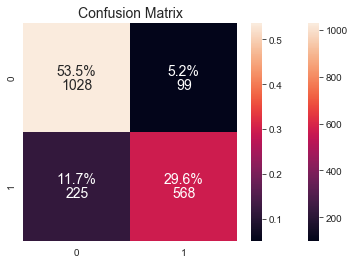

In [93]:
# stacking a new model (LR) on top of the two bases
df_stack_tr = pd.concat([train_pred1, train_pred2], axis=1)
df_stack_tr.columns = ['xgb','svc']
df_stack_tst = pd.concat([test_pred1, test_pred2], axis=1)
df_stack_tst.columns = ['xgb','svc']

model_stack = LogisticRegression(solver='lbfgs', random_state=42)
model_stack.fit(df_stack_tr, y_train.koi_pdisposition)

print('Train Score:', model_stack.score(df_stack_tr, y_train.koi_pdisposition))
print('Test Score:', model_stack.score(df_stack_tst, y_test.koi_pdisposition))
y_pred = model_stack.predict(df_stack_tst)
confu_matrix(y_pred, df_stack_tst, y_test)

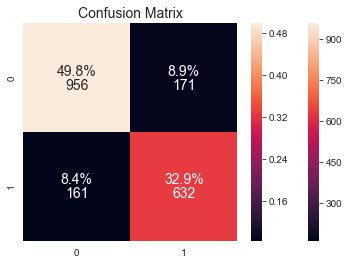

Train accuracy: 80.42%
Test accuracy: 82.71%
{'C': [1.5], 'class_weight': ['balanced'], 'solver': ['newton-cg']}


In [94]:
# tuning stacked model hyperparameters
for i in [1]:
    if i == 1:
        X_train = df_stack_tr
        X_test = df_stack_tst
        model_stack = LogisticRegression(random_state=42)
        lr_params = {'C': [.1, 1, 1.5, 2, 2.5],
                     'class_weight': [None,'balanced'],
                     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                    }
        best_params, model_stacked = gridsearch_params(model_stack, lr_params, update_params=False)

## Sigh...

Oddly, the model performs better on the test dataset than it does on the train dataset. At least the scores are pretty close together.

# Results and Interpretation

So, after all of this nonsense, it appears that the two models which struck the best balance between test accuracy score and minimizing overfitting were the vanilla versions of SVC. Here's a table comparing them all (in descending order of Test Accuracy):

| Order created in notebook | Method | PCA? | Train | Test | divergence |
| --- | --- | --- | --- | --- | --- |
| 13 | SVC (vanilla) | yes | 85.60% | 83.59% | 2.01% |
| 6 | SVC grid | no | 84.59% | 83.33% | 1.26% |
| 14 | SVC grid | yes | 84.94% | 83.23% | 1.71% |
| 7 | RFC (vanilla) | no | 99.98% | 83.18% | 16.80% |
| 15 | STACK (XGB-SVC ---> LR) | yes | 80.30% | 83.12% | 2.82% |
| 5 | SVC (vanilla) | no | 85.24% | 82.92% | 2.32% |
| 16 | STACK grid (XGB-SVC ---> LR) | yes | 80.56% | 82.92% | 2.36% |
| 1 | XGB (vanilla): | no | 85.24% | 82.03% | 3.21% |
| 3 | XGB grid (depth--child): | no | 84.00% | 81.98% | 2.02% |
| 4 | XGB grid (+gam—subs--col): | no | 83.57% | 81.98% | 1.59% |
| 10 | XGB (vanilla): | yes | 86.57% | 81.93% | 4.64% |
| 12 | XGB grid (+gam—subs--col): | yes | 86.68% | 81.88% | 4.80% |
| 11 | XGB grid (depth--child): | yes | 86.82% | 81.72% | 5.10% |
| 8 | RFC grid | no | 81.38% | 80.52% | 0.86% |
| 2 | XGB-SVC-RFC (vanilla): | no | 96.76% | 80.26% | 16.50% |
| 9 | XGBgrid+SVCgrid+RFCgrid: | no | 83.46% | 80.05% | 3.41% |

What's the takeaway from all of this? Don't put any effort into building a model   **`:-P`**

But seriously, apparently XGBoost and Support Vector Classifiers are already pretty powerful, so there's not much room for improvement, at least with this dataset.

At best, we can correctly identify whether a Kepler Object of Interest is a planet or not with only 82% or 83% accuracy.